In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [7]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d splcher/animefacedataset

 98% 385M/395M [00:10<00:00, 21.6MB/s]
100% 395M/395M [00:10<00:00, 40.3MB/s]


In [8]:
import os
from zipfile import ZipFile
with ZipFile('animefacedataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')
print("done")

done


In [9]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import img_to_array
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras import backend as K
import keras

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [0]:
LATENT_DIM = 32
CHANNELS = 3
def build_generator():
    gen_input = Input(shape=(LATENT_DIM, ))
    
    x = Dense(128 *16 *16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=1, padding='same')(x)
    x = LeakyReLU()(x)

    
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    #x = Reshape(image_dim)(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)
    #x = Reshape((96, 96, 3))(x)
    
    
    generator = Model(gen_input, x)
    return generator

In [0]:
def build_discriminator():
    disc_input = Input(shape=image_dim)
    
    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    return discriminator

In [0]:
ep = 1000
lr = 0.001
bs = 16
image_dim = (64,64,3)

In [13]:
data = []

print("Loading images....")
waifu_paths = list(paths.list_images("data"))
for waifu_path in waifu_paths:
    image = cv2.imread(waifu_path)
    image = cv2.resize(image, (image_dim[1], image_dim[0]))
    image = img_to_array(image)
    
    data.append(image)

print("Load completed")

Loading images....
Load completed


In [14]:
print(type(data))

<class 'list'>


In [15]:
data = np.array(data) /255.0

print("model create :")
print(data.shape)

model create :
(63565, 64, 64, 3)


(63565, 64, 64, 3)


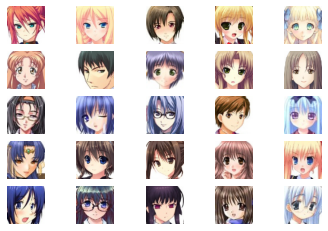

In [16]:
%matplotlib inline
r, c = 5, 5
#test = 0.5 * data + 0.5
fig, axs = plt.subplots(r, c)
cnt = 0
print(data.shape)
for i in range(r):
    for j in range(c):
        te = data[cnt, :,:]
        axs[i,j].imshow(cv2.cvtColor(te, cv2.COLOR_BGR2RGB))
        axs[i,j].axis('off')
        cnt += 1
#plt.close()

In [0]:
generator = build_generator()
discriminator = build_discriminator()
discriminator.trainable = False
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [19]:
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1/12000: d_loss: 0.6947,  a_loss: 0.6945.
2/12000: d_loss: 0.5357,  a_loss: 0.5222.
3/12000: d_loss: 3.5195,  a_loss: 0.3938.
4/12000: d_loss: 0.8313,  a_loss: 0.5782.
5/12000: d_loss: 0.7110,  a_loss: 0.8063.
6/12000: d_loss: 0.6281,  a_loss: 0.9738.
7/12000: d_loss: 0.6101,  a_loss: 1.1397.
8/12000: d_loss: 0.5847,  a_loss: 1.1221.
9/12000: d_loss: 0.5593,  a_loss: 1.2773.
10/12000: d_loss: 0.5563,  a_loss: 1.1997.
11/12000: d_loss: 0.5100,  a_loss: 1.6000.
12/12000: d_loss: 0.4850,  a_loss: 0.7969.
13/12000: d_loss: 0.4843,  a_loss: 3.7676.
14/12000: d_loss: 0.6962,  a_loss: 0.7250.
15/12000: d_loss: 0.5869,  a_loss: 0.7074.
16/12000: d_loss: 0.5638,  a_loss: 0.6821.
17/12000: d_loss: 0.5026,  a_loss: 0.6728.
18/12000: d_loss: 0.5567,  a_loss: 0.8914.
19/12000: d_loss: 0.5379,  a_loss: 0.6959.
20/12000: d_loss: 0.4598,  a_loss: 0.6762.
21/12000: d_loss: 0.4772,  a_loss: 0.6468.
22/12000: d_loss: 0.5485,  a_loss: 0.7566.
23/12000: d_loss: 0.5233,  a_loss: 0.6455.
24/12000: d_loss: 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100/12000: d_loss: 0.5186,  a_loss: 1.0413.


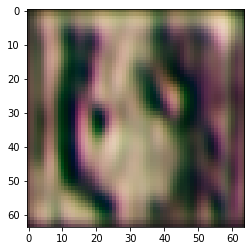

101/12000: d_loss: 0.5145,  a_loss: 1.0173.
102/12000: d_loss: 0.5829,  a_loss: 1.2951.
103/12000: d_loss: 0.6056,  a_loss: 0.5067.
104/12000: d_loss: 0.8141,  a_loss: 0.9477.
105/12000: d_loss: 0.6409,  a_loss: 0.8210.
106/12000: d_loss: 0.5577,  a_loss: 0.6705.
107/12000: d_loss: 0.6761,  a_loss: 0.8021.
108/12000: d_loss: 0.6246,  a_loss: 0.8139.
109/12000: d_loss: 0.5632,  a_loss: 0.8271.
110/12000: d_loss: 0.6299,  a_loss: 1.3113.
111/12000: d_loss: 0.6156,  a_loss: 0.7493.
112/12000: d_loss: 0.6660,  a_loss: 1.0167.
113/12000: d_loss: 0.5560,  a_loss: 1.0180.
114/12000: d_loss: 0.6034,  a_loss: 1.3524.
115/12000: d_loss: 0.5388,  a_loss: 1.9511.
116/12000: d_loss: 0.5853,  a_loss: 0.8157.
117/12000: d_loss: 0.5989,  a_loss: 0.8365.
118/12000: d_loss: 0.5082,  a_loss: 0.9113.
119/12000: d_loss: 0.5758,  a_loss: 1.0543.
120/12000: d_loss: 0.5658,  a_loss: 1.1815.
121/12000: d_loss: 0.6039,  a_loss: 1.2914.
122/12000: d_loss: 0.6734,  a_loss: 2.1809.
123/12000: d_loss: 0.6966,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


200/12000: d_loss: 0.5598,  a_loss: 1.0836.


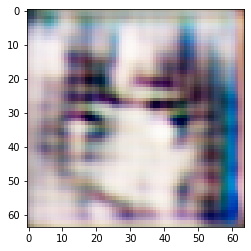

201/12000: d_loss: 0.5725,  a_loss: 1.4967.
202/12000: d_loss: 0.6324,  a_loss: 0.6594.
203/12000: d_loss: 0.6925,  a_loss: 1.6235.
204/12000: d_loss: 0.5596,  a_loss: 1.1809.
205/12000: d_loss: 0.5339,  a_loss: 1.0041.
206/12000: d_loss: 0.5602,  a_loss: 1.1607.
207/12000: d_loss: 0.5129,  a_loss: 3.1184.
208/12000: d_loss: 0.6603,  a_loss: 0.7996.
209/12000: d_loss: 1.2115,  a_loss: 1.3314.
210/12000: d_loss: 0.5861,  a_loss: 0.9954.
211/12000: d_loss: 0.5702,  a_loss: 1.3027.
212/12000: d_loss: 0.5128,  a_loss: 1.3198.
213/12000: d_loss: 0.4958,  a_loss: 1.0982.
214/12000: d_loss: 0.5823,  a_loss: 1.1820.
215/12000: d_loss: 0.7025,  a_loss: 0.9541.
216/12000: d_loss: 0.5905,  a_loss: 1.8704.
217/12000: d_loss: 0.6060,  a_loss: 1.0094.
218/12000: d_loss: 0.4863,  a_loss: 1.3509.
219/12000: d_loss: 0.4749,  a_loss: 1.6741.
220/12000: d_loss: 0.5346,  a_loss: 2.0216.
221/12000: d_loss: 0.5337,  a_loss: 1.8556.
222/12000: d_loss: 0.6214,  a_loss: 0.7741.
223/12000: d_loss: 0.6473,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


300/12000: d_loss: 0.5299,  a_loss: 1.3771.


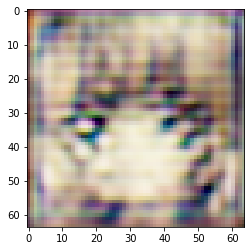

301/12000: d_loss: 0.5255,  a_loss: 1.5839.
302/12000: d_loss: 0.4518,  a_loss: 1.2544.
303/12000: d_loss: 0.4220,  a_loss: 1.5849.
304/12000: d_loss: 0.4421,  a_loss: 1.4995.
305/12000: d_loss: 0.4596,  a_loss: 1.7737.
306/12000: d_loss: 0.4562,  a_loss: 0.9298.
307/12000: d_loss: 0.7193,  a_loss: 2.7659.
308/12000: d_loss: 0.7352,  a_loss: 0.6278.
309/12000: d_loss: 0.6857,  a_loss: 1.5091.
310/12000: d_loss: 0.5443,  a_loss: 1.2610.
311/12000: d_loss: 0.4643,  a_loss: 1.5507.
312/12000: d_loss: 0.3662,  a_loss: 1.6298.
313/12000: d_loss: 0.4160,  a_loss: 2.2180.
314/12000: d_loss: 0.3349,  a_loss: 1.2841.
315/12000: d_loss: 0.4735,  a_loss: 2.6480.
316/12000: d_loss: 0.4147,  a_loss: 1.6611.
317/12000: d_loss: 0.3989,  a_loss: 2.6120.
318/12000: d_loss: 0.4288,  a_loss: 1.9590.
319/12000: d_loss: 0.4162,  a_loss: 3.5631.
320/12000: d_loss: 0.5880,  a_loss: 0.7635.
321/12000: d_loss: 0.7855,  a_loss: 2.8564.
322/12000: d_loss: 0.7101,  a_loss: 0.9402.
323/12000: d_loss: 0.4449,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


400/12000: d_loss: 0.6092,  a_loss: 0.8694.


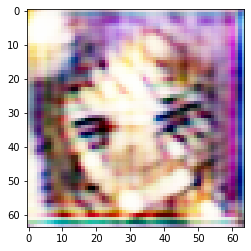

401/12000: d_loss: 0.7601,  a_loss: 3.3565.
402/12000: d_loss: 0.7362,  a_loss: 0.5850.
403/12000: d_loss: 0.6740,  a_loss: 1.7137.
404/12000: d_loss: 0.6736,  a_loss: 0.8824.
405/12000: d_loss: 0.5482,  a_loss: 1.4960.
406/12000: d_loss: 0.5064,  a_loss: 1.2306.
407/12000: d_loss: 0.5130,  a_loss: 1.4276.
408/12000: d_loss: 0.6317,  a_loss: 2.4623.
409/12000: d_loss: 0.3757,  a_loss: 1.5252.
410/12000: d_loss: 0.6013,  a_loss: 2.4077.
411/12000: d_loss: 0.6562,  a_loss: 0.9645.
412/12000: d_loss: 0.8814,  a_loss: 2.8839.
413/12000: d_loss: 0.7728,  a_loss: 1.1151.
414/12000: d_loss: 0.5618,  a_loss: 1.5312.
415/12000: d_loss: 0.5671,  a_loss: 0.8699.
416/12000: d_loss: 0.6262,  a_loss: 1.5466.
417/12000: d_loss: 0.6561,  a_loss: 0.7670.
418/12000: d_loss: 0.6362,  a_loss: 1.6595.
419/12000: d_loss: 0.6750,  a_loss: 1.3562.
420/12000: d_loss: 0.5027,  a_loss: 2.2205.
421/12000: d_loss: 0.6855,  a_loss: 0.8068.
422/12000: d_loss: 0.7101,  a_loss: 1.5467.
423/12000: d_loss: 0.5776,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


500/12000: d_loss: 0.6485,  a_loss: 1.0372.


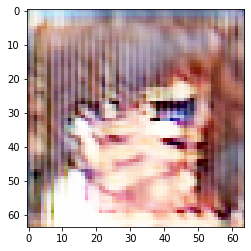

501/12000: d_loss: 0.6256,  a_loss: 1.2631.
502/12000: d_loss: 0.6729,  a_loss: 1.3215.
503/12000: d_loss: 0.6755,  a_loss: 1.5555.
504/12000: d_loss: 0.6582,  a_loss: 1.5682.
505/12000: d_loss: 0.6427,  a_loss: 0.6495.
506/12000: d_loss: 0.6317,  a_loss: 1.2339.
507/12000: d_loss: 0.6270,  a_loss: 0.8550.
508/12000: d_loss: 0.6622,  a_loss: 1.3326.
509/12000: d_loss: 0.5190,  a_loss: 1.0790.
510/12000: d_loss: 0.6222,  a_loss: 1.9003.
511/12000: d_loss: 0.5551,  a_loss: 2.0849.
512/12000: d_loss: 0.7178,  a_loss: 0.7281.
513/12000: d_loss: 0.6376,  a_loss: 1.2136.
514/12000: d_loss: 0.5637,  a_loss: 1.0215.
515/12000: d_loss: 0.6724,  a_loss: 1.1562.
516/12000: d_loss: 0.6489,  a_loss: 0.9086.
517/12000: d_loss: 0.6006,  a_loss: 1.3214.
518/12000: d_loss: 0.6946,  a_loss: 1.0800.
519/12000: d_loss: 0.6670,  a_loss: 1.4811.
520/12000: d_loss: 0.4836,  a_loss: 1.2485.
521/12000: d_loss: 0.6199,  a_loss: 1.9416.
522/12000: d_loss: 0.5672,  a_loss: 1.0757.
523/12000: d_loss: 0.6914,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


600/12000: d_loss: 0.7359,  a_loss: 1.1562.


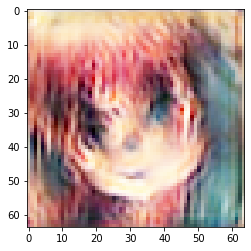

601/12000: d_loss: 0.7260,  a_loss: 1.2230.
602/12000: d_loss: 0.6864,  a_loss: 0.9155.
603/12000: d_loss: 0.6075,  a_loss: 1.0067.
604/12000: d_loss: 0.7043,  a_loss: 0.9435.
605/12000: d_loss: 0.7302,  a_loss: 0.9876.
606/12000: d_loss: 0.6388,  a_loss: 1.0427.
607/12000: d_loss: 0.6163,  a_loss: 1.0090.
608/12000: d_loss: 0.6501,  a_loss: 0.8837.
609/12000: d_loss: 0.7392,  a_loss: 1.4709.
610/12000: d_loss: 0.6158,  a_loss: 0.5535.
611/12000: d_loss: 0.8549,  a_loss: 1.6695.
612/12000: d_loss: 0.6469,  a_loss: 0.8296.
613/12000: d_loss: 0.6889,  a_loss: 0.9983.
614/12000: d_loss: 0.6511,  a_loss: 0.8231.
615/12000: d_loss: 0.7027,  a_loss: 0.9490.
616/12000: d_loss: 0.6248,  a_loss: 0.8476.
617/12000: d_loss: 0.6625,  a_loss: 0.9650.
618/12000: d_loss: 0.6149,  a_loss: 1.0153.
619/12000: d_loss: 0.6749,  a_loss: 0.9541.
620/12000: d_loss: 0.6218,  a_loss: 0.9262.
621/12000: d_loss: 0.6258,  a_loss: 0.7592.
622/12000: d_loss: 0.6548,  a_loss: 1.4807.
623/12000: d_loss: 0.6232,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


700/12000: d_loss: 0.6915,  a_loss: 1.0356.


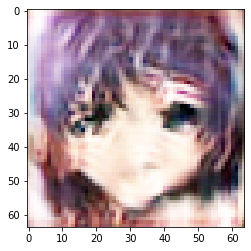

701/12000: d_loss: 0.6604,  a_loss: 1.0284.
702/12000: d_loss: 0.6270,  a_loss: 0.8792.
703/12000: d_loss: 0.7171,  a_loss: 1.2562.
704/12000: d_loss: 0.6300,  a_loss: 0.8570.
705/12000: d_loss: 0.7215,  a_loss: 1.0481.
706/12000: d_loss: 0.6594,  a_loss: 0.9927.
707/12000: d_loss: 0.6831,  a_loss: 1.0766.
708/12000: d_loss: 0.6727,  a_loss: 0.8386.
709/12000: d_loss: 0.6310,  a_loss: 1.0782.
710/12000: d_loss: 0.6537,  a_loss: 0.9561.
711/12000: d_loss: 0.7792,  a_loss: 1.2466.
712/12000: d_loss: 0.6610,  a_loss: 0.8656.
713/12000: d_loss: 0.6292,  a_loss: 0.9812.
714/12000: d_loss: 0.6748,  a_loss: 0.9006.
715/12000: d_loss: 0.6417,  a_loss: 1.0975.
716/12000: d_loss: 0.5861,  a_loss: 1.0094.
717/12000: d_loss: 0.5889,  a_loss: 1.1598.
718/12000: d_loss: 0.6019,  a_loss: 0.8667.
719/12000: d_loss: 0.7547,  a_loss: 1.3859.
720/12000: d_loss: 0.6029,  a_loss: 0.6905.
721/12000: d_loss: 0.7014,  a_loss: 1.0830.
722/12000: d_loss: 0.7971,  a_loss: 1.1744.
723/12000: d_loss: 0.6996,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


800/12000: d_loss: 0.7482,  a_loss: 0.8549.


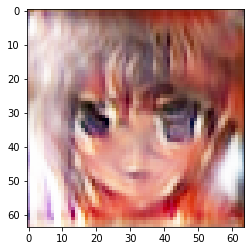

801/12000: d_loss: 0.8959,  a_loss: 1.6451.
802/12000: d_loss: 0.6861,  a_loss: 0.7560.
803/12000: d_loss: 0.6805,  a_loss: 0.9733.
804/12000: d_loss: 0.8468,  a_loss: 0.9281.
805/12000: d_loss: 0.7021,  a_loss: 0.8106.
806/12000: d_loss: 0.6868,  a_loss: 0.8563.
807/12000: d_loss: 0.6797,  a_loss: 0.8906.
808/12000: d_loss: 0.6410,  a_loss: 0.9117.
809/12000: d_loss: 0.6516,  a_loss: 1.0271.
810/12000: d_loss: 0.5875,  a_loss: 0.9738.
811/12000: d_loss: 0.6272,  a_loss: 1.1334.
812/12000: d_loss: 0.6476,  a_loss: 0.7848.
813/12000: d_loss: 0.6635,  a_loss: 1.3865.
814/12000: d_loss: 0.6838,  a_loss: 0.6709.
815/12000: d_loss: 0.7178,  a_loss: 1.3758.
816/12000: d_loss: 0.6761,  a_loss: 0.7238.
817/12000: d_loss: 0.8161,  a_loss: 1.0185.
818/12000: d_loss: 0.6479,  a_loss: 0.8329.
819/12000: d_loss: 0.6420,  a_loss: 1.0241.
820/12000: d_loss: 0.6668,  a_loss: 0.9085.
821/12000: d_loss: 0.6476,  a_loss: 0.9366.
822/12000: d_loss: 0.6521,  a_loss: 1.0587.
823/12000: d_loss: 0.6425,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


900/12000: d_loss: 0.6886,  a_loss: 0.9042.


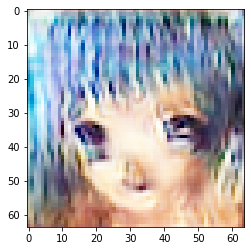

901/12000: d_loss: 0.7679,  a_loss: 0.9580.
902/12000: d_loss: 0.6659,  a_loss: 0.7895.
903/12000: d_loss: 0.7166,  a_loss: 1.1238.
904/12000: d_loss: 0.6695,  a_loss: 0.8951.
905/12000: d_loss: 0.7090,  a_loss: 0.8527.
906/12000: d_loss: 0.6877,  a_loss: 0.8821.
907/12000: d_loss: 0.6663,  a_loss: 0.8349.
908/12000: d_loss: 0.6611,  a_loss: 0.7759.
909/12000: d_loss: 0.6899,  a_loss: 0.9001.
910/12000: d_loss: 0.6534,  a_loss: 0.8347.
911/12000: d_loss: 0.6574,  a_loss: 0.8302.
912/12000: d_loss: 0.6514,  a_loss: 1.0009.
913/12000: d_loss: 0.6487,  a_loss: 0.8251.
914/12000: d_loss: 0.6941,  a_loss: 1.1134.
915/12000: d_loss: 0.6866,  a_loss: 0.7883.
916/12000: d_loss: 0.6896,  a_loss: 0.9472.
917/12000: d_loss: 0.6836,  a_loss: 0.8560.
918/12000: d_loss: 0.7102,  a_loss: 1.0079.
919/12000: d_loss: 0.6532,  a_loss: 0.9562.
920/12000: d_loss: 0.6653,  a_loss: 0.8612.
921/12000: d_loss: 0.6804,  a_loss: 0.8365.
922/12000: d_loss: 0.6620,  a_loss: 0.8721.
923/12000: d_loss: 0.6754,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000/12000: d_loss: 0.6855,  a_loss: 0.7858.


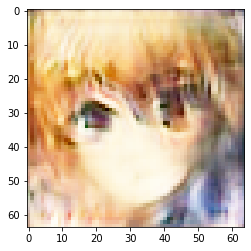

1001/12000: d_loss: 0.6213,  a_loss: 0.9476.
1002/12000: d_loss: 0.6749,  a_loss: 0.8878.
1003/12000: d_loss: 0.6655,  a_loss: 0.9983.
1004/12000: d_loss: 0.6923,  a_loss: 0.7987.
1005/12000: d_loss: 0.6842,  a_loss: 1.0322.
1006/12000: d_loss: 0.6490,  a_loss: 0.6394.
1007/12000: d_loss: 0.7154,  a_loss: 0.9532.
1008/12000: d_loss: 0.7165,  a_loss: 0.8249.
1009/12000: d_loss: 0.7744,  a_loss: 1.0568.
1010/12000: d_loss: 0.7533,  a_loss: 0.8093.
1011/12000: d_loss: 0.6519,  a_loss: 0.9463.
1012/12000: d_loss: 0.6402,  a_loss: 0.8943.
1013/12000: d_loss: 0.6278,  a_loss: 0.9385.
1014/12000: d_loss: 0.6481,  a_loss: 0.9591.
1015/12000: d_loss: 0.6493,  a_loss: 0.9467.
1016/12000: d_loss: 0.6569,  a_loss: 1.0677.
1017/12000: d_loss: 0.7299,  a_loss: 0.9809.
1018/12000: d_loss: 0.6794,  a_loss: 0.9059.
1019/12000: d_loss: 0.6780,  a_loss: 1.1136.
1020/12000: d_loss: 0.6835,  a_loss: 0.8037.
1021/12000: d_loss: 0.6848,  a_loss: 1.1356.
1022/12000: d_loss: 0.7055,  a_loss: 0.7221.
1023/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1100/12000: d_loss: 0.6742,  a_loss: 0.7306.


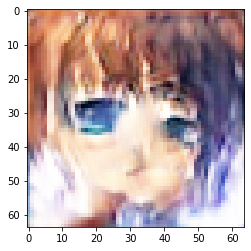

1101/12000: d_loss: 0.7072,  a_loss: 0.9600.
1102/12000: d_loss: 0.6582,  a_loss: 0.8704.
1103/12000: d_loss: 0.6682,  a_loss: 0.7911.
1104/12000: d_loss: 0.6814,  a_loss: 1.0618.
1105/12000: d_loss: 0.6622,  a_loss: 0.8376.
1106/12000: d_loss: 0.6703,  a_loss: 1.0309.
1107/12000: d_loss: 0.6744,  a_loss: 0.8483.
1108/12000: d_loss: 0.6433,  a_loss: 0.8315.
1109/12000: d_loss: 0.6773,  a_loss: 1.0334.
1110/12000: d_loss: 0.7446,  a_loss: 0.8639.
1111/12000: d_loss: 0.6736,  a_loss: 0.8514.
1112/12000: d_loss: 0.6701,  a_loss: 0.8263.
1113/12000: d_loss: 0.6854,  a_loss: 1.0554.
1114/12000: d_loss: 0.7043,  a_loss: 0.8076.
1115/12000: d_loss: 0.6892,  a_loss: 0.9133.
1116/12000: d_loss: 0.6837,  a_loss: 0.9205.
1117/12000: d_loss: 0.6537,  a_loss: 0.8812.
1118/12000: d_loss: 0.7257,  a_loss: 1.0866.
1119/12000: d_loss: 0.6302,  a_loss: 0.8432.
1120/12000: d_loss: 0.6569,  a_loss: 1.0575.
1121/12000: d_loss: 0.6571,  a_loss: 0.8115.
1122/12000: d_loss: 0.6588,  a_loss: 0.9597.
1123/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1200/12000: d_loss: 0.6887,  a_loss: 0.9162.


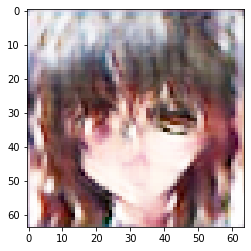

1201/12000: d_loss: 0.7018,  a_loss: 0.9658.
1202/12000: d_loss: 0.6614,  a_loss: 0.7232.
1203/12000: d_loss: 0.6559,  a_loss: 0.9540.
1204/12000: d_loss: 0.6736,  a_loss: 0.9077.
1205/12000: d_loss: 0.6297,  a_loss: 1.1135.
1206/12000: d_loss: 0.6862,  a_loss: 0.7739.
1207/12000: d_loss: 0.6801,  a_loss: 1.1300.
1208/12000: d_loss: 0.6896,  a_loss: 0.7863.
1209/12000: d_loss: 0.6954,  a_loss: 1.0074.
1210/12000: d_loss: 0.7906,  a_loss: 1.1872.
1211/12000: d_loss: 0.6919,  a_loss: 0.8572.
1212/12000: d_loss: 0.6372,  a_loss: 0.8810.
1213/12000: d_loss: 0.6823,  a_loss: 0.7835.
1214/12000: d_loss: 0.6452,  a_loss: 0.9239.
1215/12000: d_loss: 0.6989,  a_loss: 0.9260.
1216/12000: d_loss: 0.6975,  a_loss: 0.8714.
1217/12000: d_loss: 0.6752,  a_loss: 0.9446.
1218/12000: d_loss: 0.7220,  a_loss: 0.8441.
1219/12000: d_loss: 0.7134,  a_loss: 0.8013.
1220/12000: d_loss: 0.6823,  a_loss: 0.8427.
1221/12000: d_loss: 0.6617,  a_loss: 0.9629.
1222/12000: d_loss: 0.7371,  a_loss: 0.8568.
1223/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1300/12000: d_loss: 0.6966,  a_loss: 0.8338.


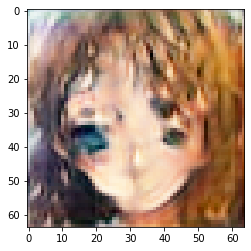

1301/12000: d_loss: 0.6711,  a_loss: 0.7943.
1302/12000: d_loss: 0.6674,  a_loss: 0.7883.
1303/12000: d_loss: 0.6834,  a_loss: 0.8899.
1304/12000: d_loss: 0.6728,  a_loss: 0.7944.
1305/12000: d_loss: 0.6845,  a_loss: 0.8337.
1306/12000: d_loss: 0.6784,  a_loss: 0.8257.
1307/12000: d_loss: 0.6780,  a_loss: 0.8621.
1308/12000: d_loss: 0.6815,  a_loss: 0.8350.
1309/12000: d_loss: 0.7079,  a_loss: 0.8142.
1310/12000: d_loss: 0.6794,  a_loss: 0.7679.
1311/12000: d_loss: 0.7043,  a_loss: 0.8861.
1312/12000: d_loss: 0.6665,  a_loss: 0.8251.
1313/12000: d_loss: 0.7152,  a_loss: 1.1469.
1314/12000: d_loss: 0.6578,  a_loss: 0.8011.
1315/12000: d_loss: 0.7088,  a_loss: 0.8217.
1316/12000: d_loss: 0.6423,  a_loss: 0.7998.
1317/12000: d_loss: 0.6699,  a_loss: 1.2000.
1318/12000: d_loss: 0.7096,  a_loss: 0.7823.
1319/12000: d_loss: 0.6791,  a_loss: 0.8716.
1320/12000: d_loss: 0.6914,  a_loss: 0.8712.
1321/12000: d_loss: 0.7052,  a_loss: 0.9669.
1322/12000: d_loss: 0.6897,  a_loss: 0.9372.
1323/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1400/12000: d_loss: 0.6710,  a_loss: 0.8390.


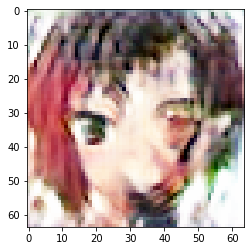

1401/12000: d_loss: 0.7168,  a_loss: 0.8780.
1402/12000: d_loss: 0.6730,  a_loss: 0.8729.
1403/12000: d_loss: 0.6954,  a_loss: 0.9094.
1404/12000: d_loss: 0.6805,  a_loss: 0.7940.
1405/12000: d_loss: 0.6643,  a_loss: 0.8166.
1406/12000: d_loss: 0.6725,  a_loss: 0.9910.
1407/12000: d_loss: 0.6808,  a_loss: 0.8848.
1408/12000: d_loss: 0.6635,  a_loss: 0.8068.
1409/12000: d_loss: 0.6787,  a_loss: 0.9491.
1410/12000: d_loss: 0.6719,  a_loss: 0.7757.
1411/12000: d_loss: 0.7146,  a_loss: 0.9677.
1412/12000: d_loss: 0.7034,  a_loss: 0.8500.
1413/12000: d_loss: 0.6732,  a_loss: 0.7993.
1414/12000: d_loss: 0.6961,  a_loss: 0.7423.
1415/12000: d_loss: 0.6911,  a_loss: 0.8728.
1416/12000: d_loss: 0.6617,  a_loss: 0.8130.
1417/12000: d_loss: 0.7145,  a_loss: 0.9809.
1418/12000: d_loss: 0.6989,  a_loss: 0.9274.
1419/12000: d_loss: 0.6541,  a_loss: 0.8735.
1420/12000: d_loss: 0.6906,  a_loss: 0.7837.
1421/12000: d_loss: 0.6480,  a_loss: 0.8820.
1422/12000: d_loss: 0.6366,  a_loss: 0.8302.
1423/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1500/12000: d_loss: 0.6531,  a_loss: 0.8447.


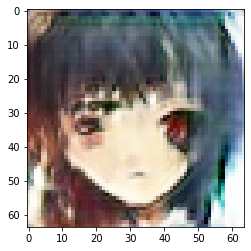

1501/12000: d_loss: 0.6333,  a_loss: 0.7774.
1502/12000: d_loss: 0.6967,  a_loss: 1.0586.
1503/12000: d_loss: 0.6923,  a_loss: 0.7694.
1504/12000: d_loss: 0.6740,  a_loss: 1.0638.
1505/12000: d_loss: 0.6790,  a_loss: 0.8846.
1506/12000: d_loss: 0.6873,  a_loss: 0.8360.
1507/12000: d_loss: 0.6813,  a_loss: 0.9172.
1508/12000: d_loss: 0.6622,  a_loss: 0.8255.
1509/12000: d_loss: 0.6905,  a_loss: 1.0763.
1510/12000: d_loss: 0.6574,  a_loss: 0.8689.
1511/12000: d_loss: 0.6778,  a_loss: 0.8498.
1512/12000: d_loss: 0.6986,  a_loss: 0.7851.
1513/12000: d_loss: 0.6959,  a_loss: 0.8894.
1514/12000: d_loss: 0.6924,  a_loss: 0.6998.
1515/12000: d_loss: 0.6936,  a_loss: 0.9894.
1516/12000: d_loss: 0.6622,  a_loss: 0.8489.
1517/12000: d_loss: 0.6666,  a_loss: 0.8807.
1518/12000: d_loss: 0.6616,  a_loss: 0.8966.
1519/12000: d_loss: 0.6858,  a_loss: 1.0273.
1520/12000: d_loss: 0.6643,  a_loss: 0.7620.
1521/12000: d_loss: 0.8175,  a_loss: 1.1708.
1522/12000: d_loss: 0.6934,  a_loss: 0.7818.
1523/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1600/12000: d_loss: 0.6614,  a_loss: 0.7598.


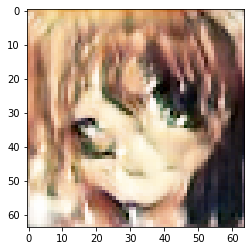

1601/12000: d_loss: 0.6536,  a_loss: 0.8637.
1602/12000: d_loss: 0.7040,  a_loss: 0.9341.
1603/12000: d_loss: 0.6643,  a_loss: 0.8056.
1604/12000: d_loss: 0.6763,  a_loss: 0.9679.
1605/12000: d_loss: 0.7004,  a_loss: 0.7989.
1606/12000: d_loss: 0.6863,  a_loss: 1.0640.
1607/12000: d_loss: 0.7122,  a_loss: 0.7439.
1608/12000: d_loss: 0.6760,  a_loss: 0.8730.
1609/12000: d_loss: 0.6938,  a_loss: 0.8647.
1610/12000: d_loss: 0.6957,  a_loss: 0.8821.
1611/12000: d_loss: 0.6690,  a_loss: 0.8468.
1612/12000: d_loss: 0.7168,  a_loss: 0.9836.
1613/12000: d_loss: 0.6792,  a_loss: 0.7670.
1614/12000: d_loss: 0.7132,  a_loss: 0.9953.
1615/12000: d_loss: 0.6760,  a_loss: 0.8386.
1616/12000: d_loss: 0.6655,  a_loss: 0.8720.
1617/12000: d_loss: 0.6819,  a_loss: 0.8752.
1618/12000: d_loss: 0.6921,  a_loss: 1.0026.
1619/12000: d_loss: 0.6624,  a_loss: 0.7672.
1620/12000: d_loss: 0.6825,  a_loss: 0.8346.
1621/12000: d_loss: 0.6783,  a_loss: 0.9248.
1622/12000: d_loss: 0.7060,  a_loss: 0.9341.
1623/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1700/12000: d_loss: 0.6834,  a_loss: 0.8412.


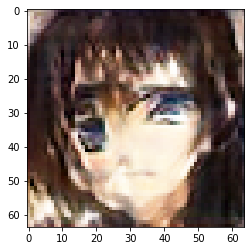

1701/12000: d_loss: 0.6937,  a_loss: 0.8271.
1702/12000: d_loss: 0.6952,  a_loss: 0.8554.
1703/12000: d_loss: 0.6793,  a_loss: 0.7849.
1704/12000: d_loss: 0.6641,  a_loss: 0.7934.
1705/12000: d_loss: 0.7231,  a_loss: 0.8575.
1706/12000: d_loss: 0.6782,  a_loss: 0.7831.
1707/12000: d_loss: 0.6991,  a_loss: 0.9388.
1708/12000: d_loss: 0.6975,  a_loss: 0.8379.
1709/12000: d_loss: 0.6708,  a_loss: 0.7703.
1710/12000: d_loss: 0.7014,  a_loss: 0.8999.
1711/12000: d_loss: 0.6748,  a_loss: 0.8665.
1712/12000: d_loss: 0.6597,  a_loss: 0.8360.
1713/12000: d_loss: 0.6717,  a_loss: 0.8956.
1714/12000: d_loss: 0.6828,  a_loss: 0.9043.
1715/12000: d_loss: 0.6651,  a_loss: 0.8112.
1716/12000: d_loss: 0.6520,  a_loss: 0.8596.
1717/12000: d_loss: 0.6260,  a_loss: 0.9708.
1718/12000: d_loss: 0.6770,  a_loss: 1.0414.
1719/12000: d_loss: 0.6769,  a_loss: 0.9642.
1720/12000: d_loss: 0.7205,  a_loss: 0.7459.
1721/12000: d_loss: 0.6891,  a_loss: 0.8248.
1722/12000: d_loss: 0.6635,  a_loss: 0.9407.
1723/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1800/12000: d_loss: 0.6904,  a_loss: 0.8341.


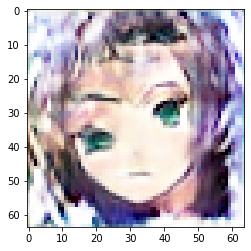

1801/12000: d_loss: 0.6811,  a_loss: 0.8040.
1802/12000: d_loss: 0.6912,  a_loss: 0.9591.
1803/12000: d_loss: 0.6928,  a_loss: 0.7988.
1804/12000: d_loss: 0.6517,  a_loss: 0.9494.
1805/12000: d_loss: 0.6905,  a_loss: 0.7982.
1806/12000: d_loss: 0.6709,  a_loss: 0.9093.
1807/12000: d_loss: 0.6487,  a_loss: 0.8069.
1808/12000: d_loss: 0.6659,  a_loss: 0.8874.
1809/12000: d_loss: 0.6860,  a_loss: 0.6485.
1810/12000: d_loss: 0.7375,  a_loss: 1.0820.
1811/12000: d_loss: 0.7448,  a_loss: 0.8158.
1812/12000: d_loss: 0.7687,  a_loss: 0.8190.
1813/12000: d_loss: 0.6778,  a_loss: 0.7650.
1814/12000: d_loss: 0.6897,  a_loss: 0.8202.
1815/12000: d_loss: 0.6992,  a_loss: 0.7863.
1816/12000: d_loss: 0.6944,  a_loss: 0.9296.
1817/12000: d_loss: 0.6717,  a_loss: 0.9022.
1818/12000: d_loss: 0.6706,  a_loss: 0.8275.
1819/12000: d_loss: 0.6961,  a_loss: 0.8328.
1820/12000: d_loss: 0.6757,  a_loss: 0.8112.
1821/12000: d_loss: 0.6443,  a_loss: 0.7474.
1822/12000: d_loss: 0.7342,  a_loss: 1.0954.
1823/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1900/12000: d_loss: 0.6707,  a_loss: 0.8151.


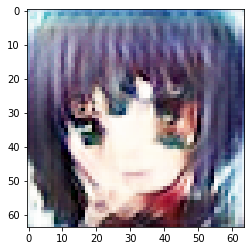

1901/12000: d_loss: 0.6864,  a_loss: 0.7963.
1902/12000: d_loss: 0.6949,  a_loss: 0.9554.
1903/12000: d_loss: 0.6850,  a_loss: 0.7903.
1904/12000: d_loss: 0.6799,  a_loss: 0.7572.
1905/12000: d_loss: 0.6590,  a_loss: 0.7812.
1906/12000: d_loss: 0.6686,  a_loss: 0.8503.
1907/12000: d_loss: 0.6646,  a_loss: 0.8361.
1908/12000: d_loss: 0.6702,  a_loss: 0.9839.
1909/12000: d_loss: 0.6776,  a_loss: 0.7968.
1910/12000: d_loss: 0.6843,  a_loss: 0.9855.
1911/12000: d_loss: 0.7236,  a_loss: 0.8071.
1912/12000: d_loss: 0.6885,  a_loss: 0.8536.
1913/12000: d_loss: 0.6510,  a_loss: 0.7283.
1914/12000: d_loss: 0.6742,  a_loss: 0.8603.
1915/12000: d_loss: 0.7030,  a_loss: 0.9300.
1916/12000: d_loss: 0.6804,  a_loss: 0.8595.
1917/12000: d_loss: 0.6818,  a_loss: 0.7990.
1918/12000: d_loss: 0.6890,  a_loss: 0.8374.
1919/12000: d_loss: 0.6567,  a_loss: 0.7752.
1920/12000: d_loss: 0.7287,  a_loss: 1.1104.
1921/12000: d_loss: 0.7052,  a_loss: 0.7982.
1922/12000: d_loss: 0.7392,  a_loss: 0.8457.
1923/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


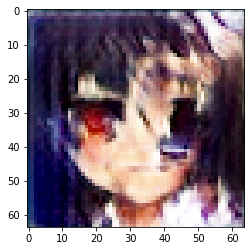

2001/12000: d_loss: 0.7077,  a_loss: 0.7424.
2002/12000: d_loss: 0.6850,  a_loss: 0.7875.
2003/12000: d_loss: 0.6566,  a_loss: 0.5994.
2004/12000: d_loss: 0.7840,  a_loss: 1.0386.
2005/12000: d_loss: 0.6843,  a_loss: 0.8480.
2006/12000: d_loss: 0.6825,  a_loss: 0.8141.
2007/12000: d_loss: 0.6655,  a_loss: 0.8537.
2008/12000: d_loss: 0.6867,  a_loss: 0.8463.
2009/12000: d_loss: 0.6964,  a_loss: 0.8803.
2010/12000: d_loss: 0.7055,  a_loss: 0.8532.
2011/12000: d_loss: 0.6654,  a_loss: 0.7728.
2012/12000: d_loss: 0.7160,  a_loss: 0.9907.
2013/12000: d_loss: 0.6851,  a_loss: 0.8089.
2014/12000: d_loss: 0.6777,  a_loss: 0.8688.
2015/12000: d_loss: 0.6524,  a_loss: 0.7231.
2016/12000: d_loss: 0.8405,  a_loss: 1.0940.
2017/12000: d_loss: 0.7040,  a_loss: 0.8625.
2018/12000: d_loss: 0.6957,  a_loss: 0.8993.
2019/12000: d_loss: 0.6745,  a_loss: 0.7725.
2020/12000: d_loss: 0.7300,  a_loss: 0.7607.
2021/12000: d_loss: 0.6815,  a_loss: 0.8308.
2022/12000: d_loss: 0.6571,  a_loss: 0.7932.
2023/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2100/12000: d_loss: 0.7037,  a_loss: 0.8057.


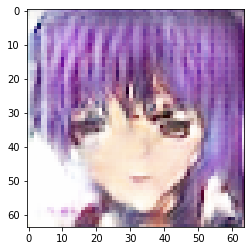

2101/12000: d_loss: 0.6385,  a_loss: 0.7918.
2102/12000: d_loss: 0.6809,  a_loss: 0.9218.
2103/12000: d_loss: 0.6887,  a_loss: 0.7997.
2104/12000: d_loss: 0.6574,  a_loss: 0.8386.
2105/12000: d_loss: 0.6956,  a_loss: 0.8663.
2106/12000: d_loss: 0.6619,  a_loss: 0.9512.
2107/12000: d_loss: 0.7055,  a_loss: 0.7752.
2108/12000: d_loss: 0.7214,  a_loss: 0.9154.
2109/12000: d_loss: 0.7317,  a_loss: 0.8350.
2110/12000: d_loss: 0.7646,  a_loss: 0.8521.
2111/12000: d_loss: 0.6909,  a_loss: 0.8661.
2112/12000: d_loss: 0.7110,  a_loss: 0.8541.
2113/12000: d_loss: 0.6864,  a_loss: 0.7744.
2114/12000: d_loss: 0.6969,  a_loss: 0.8922.
2115/12000: d_loss: 0.6786,  a_loss: 0.7730.
2116/12000: d_loss: 0.6587,  a_loss: 0.7679.
2117/12000: d_loss: 0.7281,  a_loss: 0.8784.
2118/12000: d_loss: 0.6965,  a_loss: 0.8176.
2119/12000: d_loss: 0.6837,  a_loss: 0.8412.
2120/12000: d_loss: 0.7020,  a_loss: 0.8740.
2121/12000: d_loss: 0.6896,  a_loss: 0.7952.
2122/12000: d_loss: 0.6795,  a_loss: 0.8359.
2123/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2200/12000: d_loss: 0.7129,  a_loss: 0.9935.


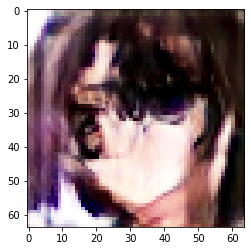

2201/12000: d_loss: 0.6545,  a_loss: 0.8185.
2202/12000: d_loss: 0.6959,  a_loss: 1.1302.
2203/12000: d_loss: 0.7104,  a_loss: 0.8598.
2204/12000: d_loss: 0.7460,  a_loss: 0.9275.
2205/12000: d_loss: 0.6667,  a_loss: 0.7714.
2206/12000: d_loss: 0.6894,  a_loss: 0.8728.
2207/12000: d_loss: 0.6796,  a_loss: 0.7904.
2208/12000: d_loss: 0.7042,  a_loss: 0.9367.
2209/12000: d_loss: 0.6823,  a_loss: 0.8312.
2210/12000: d_loss: 0.6970,  a_loss: 0.8692.
2211/12000: d_loss: 0.6679,  a_loss: 0.8426.
2212/12000: d_loss: 0.6843,  a_loss: 0.7588.
2213/12000: d_loss: 0.6937,  a_loss: 0.7481.
2214/12000: d_loss: 0.6676,  a_loss: 0.8474.
2215/12000: d_loss: 0.6930,  a_loss: 0.9815.
2216/12000: d_loss: 0.7015,  a_loss: 0.8270.
2217/12000: d_loss: 0.6848,  a_loss: 0.7876.
2218/12000: d_loss: 0.6947,  a_loss: 0.8980.
2219/12000: d_loss: 0.6885,  a_loss: 0.8424.
2220/12000: d_loss: 0.6926,  a_loss: 0.8466.
2221/12000: d_loss: 0.7037,  a_loss: 0.9183.
2222/12000: d_loss: 0.6881,  a_loss: 0.8414.
2223/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2300/12000: d_loss: 0.6657,  a_loss: 0.8699.


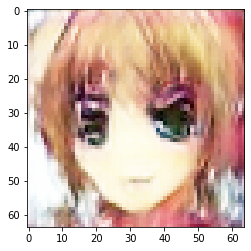

2301/12000: d_loss: 0.6700,  a_loss: 0.9303.
2302/12000: d_loss: 0.6226,  a_loss: 0.8239.
2303/12000: d_loss: 0.6946,  a_loss: 1.0094.
2304/12000: d_loss: 0.6935,  a_loss: 0.8249.
2305/12000: d_loss: 0.6989,  a_loss: 0.8712.
2306/12000: d_loss: 0.6892,  a_loss: 0.8111.
2307/12000: d_loss: 0.6680,  a_loss: 0.7352.
2308/12000: d_loss: 0.6806,  a_loss: 0.8786.
2309/12000: d_loss: 0.6659,  a_loss: 0.8331.
2310/12000: d_loss: 0.6790,  a_loss: 0.7398.
2311/12000: d_loss: 0.7174,  a_loss: 1.0309.
2312/12000: d_loss: 0.6707,  a_loss: 0.9096.
2313/12000: d_loss: 0.6525,  a_loss: 0.8086.
2314/12000: d_loss: 0.8013,  a_loss: 0.9362.
2315/12000: d_loss: 0.6871,  a_loss: 0.8357.
2316/12000: d_loss: 0.6626,  a_loss: 0.7897.
2317/12000: d_loss: 0.7169,  a_loss: 0.9670.
2318/12000: d_loss: 0.6793,  a_loss: 0.8150.
2319/12000: d_loss: 0.6805,  a_loss: 0.7972.
2320/12000: d_loss: 0.6739,  a_loss: 0.8515.
2321/12000: d_loss: 0.6739,  a_loss: 0.8830.
2322/12000: d_loss: 0.6627,  a_loss: 0.8329.
2323/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2400/12000: d_loss: 0.6720,  a_loss: 0.8040.


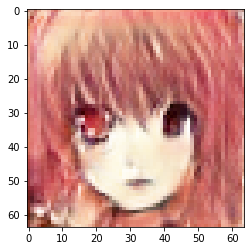

2401/12000: d_loss: 0.7063,  a_loss: 0.9126.
2402/12000: d_loss: 0.6388,  a_loss: 0.8445.
2403/12000: d_loss: 0.6426,  a_loss: 0.8604.
2404/12000: d_loss: 0.7044,  a_loss: 0.8186.
2405/12000: d_loss: 0.6296,  a_loss: 0.7698.
2406/12000: d_loss: 0.6930,  a_loss: 1.0192.
2407/12000: d_loss: 0.6732,  a_loss: 0.7668.
2408/12000: d_loss: 0.6605,  a_loss: 0.8389.
2409/12000: d_loss: 0.6987,  a_loss: 1.0533.
2410/12000: d_loss: 0.6821,  a_loss: 0.8160.
2411/12000: d_loss: 0.6912,  a_loss: 0.9375.
2412/12000: d_loss: 0.6735,  a_loss: 0.9088.
2413/12000: d_loss: 0.6642,  a_loss: 0.9588.
2414/12000: d_loss: 0.6841,  a_loss: 0.9769.
2415/12000: d_loss: 0.6373,  a_loss: 0.8560.
2416/12000: d_loss: 0.6438,  a_loss: 0.8585.
2417/12000: d_loss: 0.6365,  a_loss: 0.9987.
2418/12000: d_loss: 0.6966,  a_loss: 0.7938.
2419/12000: d_loss: 0.7020,  a_loss: 0.9947.
2420/12000: d_loss: 0.6758,  a_loss: 0.9010.
2421/12000: d_loss: 0.6727,  a_loss: 1.0523.
2422/12000: d_loss: 0.6960,  a_loss: 0.8756.
2423/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2500/12000: d_loss: 0.6842,  a_loss: 0.7637.


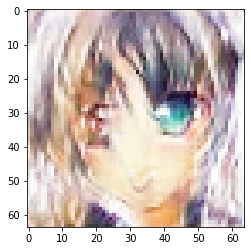

2501/12000: d_loss: 0.6687,  a_loss: 0.8017.
2502/12000: d_loss: 0.6740,  a_loss: 0.7988.
2503/12000: d_loss: 0.6643,  a_loss: 0.7813.
2504/12000: d_loss: 0.7316,  a_loss: 1.0775.
2505/12000: d_loss: 0.7033,  a_loss: 0.7805.
2506/12000: d_loss: 0.6740,  a_loss: 0.8211.
2507/12000: d_loss: 0.6369,  a_loss: 0.9023.
2508/12000: d_loss: 0.6722,  a_loss: 0.9002.
2509/12000: d_loss: 0.6742,  a_loss: 0.8939.
2510/12000: d_loss: 0.6790,  a_loss: 0.6544.
2511/12000: d_loss: 0.7314,  a_loss: 0.9110.
2512/12000: d_loss: 0.6757,  a_loss: 0.7578.
2513/12000: d_loss: 0.7286,  a_loss: 1.0623.
2514/12000: d_loss: 0.6804,  a_loss: 0.8807.
2515/12000: d_loss: 0.6926,  a_loss: 0.9651.
2516/12000: d_loss: 0.6532,  a_loss: 0.7951.
2517/12000: d_loss: 0.7359,  a_loss: 0.9643.
2518/12000: d_loss: 0.7220,  a_loss: 0.8818.
2519/12000: d_loss: 0.6759,  a_loss: 0.8305.
2520/12000: d_loss: 0.6458,  a_loss: 0.7968.
2521/12000: d_loss: 0.6816,  a_loss: 0.9510.
2522/12000: d_loss: 0.6863,  a_loss: 0.7991.
2523/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2600/12000: d_loss: 0.6938,  a_loss: 0.7702.


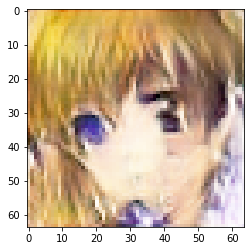

2601/12000: d_loss: 0.7035,  a_loss: 0.6828.
2602/12000: d_loss: 0.7360,  a_loss: 0.8952.
2603/12000: d_loss: 0.6901,  a_loss: 0.9096.
2604/12000: d_loss: 0.6605,  a_loss: 0.8409.
2605/12000: d_loss: 0.6572,  a_loss: 1.0000.
2606/12000: d_loss: 0.7138,  a_loss: 1.1651.
2607/12000: d_loss: 0.6707,  a_loss: 0.8125.
2608/12000: d_loss: 0.7183,  a_loss: 1.0308.
2609/12000: d_loss: 0.6676,  a_loss: 0.8544.
2610/12000: d_loss: 0.6748,  a_loss: 0.7866.
2611/12000: d_loss: 0.6655,  a_loss: 0.8305.
2612/12000: d_loss: 0.6539,  a_loss: 0.7454.
2613/12000: d_loss: 0.6453,  a_loss: 1.0476.
2614/12000: d_loss: 0.7043,  a_loss: 0.7702.
2615/12000: d_loss: 0.6453,  a_loss: 0.9360.
2616/12000: d_loss: 0.7267,  a_loss: 0.8136.
2617/12000: d_loss: 0.6887,  a_loss: 0.9419.
2618/12000: d_loss: 0.7042,  a_loss: 1.1882.
2619/12000: d_loss: 0.6350,  a_loss: 0.7910.
2620/12000: d_loss: 0.7425,  a_loss: 0.9617.
2621/12000: d_loss: 0.6769,  a_loss: 0.8748.
2622/12000: d_loss: 0.6789,  a_loss: 0.7837.
2623/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2700/12000: d_loss: 0.6720,  a_loss: 0.7995.


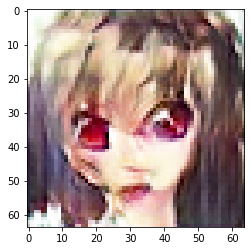

2701/12000: d_loss: 0.6675,  a_loss: 0.7970.
2702/12000: d_loss: 0.7741,  a_loss: 1.0067.
2703/12000: d_loss: 0.6662,  a_loss: 0.8178.
2704/12000: d_loss: 0.7364,  a_loss: 0.9091.
2705/12000: d_loss: 0.6673,  a_loss: 0.7684.
2706/12000: d_loss: 0.7012,  a_loss: 0.9141.
2707/12000: d_loss: 0.7390,  a_loss: 0.8165.
2708/12000: d_loss: 0.6718,  a_loss: 0.7665.
2709/12000: d_loss: 0.7487,  a_loss: 0.9431.
2710/12000: d_loss: 0.6820,  a_loss: 0.7660.
2711/12000: d_loss: 0.7010,  a_loss: 0.9272.
2712/12000: d_loss: 0.6764,  a_loss: 0.8474.
2713/12000: d_loss: 0.6675,  a_loss: 0.7577.
2714/12000: d_loss: 0.6691,  a_loss: 0.7942.
2715/12000: d_loss: 0.6922,  a_loss: 1.0140.
2716/12000: d_loss: 0.6528,  a_loss: 0.8299.
2717/12000: d_loss: 0.6566,  a_loss: 0.8381.
2718/12000: d_loss: 0.6821,  a_loss: 0.9923.
2719/12000: d_loss: 0.7065,  a_loss: 0.7699.
2720/12000: d_loss: 0.6770,  a_loss: 0.9077.
2721/12000: d_loss: 0.6717,  a_loss: 0.8173.
2722/12000: d_loss: 0.7113,  a_loss: 1.0434.
2723/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2800/12000: d_loss: 0.6697,  a_loss: 0.9564.


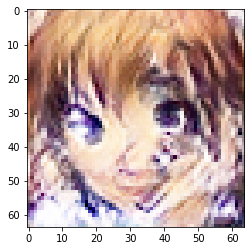

2801/12000: d_loss: 0.6587,  a_loss: 0.7836.
2802/12000: d_loss: 0.6302,  a_loss: 0.9235.
2803/12000: d_loss: 0.7259,  a_loss: 1.0287.
2804/12000: d_loss: 0.6942,  a_loss: 0.8163.
2805/12000: d_loss: 0.6378,  a_loss: 0.7414.
2806/12000: d_loss: 0.7203,  a_loss: 0.9726.
2807/12000: d_loss: 0.6662,  a_loss: 0.7383.
2808/12000: d_loss: 0.7984,  a_loss: 0.9553.
2809/12000: d_loss: 0.6865,  a_loss: 0.8360.
2810/12000: d_loss: 0.7087,  a_loss: 0.9522.
2811/12000: d_loss: 0.7262,  a_loss: 0.7878.
2812/12000: d_loss: 0.6750,  a_loss: 0.7380.
2813/12000: d_loss: 0.6897,  a_loss: 0.7344.
2814/12000: d_loss: 0.7049,  a_loss: 0.9149.
2815/12000: d_loss: 0.6810,  a_loss: 0.7817.
2816/12000: d_loss: 0.6634,  a_loss: 0.8141.
2817/12000: d_loss: 0.6762,  a_loss: 0.8602.
2818/12000: d_loss: 0.6683,  a_loss: 0.8657.
2819/12000: d_loss: 0.6296,  a_loss: 0.8258.
2820/12000: d_loss: 0.7845,  a_loss: 0.8116.
2821/12000: d_loss: 0.6977,  a_loss: 0.8469.
2822/12000: d_loss: 0.6871,  a_loss: 0.7857.
2823/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2900/12000: d_loss: 0.7009,  a_loss: 0.8005.


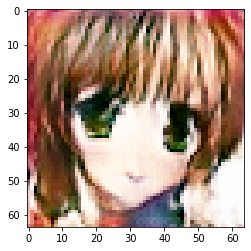

2901/12000: d_loss: 0.6958,  a_loss: 0.9139.
2902/12000: d_loss: 0.7194,  a_loss: 0.8510.
2903/12000: d_loss: 0.6706,  a_loss: 0.7862.
2904/12000: d_loss: 0.6861,  a_loss: 0.8415.
2905/12000: d_loss: 0.6967,  a_loss: 0.7909.
2906/12000: d_loss: 0.6972,  a_loss: 0.8193.
2907/12000: d_loss: 0.6551,  a_loss: 0.7085.
2908/12000: d_loss: 0.6515,  a_loss: 0.9929.
2909/12000: d_loss: 0.6944,  a_loss: 0.8021.
2910/12000: d_loss: 0.7013,  a_loss: 0.9283.
2911/12000: d_loss: 0.6874,  a_loss: 0.7461.
2912/12000: d_loss: 0.7083,  a_loss: 0.8752.
2913/12000: d_loss: 0.6718,  a_loss: 0.7313.
2914/12000: d_loss: 0.7088,  a_loss: 0.9273.
2915/12000: d_loss: 0.6834,  a_loss: 0.7991.
2916/12000: d_loss: 0.6729,  a_loss: 0.8394.
2917/12000: d_loss: 0.6890,  a_loss: 0.9446.
2918/12000: d_loss: 0.6449,  a_loss: 0.8428.
2919/12000: d_loss: 0.6628,  a_loss: 0.9614.
2920/12000: d_loss: 0.6791,  a_loss: 0.8629.
2921/12000: d_loss: 0.6682,  a_loss: 0.8269.
2922/12000: d_loss: 0.7264,  a_loss: 0.8848.
2923/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3000/12000: d_loss: 0.6692,  a_loss: 0.9005.


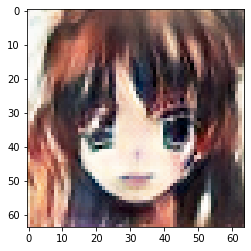

3001/12000: d_loss: 0.6852,  a_loss: 0.7718.
3002/12000: d_loss: 0.6636,  a_loss: 0.8784.
3003/12000: d_loss: 0.6851,  a_loss: 0.9224.
3004/12000: d_loss: 0.6787,  a_loss: 0.8357.
3005/12000: d_loss: 0.6927,  a_loss: 0.9340.
3006/12000: d_loss: 0.6949,  a_loss: 0.8514.
3007/12000: d_loss: 0.7110,  a_loss: 0.9285.
3008/12000: d_loss: 0.7098,  a_loss: 0.8082.
3009/12000: d_loss: 0.6829,  a_loss: 0.6939.
3010/12000: d_loss: 0.7450,  a_loss: 0.8952.
3011/12000: d_loss: 0.6510,  a_loss: 0.8539.
3012/12000: d_loss: 0.7164,  a_loss: 0.9194.
3013/12000: d_loss: 0.6903,  a_loss: 0.8018.
3014/12000: d_loss: 0.6716,  a_loss: 0.7759.
3015/12000: d_loss: 0.7097,  a_loss: 0.9450.
3016/12000: d_loss: 0.6781,  a_loss: 0.7544.
3017/12000: d_loss: 0.6975,  a_loss: 0.9041.
3018/12000: d_loss: 0.6813,  a_loss: 0.7897.
3019/12000: d_loss: 0.6817,  a_loss: 0.9274.
3020/12000: d_loss: 0.6919,  a_loss: 0.8143.
3021/12000: d_loss: 0.6859,  a_loss: 0.8477.
3022/12000: d_loss: 0.6636,  a_loss: 0.7892.
3023/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3100/12000: d_loss: 0.7106,  a_loss: 0.8093.


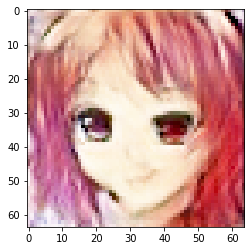

3101/12000: d_loss: 0.7030,  a_loss: 0.8476.
3102/12000: d_loss: 0.6742,  a_loss: 0.8038.
3103/12000: d_loss: 0.6808,  a_loss: 0.8326.
3104/12000: d_loss: 0.6957,  a_loss: 0.7935.
3105/12000: d_loss: 0.7006,  a_loss: 0.7809.
3106/12000: d_loss: 0.6850,  a_loss: 0.7501.
3107/12000: d_loss: 0.7169,  a_loss: 0.7862.
3108/12000: d_loss: 0.6869,  a_loss: 0.7701.
3109/12000: d_loss: 0.6747,  a_loss: 0.8421.
3110/12000: d_loss: 0.6794,  a_loss: 0.8046.
3111/12000: d_loss: 0.7196,  a_loss: 0.8934.
3112/12000: d_loss: 0.6895,  a_loss: 0.8094.
3113/12000: d_loss: 0.6708,  a_loss: 0.7833.
3114/12000: d_loss: 0.6812,  a_loss: 0.7741.
3115/12000: d_loss: 0.7101,  a_loss: 0.9788.
3116/12000: d_loss: 0.6791,  a_loss: 0.8300.
3117/12000: d_loss: 0.6559,  a_loss: 0.7596.
3118/12000: d_loss: 0.6833,  a_loss: 0.8569.
3119/12000: d_loss: 0.6988,  a_loss: 0.8207.
3120/12000: d_loss: 0.6949,  a_loss: 0.8251.
3121/12000: d_loss: 0.6534,  a_loss: 0.7551.
3122/12000: d_loss: 0.7010,  a_loss: 1.0582.
3123/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3200/12000: d_loss: 0.6536,  a_loss: 0.7703.


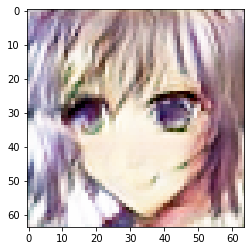

3201/12000: d_loss: 0.6674,  a_loss: 0.8728.
3202/12000: d_loss: 0.7196,  a_loss: 0.8792.
3203/12000: d_loss: 0.6937,  a_loss: 0.7538.
3204/12000: d_loss: 0.7044,  a_loss: 0.9464.
3205/12000: d_loss: 0.6859,  a_loss: 0.7568.
3206/12000: d_loss: 0.7028,  a_loss: 0.8593.
3207/12000: d_loss: 0.6865,  a_loss: 0.7591.
3208/12000: d_loss: 0.6916,  a_loss: 0.7758.
3209/12000: d_loss: 0.6818,  a_loss: 0.7679.
3210/12000: d_loss: 0.7049,  a_loss: 0.8049.
3211/12000: d_loss: 0.7133,  a_loss: 0.7689.
3212/12000: d_loss: 0.7018,  a_loss: 0.8405.
3213/12000: d_loss: 0.6744,  a_loss: 0.7855.
3214/12000: d_loss: 0.6835,  a_loss: 0.7880.
3215/12000: d_loss: 0.6952,  a_loss: 0.9321.
3216/12000: d_loss: 0.6978,  a_loss: 0.7876.
3217/12000: d_loss: 0.6888,  a_loss: 0.7875.
3218/12000: d_loss: 0.7154,  a_loss: 0.9065.
3219/12000: d_loss: 0.6940,  a_loss: 0.7503.
3220/12000: d_loss: 0.7174,  a_loss: 1.0484.
3221/12000: d_loss: 0.7272,  a_loss: 0.7781.
3222/12000: d_loss: 0.6838,  a_loss: 0.7599.
3223/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3300/12000: d_loss: 0.6891,  a_loss: 0.7637.


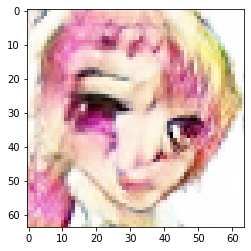

3301/12000: d_loss: 0.6938,  a_loss: 0.8544.
3302/12000: d_loss: 0.6956,  a_loss: 0.8178.
3303/12000: d_loss: 0.6744,  a_loss: 0.7754.
3304/12000: d_loss: 0.6952,  a_loss: 0.7471.
3305/12000: d_loss: 0.7036,  a_loss: 0.8753.
3306/12000: d_loss: 0.6892,  a_loss: 0.8714.
3307/12000: d_loss: 0.6906,  a_loss: 0.7932.
3308/12000: d_loss: 0.6791,  a_loss: 0.8013.
3309/12000: d_loss: 0.6771,  a_loss: 0.7794.
3310/12000: d_loss: 0.7034,  a_loss: 0.7709.
3311/12000: d_loss: 0.6910,  a_loss: 0.8175.
3312/12000: d_loss: 0.6765,  a_loss: 0.7728.
3313/12000: d_loss: 0.6997,  a_loss: 0.9772.
3314/12000: d_loss: 0.6862,  a_loss: 0.8000.
3315/12000: d_loss: 0.7145,  a_loss: 0.8176.
3316/12000: d_loss: 0.6870,  a_loss: 0.7272.
3317/12000: d_loss: 0.7107,  a_loss: 0.9246.
3318/12000: d_loss: 0.6921,  a_loss: 0.8467.
3319/12000: d_loss: 0.6747,  a_loss: 0.7696.
3320/12000: d_loss: 0.6518,  a_loss: 0.7555.
3321/12000: d_loss: 0.7049,  a_loss: 0.9271.
3322/12000: d_loss: 0.6997,  a_loss: 0.7846.
3323/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3400/12000: d_loss: 0.6891,  a_loss: 0.7917.


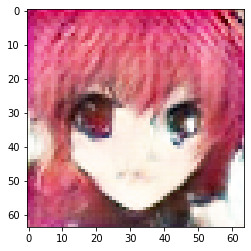

3401/12000: d_loss: 0.6921,  a_loss: 0.7516.
3402/12000: d_loss: 0.6940,  a_loss: 0.7963.
3403/12000: d_loss: 0.6860,  a_loss: 0.7801.
3404/12000: d_loss: 0.6825,  a_loss: 0.8037.
3405/12000: d_loss: 0.6579,  a_loss: 0.7711.
3406/12000: d_loss: 0.6998,  a_loss: 0.9184.
3407/12000: d_loss: 0.7176,  a_loss: 0.8793.
3408/12000: d_loss: 0.6899,  a_loss: 0.8054.
3409/12000: d_loss: 0.6788,  a_loss: 0.7423.
3410/12000: d_loss: 0.6813,  a_loss: 0.7952.
3411/12000: d_loss: 0.6957,  a_loss: 0.8582.
3412/12000: d_loss: 0.6785,  a_loss: 0.8020.
3413/12000: d_loss: 0.6709,  a_loss: 0.8449.
3414/12000: d_loss: 0.7313,  a_loss: 0.8674.
3415/12000: d_loss: 0.6605,  a_loss: 0.8145.
3416/12000: d_loss: 0.7051,  a_loss: 0.8717.
3417/12000: d_loss: 0.7165,  a_loss: 0.8743.
3418/12000: d_loss: 0.6773,  a_loss: 0.8398.
3419/12000: d_loss: 0.6942,  a_loss: 0.7960.
3420/12000: d_loss: 0.6935,  a_loss: 0.8087.
3421/12000: d_loss: 0.6799,  a_loss: 0.8185.
3422/12000: d_loss: 0.7032,  a_loss: 0.8804.
3423/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3500/12000: d_loss: 0.6868,  a_loss: 0.7886.


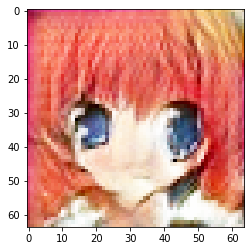

3501/12000: d_loss: 0.6900,  a_loss: 0.7980.
3502/12000: d_loss: 0.6924,  a_loss: 0.8039.
3503/12000: d_loss: 0.6647,  a_loss: 0.8758.
3504/12000: d_loss: 0.6640,  a_loss: 0.7937.
3505/12000: d_loss: 0.7274,  a_loss: 0.9141.
3506/12000: d_loss: 0.6721,  a_loss: 0.8496.
3507/12000: d_loss: 0.6763,  a_loss: 0.8187.
3508/12000: d_loss: 0.7435,  a_loss: 0.9358.
3509/12000: d_loss: 0.7033,  a_loss: 0.8446.
3510/12000: d_loss: 0.7276,  a_loss: 0.7792.
3511/12000: d_loss: 0.7202,  a_loss: 0.7616.
3512/12000: d_loss: 0.7052,  a_loss: 0.7996.
3513/12000: d_loss: 0.6872,  a_loss: 0.7961.
3514/12000: d_loss: 0.6900,  a_loss: 0.8246.
3515/12000: d_loss: 0.6833,  a_loss: 0.8080.
3516/12000: d_loss: 0.6706,  a_loss: 0.7904.
3517/12000: d_loss: 0.7114,  a_loss: 0.8239.
3518/12000: d_loss: 0.6758,  a_loss: 0.7597.
3519/12000: d_loss: 0.6996,  a_loss: 0.8068.
3520/12000: d_loss: 0.7141,  a_loss: 0.8414.
3521/12000: d_loss: 0.7006,  a_loss: 0.7760.
3522/12000: d_loss: 0.6912,  a_loss: 0.8014.
3523/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3600/12000: d_loss: 0.6831,  a_loss: 0.7143.


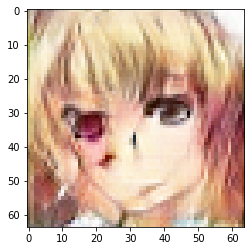

3601/12000: d_loss: 0.7073,  a_loss: 0.8282.
3602/12000: d_loss: 0.7017,  a_loss: 0.7853.
3603/12000: d_loss: 0.6943,  a_loss: 0.7421.
3604/12000: d_loss: 0.6904,  a_loss: 0.8159.
3605/12000: d_loss: 0.6818,  a_loss: 0.7727.
3606/12000: d_loss: 0.6612,  a_loss: 0.7897.
3607/12000: d_loss: 0.7276,  a_loss: 0.8951.
3608/12000: d_loss: 0.6955,  a_loss: 0.8193.
3609/12000: d_loss: 0.6968,  a_loss: 0.8167.
3610/12000: d_loss: 0.6785,  a_loss: 0.8083.
3611/12000: d_loss: 0.6817,  a_loss: 0.8028.
3612/12000: d_loss: 0.6889,  a_loss: 0.8103.
3613/12000: d_loss: 0.6794,  a_loss: 0.8064.
3614/12000: d_loss: 0.7224,  a_loss: 0.7817.
3615/12000: d_loss: 0.7117,  a_loss: 0.8268.
3616/12000: d_loss: 0.6906,  a_loss: 0.7639.
3617/12000: d_loss: 0.6882,  a_loss: 0.8219.
3618/12000: d_loss: 0.6789,  a_loss: 0.7673.
3619/12000: d_loss: 0.6813,  a_loss: 0.9264.
3620/12000: d_loss: 0.6890,  a_loss: 0.6897.
3621/12000: d_loss: 0.7375,  a_loss: 0.9269.
3622/12000: d_loss: 0.6775,  a_loss: 0.7972.
3623/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3700/12000: d_loss: 0.6981,  a_loss: 0.7695.


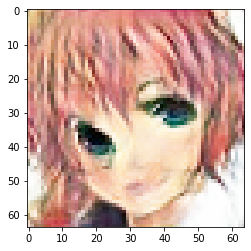

3701/12000: d_loss: 0.6974,  a_loss: 0.7617.
3702/12000: d_loss: 0.6879,  a_loss: 0.7663.
3703/12000: d_loss: 0.6910,  a_loss: 0.7481.
3704/12000: d_loss: 0.6992,  a_loss: 0.8150.
3705/12000: d_loss: 0.6925,  a_loss: 0.8006.
3706/12000: d_loss: 0.6890,  a_loss: 0.8066.
3707/12000: d_loss: 0.6883,  a_loss: 0.7391.
3708/12000: d_loss: 0.7065,  a_loss: 0.8544.
3709/12000: d_loss: 0.6888,  a_loss: 0.7855.
3710/12000: d_loss: 0.6878,  a_loss: 0.7929.
3711/12000: d_loss: 0.7252,  a_loss: 0.8580.
3712/12000: d_loss: 0.6972,  a_loss: 0.7756.
3713/12000: d_loss: 0.7213,  a_loss: 0.8048.
3714/12000: d_loss: 0.7015,  a_loss: 0.8237.
3715/12000: d_loss: 0.7324,  a_loss: 0.8472.
3716/12000: d_loss: 0.6978,  a_loss: 0.7596.
3717/12000: d_loss: 0.7019,  a_loss: 0.8661.
3718/12000: d_loss: 0.6764,  a_loss: 0.8117.
3719/12000: d_loss: 0.7298,  a_loss: 0.7903.
3720/12000: d_loss: 0.6898,  a_loss: 0.7096.
3721/12000: d_loss: 0.6793,  a_loss: 0.8504.
3722/12000: d_loss: 0.6966,  a_loss: 0.8319.
3723/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3800/12000: d_loss: 0.6849,  a_loss: 0.7562.


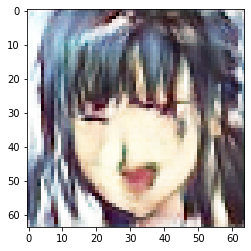

3801/12000: d_loss: 0.7042,  a_loss: 0.9093.
3802/12000: d_loss: 0.6940,  a_loss: 0.7840.
3803/12000: d_loss: 0.6993,  a_loss: 0.7486.
3804/12000: d_loss: 0.7173,  a_loss: 0.8246.
3805/12000: d_loss: 0.6821,  a_loss: 0.8088.
3806/12000: d_loss: 0.6925,  a_loss: 0.8163.
3807/12000: d_loss: 0.7112,  a_loss: 0.7860.
3808/12000: d_loss: 0.6747,  a_loss: 0.8027.
3809/12000: d_loss: 0.6714,  a_loss: 0.7647.
3810/12000: d_loss: 0.7046,  a_loss: 0.9131.
3811/12000: d_loss: 0.6904,  a_loss: 0.7808.
3812/12000: d_loss: 0.6786,  a_loss: 0.7425.
3813/12000: d_loss: 0.6805,  a_loss: 0.8136.
3814/12000: d_loss: 0.7046,  a_loss: 0.7937.
3815/12000: d_loss: 0.6834,  a_loss: 0.7778.
3816/12000: d_loss: 0.6952,  a_loss: 0.9589.
3817/12000: d_loss: 0.7159,  a_loss: 0.7978.
3818/12000: d_loss: 0.6867,  a_loss: 0.7876.
3819/12000: d_loss: 0.6839,  a_loss: 0.7593.
3820/12000: d_loss: 0.6966,  a_loss: 0.7339.
3821/12000: d_loss: 0.6888,  a_loss: 0.8734.
3822/12000: d_loss: 0.6805,  a_loss: 0.8176.
3823/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3900/12000: d_loss: 0.6665,  a_loss: 0.7803.


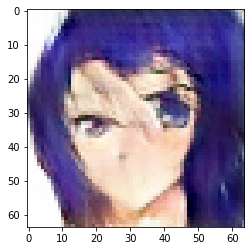

3901/12000: d_loss: 0.6947,  a_loss: 0.7857.
3902/12000: d_loss: 0.7255,  a_loss: 0.7874.
3903/12000: d_loss: 0.7037,  a_loss: 0.8366.
3904/12000: d_loss: 0.7028,  a_loss: 0.8688.
3905/12000: d_loss: 0.6777,  a_loss: 0.8355.
3906/12000: d_loss: 0.6857,  a_loss: 0.7807.
3907/12000: d_loss: 0.6905,  a_loss: 0.7812.
3908/12000: d_loss: 0.6903,  a_loss: 0.8313.
3909/12000: d_loss: 0.6753,  a_loss: 0.7498.
3910/12000: d_loss: 0.6999,  a_loss: 0.8109.
3911/12000: d_loss: 0.6870,  a_loss: 0.7462.
3912/12000: d_loss: 0.6819,  a_loss: 0.8580.
3913/12000: d_loss: 0.6894,  a_loss: 0.8507.
3914/12000: d_loss: 0.7008,  a_loss: 0.7174.
3915/12000: d_loss: 0.6847,  a_loss: 0.8000.
3916/12000: d_loss: 0.6731,  a_loss: 0.7241.
3917/12000: d_loss: 0.7081,  a_loss: 1.0219.
3918/12000: d_loss: 0.7085,  a_loss: 0.7797.
3919/12000: d_loss: 0.6876,  a_loss: 0.8311.
3920/12000: d_loss: 0.6863,  a_loss: 0.7763.
3921/12000: d_loss: 0.7037,  a_loss: 0.7941.
3922/12000: d_loss: 0.7001,  a_loss: 0.7832.
3923/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4000/12000: d_loss: 0.6804,  a_loss: 0.7487.


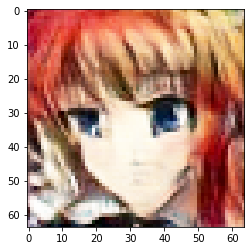

4001/12000: d_loss: 0.6928,  a_loss: 0.8327.
4002/12000: d_loss: 0.6953,  a_loss: 0.7961.
4003/12000: d_loss: 0.6818,  a_loss: 0.7533.
4004/12000: d_loss: 0.6904,  a_loss: 0.8454.
4005/12000: d_loss: 0.6893,  a_loss: 0.8196.
4006/12000: d_loss: 0.6921,  a_loss: 0.7869.
4007/12000: d_loss: 0.7089,  a_loss: 0.8106.
4008/12000: d_loss: 0.6898,  a_loss: 0.8002.
4009/12000: d_loss: 0.7009,  a_loss: 0.7616.
4010/12000: d_loss: 0.6838,  a_loss: 0.7790.
4011/12000: d_loss: 0.6862,  a_loss: 0.8358.
4012/12000: d_loss: 0.6796,  a_loss: 0.8118.
4013/12000: d_loss: 0.7175,  a_loss: 0.9158.
4014/12000: d_loss: 0.6953,  a_loss: 0.8435.
4015/12000: d_loss: 0.6916,  a_loss: 0.7695.
4016/12000: d_loss: 0.6904,  a_loss: 0.7314.
4017/12000: d_loss: 0.6946,  a_loss: 0.7721.
4018/12000: d_loss: 0.6908,  a_loss: 0.8061.
4019/12000: d_loss: 0.6842,  a_loss: 0.8015.
4020/12000: d_loss: 0.6934,  a_loss: 0.7420.
4021/12000: d_loss: 0.6966,  a_loss: 0.7602.
4022/12000: d_loss: 0.7018,  a_loss: 0.8061.
4023/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4100/12000: d_loss: 0.6835,  a_loss: 0.8396.


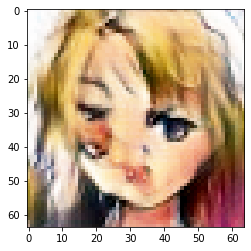

4101/12000: d_loss: 0.7003,  a_loss: 0.7449.
4102/12000: d_loss: 0.8055,  a_loss: 0.9904.
4103/12000: d_loss: 0.7001,  a_loss: 0.7568.
4104/12000: d_loss: 0.7117,  a_loss: 0.7705.
4105/12000: d_loss: 0.7308,  a_loss: 0.8882.
4106/12000: d_loss: 0.6975,  a_loss: 0.7908.
4107/12000: d_loss: 0.6911,  a_loss: 0.7827.
4108/12000: d_loss: 0.6839,  a_loss: 0.7668.
4109/12000: d_loss: 0.6802,  a_loss: 0.8074.
4110/12000: d_loss: 0.6899,  a_loss: 0.8066.
4111/12000: d_loss: 0.7164,  a_loss: 0.7899.
4112/12000: d_loss: 0.6800,  a_loss: 0.7902.
4113/12000: d_loss: 0.6754,  a_loss: 0.7834.
4114/12000: d_loss: 0.6897,  a_loss: 0.7960.
4115/12000: d_loss: 0.6951,  a_loss: 0.8447.
4116/12000: d_loss: 0.6708,  a_loss: 0.8041.
4117/12000: d_loss: 0.6876,  a_loss: 0.8536.
4118/12000: d_loss: 0.6917,  a_loss: 0.7067.
4119/12000: d_loss: 0.6844,  a_loss: 0.7881.
4120/12000: d_loss: 0.7032,  a_loss: 0.8342.
4121/12000: d_loss: 0.6947,  a_loss: 0.8132.
4122/12000: d_loss: 0.6986,  a_loss: 0.7513.
4123/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4200/12000: d_loss: 0.7019,  a_loss: 0.7998.


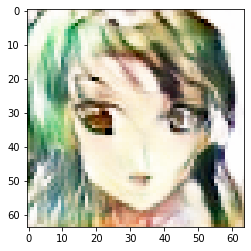

4201/12000: d_loss: 0.6902,  a_loss: 0.7822.
4202/12000: d_loss: 0.6867,  a_loss: 0.7540.
4203/12000: d_loss: 0.6932,  a_loss: 0.8255.
4204/12000: d_loss: 0.6776,  a_loss: 0.7804.
4205/12000: d_loss: 0.7182,  a_loss: 0.8798.
4206/12000: d_loss: 0.6889,  a_loss: 0.7826.
4207/12000: d_loss: 0.6902,  a_loss: 0.7599.
4208/12000: d_loss: 0.6816,  a_loss: 0.7690.
4209/12000: d_loss: 0.7242,  a_loss: 0.8689.
4210/12000: d_loss: 0.6788,  a_loss: 0.7420.
4211/12000: d_loss: 0.6967,  a_loss: 0.8444.
4212/12000: d_loss: 0.6842,  a_loss: 0.8151.
4213/12000: d_loss: 0.6861,  a_loss: 0.7868.
4214/12000: d_loss: 0.7061,  a_loss: 0.8219.
4215/12000: d_loss: 0.6878,  a_loss: 0.7573.
4216/12000: d_loss: 0.7182,  a_loss: 0.7831.
4217/12000: d_loss: 0.7152,  a_loss: 0.7914.
4218/12000: d_loss: 0.6915,  a_loss: 0.7931.
4219/12000: d_loss: 0.6789,  a_loss: 0.7897.
4220/12000: d_loss: 0.7050,  a_loss: 0.8023.
4221/12000: d_loss: 0.6992,  a_loss: 0.7589.
4222/12000: d_loss: 0.7331,  a_loss: 0.8708.
4223/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4300/12000: d_loss: 0.6970,  a_loss: 0.7691.


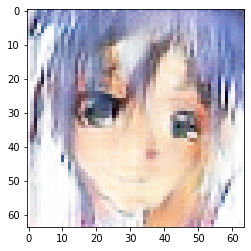

4301/12000: d_loss: 0.7100,  a_loss: 0.7656.
4302/12000: d_loss: 0.6920,  a_loss: 0.7765.
4303/12000: d_loss: 0.6977,  a_loss: 0.7928.
4304/12000: d_loss: 0.6876,  a_loss: 0.7502.
4305/12000: d_loss: 0.7007,  a_loss: 0.7643.
4306/12000: d_loss: 0.6858,  a_loss: 0.7225.
4307/12000: d_loss: 0.7021,  a_loss: 0.8228.
4308/12000: d_loss: 0.6910,  a_loss: 0.8573.
4309/12000: d_loss: 0.6936,  a_loss: 0.7823.
4310/12000: d_loss: 0.6877,  a_loss: 0.8092.
4311/12000: d_loss: 0.6686,  a_loss: 0.6917.
4312/12000: d_loss: 0.6932,  a_loss: 0.8669.
4313/12000: d_loss: 0.7028,  a_loss: 0.7876.
4314/12000: d_loss: 0.7064,  a_loss: 0.8243.
4315/12000: d_loss: 0.6793,  a_loss: 0.7692.
4316/12000: d_loss: 0.6799,  a_loss: 0.7668.
4317/12000: d_loss: 0.6925,  a_loss: 0.8005.
4318/12000: d_loss: 0.6785,  a_loss: 0.7310.
4319/12000: d_loss: 0.6907,  a_loss: 0.7076.
4320/12000: d_loss: 0.7013,  a_loss: 0.8523.
4321/12000: d_loss: 0.6823,  a_loss: 0.7860.
4322/12000: d_loss: 0.6905,  a_loss: 0.8257.
4323/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4400/12000: d_loss: 0.7140,  a_loss: 0.8594.


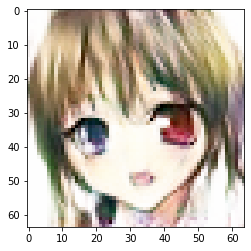

4401/12000: d_loss: 0.6979,  a_loss: 0.8123.
4402/12000: d_loss: 0.6927,  a_loss: 0.7867.
4403/12000: d_loss: 0.6820,  a_loss: 0.7250.
4404/12000: d_loss: 0.6920,  a_loss: 0.7152.
4405/12000: d_loss: 0.6924,  a_loss: 0.7820.
4406/12000: d_loss: 0.6933,  a_loss: 0.7780.
4407/12000: d_loss: 0.6979,  a_loss: 0.8102.
4408/12000: d_loss: 0.6920,  a_loss: 0.7679.
4409/12000: d_loss: 0.6822,  a_loss: 0.7392.
4410/12000: d_loss: 0.7037,  a_loss: 0.7644.
4411/12000: d_loss: 0.6937,  a_loss: 0.7708.
4412/12000: d_loss: 0.7026,  a_loss: 0.7700.
4413/12000: d_loss: 0.6761,  a_loss: 0.7729.
4414/12000: d_loss: 0.6879,  a_loss: 0.7990.
4415/12000: d_loss: 0.6754,  a_loss: 0.7771.
4416/12000: d_loss: 0.6907,  a_loss: 0.8802.
4417/12000: d_loss: 0.7350,  a_loss: 0.8776.
4418/12000: d_loss: 0.6796,  a_loss: 0.8023.
4419/12000: d_loss: 0.6721,  a_loss: 0.7931.
4420/12000: d_loss: 0.6710,  a_loss: 0.7487.
4421/12000: d_loss: 0.7084,  a_loss: 0.8693.
4422/12000: d_loss: 0.6720,  a_loss: 0.7915.
4423/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4500/12000: d_loss: 0.6797,  a_loss: 0.7851.


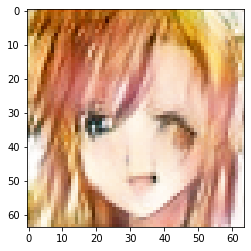

4501/12000: d_loss: 0.6816,  a_loss: 0.7575.
4502/12000: d_loss: 0.6991,  a_loss: 0.8162.
4503/12000: d_loss: 0.7061,  a_loss: 0.7791.
4504/12000: d_loss: 0.7044,  a_loss: 0.7889.
4505/12000: d_loss: 0.7057,  a_loss: 0.7859.
4506/12000: d_loss: 0.7100,  a_loss: 0.8161.
4507/12000: d_loss: 0.7021,  a_loss: 0.8129.
4508/12000: d_loss: 0.6738,  a_loss: 0.7338.
4509/12000: d_loss: 0.6917,  a_loss: 0.8314.
4510/12000: d_loss: 0.6744,  a_loss: 0.8162.
4511/12000: d_loss: 0.7109,  a_loss: 0.8590.
4512/12000: d_loss: 0.6775,  a_loss: 0.7436.
4513/12000: d_loss: 0.6977,  a_loss: 0.8464.
4514/12000: d_loss: 0.6860,  a_loss: 0.8041.
4515/12000: d_loss: 0.6864,  a_loss: 0.8460.
4516/12000: d_loss: 0.6863,  a_loss: 0.7741.
4517/12000: d_loss: 0.6901,  a_loss: 0.8098.
4518/12000: d_loss: 0.6926,  a_loss: 0.7943.
4519/12000: d_loss: 0.6947,  a_loss: 0.8474.
4520/12000: d_loss: 0.6858,  a_loss: 0.8135.
4521/12000: d_loss: 0.6978,  a_loss: 0.7804.
4522/12000: d_loss: 0.7099,  a_loss: 0.8598.
4523/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4600/12000: d_loss: 0.7023,  a_loss: 0.7403.


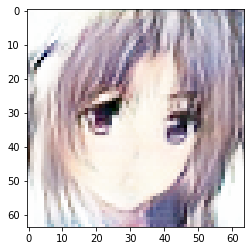

4601/12000: d_loss: 0.6936,  a_loss: 0.7867.
4602/12000: d_loss: 0.7152,  a_loss: 0.8014.
4603/12000: d_loss: 0.7189,  a_loss: 0.7148.
4604/12000: d_loss: 0.6891,  a_loss: 0.7441.
4605/12000: d_loss: 0.6732,  a_loss: 0.7406.
4606/12000: d_loss: 0.7218,  a_loss: 0.8443.
4607/12000: d_loss: 0.6980,  a_loss: 0.7408.
4608/12000: d_loss: 0.6927,  a_loss: 0.7705.
4609/12000: d_loss: 0.6880,  a_loss: 0.7412.
4610/12000: d_loss: 0.6802,  a_loss: 0.7739.
4611/12000: d_loss: 0.6889,  a_loss: 0.8130.
4612/12000: d_loss: 0.6995,  a_loss: 0.7608.
4613/12000: d_loss: 0.7011,  a_loss: 0.8062.
4614/12000: d_loss: 0.6896,  a_loss: 0.7443.
4615/12000: d_loss: 0.6743,  a_loss: 0.7187.
4616/12000: d_loss: 0.6958,  a_loss: 0.8475.
4617/12000: d_loss: 0.6999,  a_loss: 0.8887.
4618/12000: d_loss: 0.6884,  a_loss: 0.8136.
4619/12000: d_loss: 0.6742,  a_loss: 0.7738.
4620/12000: d_loss: 0.6728,  a_loss: 0.8268.
4621/12000: d_loss: 0.6885,  a_loss: 0.7462.
4622/12000: d_loss: 0.7013,  a_loss: 0.7693.
4623/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4700/12000: d_loss: 0.7017,  a_loss: 0.7834.


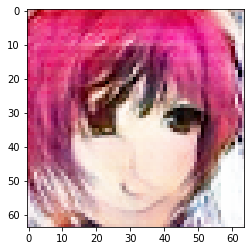

4701/12000: d_loss: 0.6822,  a_loss: 0.7981.
4702/12000: d_loss: 0.6873,  a_loss: 0.7567.
4703/12000: d_loss: 0.6880,  a_loss: 0.8784.
4704/12000: d_loss: 0.6918,  a_loss: 0.7641.
4705/12000: d_loss: 0.6973,  a_loss: 0.7988.
4706/12000: d_loss: 0.6841,  a_loss: 0.8177.
4707/12000: d_loss: 0.6983,  a_loss: 0.7307.
4708/12000: d_loss: 0.7247,  a_loss: 0.8606.
4709/12000: d_loss: 0.6840,  a_loss: 0.8229.
4710/12000: d_loss: 0.6778,  a_loss: 0.7979.
4711/12000: d_loss: 0.6862,  a_loss: 0.7636.
4712/12000: d_loss: 0.6957,  a_loss: 0.8377.
4713/12000: d_loss: 0.6788,  a_loss: 0.8214.
4714/12000: d_loss: 0.6908,  a_loss: 0.7864.
4715/12000: d_loss: 0.7029,  a_loss: 0.8250.
4716/12000: d_loss: 0.6993,  a_loss: 0.7248.
4717/12000: d_loss: 0.6916,  a_loss: 0.7864.
4718/12000: d_loss: 0.6888,  a_loss: 0.7818.
4719/12000: d_loss: 0.6856,  a_loss: 0.7446.
4720/12000: d_loss: 0.6863,  a_loss: 0.7924.
4721/12000: d_loss: 0.6738,  a_loss: 0.7211.
4722/12000: d_loss: 0.6813,  a_loss: 0.7787.
4723/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4800/12000: d_loss: 0.6837,  a_loss: 0.7228.


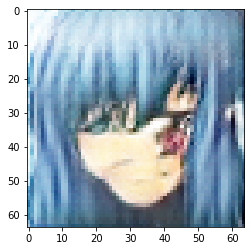

4801/12000: d_loss: 0.7153,  a_loss: 0.8516.
4802/12000: d_loss: 0.7055,  a_loss: 0.7905.
4803/12000: d_loss: 0.6983,  a_loss: 0.8046.
4804/12000: d_loss: 0.6931,  a_loss: 0.7848.
4805/12000: d_loss: 0.7000,  a_loss: 0.7681.
4806/12000: d_loss: 0.6916,  a_loss: 0.7423.
4807/12000: d_loss: 0.6912,  a_loss: 0.7817.
4808/12000: d_loss: 0.6752,  a_loss: 0.7472.
4809/12000: d_loss: 0.6973,  a_loss: 0.8502.
4810/12000: d_loss: 0.6903,  a_loss: 0.8579.
4811/12000: d_loss: 0.6999,  a_loss: 0.7954.
4812/12000: d_loss: 0.6991,  a_loss: 0.7861.
4813/12000: d_loss: 0.6940,  a_loss: 0.7492.
4814/12000: d_loss: 0.6995,  a_loss: 0.8626.
4815/12000: d_loss: 0.6998,  a_loss: 0.8076.
4816/12000: d_loss: 0.6857,  a_loss: 0.7792.
4817/12000: d_loss: 0.6874,  a_loss: 0.8114.
4818/12000: d_loss: 0.6980,  a_loss: 0.7549.
4819/12000: d_loss: 0.6841,  a_loss: 0.7589.
4820/12000: d_loss: 0.6928,  a_loss: 0.7959.
4821/12000: d_loss: 0.6913,  a_loss: 0.7818.
4822/12000: d_loss: 0.6963,  a_loss: 0.7945.
4823/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4900/12000: d_loss: 0.6908,  a_loss: 0.8139.


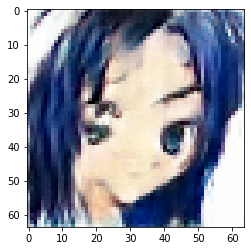

4901/12000: d_loss: 0.6938,  a_loss: 0.7975.
4902/12000: d_loss: 0.6927,  a_loss: 0.7396.
4903/12000: d_loss: 0.6892,  a_loss: 0.7785.
4904/12000: d_loss: 0.7076,  a_loss: 0.7814.
4905/12000: d_loss: 0.6814,  a_loss: 0.7342.
4906/12000: d_loss: 0.6731,  a_loss: 0.7718.
4907/12000: d_loss: 0.7231,  a_loss: 0.8479.
4908/12000: d_loss: 0.7049,  a_loss: 0.7931.
4909/12000: d_loss: 0.6963,  a_loss: 0.7432.
4910/12000: d_loss: 0.6840,  a_loss: 0.7379.
4911/12000: d_loss: 0.6891,  a_loss: 0.7710.
4912/12000: d_loss: 0.7005,  a_loss: 0.7688.
4913/12000: d_loss: 0.6992,  a_loss: 0.7708.
4914/12000: d_loss: 0.6912,  a_loss: 0.7833.
4915/12000: d_loss: 0.6862,  a_loss: 0.7260.
4916/12000: d_loss: 0.6792,  a_loss: 0.8102.
4917/12000: d_loss: 0.7106,  a_loss: 0.8014.
4918/12000: d_loss: 0.6848,  a_loss: 0.7725.
4919/12000: d_loss: 0.6841,  a_loss: 0.7182.
4920/12000: d_loss: 0.7098,  a_loss: 0.8921.
4921/12000: d_loss: 0.6921,  a_loss: 0.7990.
4922/12000: d_loss: 0.6930,  a_loss: 0.7777.
4923/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5000/12000: d_loss: 0.7090,  a_loss: 0.7879.


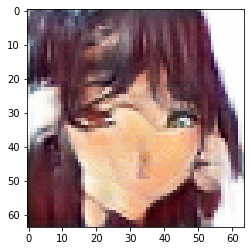

5001/12000: d_loss: 0.6810,  a_loss: 0.7758.
5002/12000: d_loss: 0.6808,  a_loss: 0.7530.
5003/12000: d_loss: 0.6864,  a_loss: 0.7607.
5004/12000: d_loss: 0.6956,  a_loss: 0.8241.
5005/12000: d_loss: 0.6829,  a_loss: 0.7692.
5006/12000: d_loss: 0.7257,  a_loss: 0.7833.
5007/12000: d_loss: 0.6822,  a_loss: 0.7573.
5008/12000: d_loss: 0.6903,  a_loss: 0.7799.
5009/12000: d_loss: 0.6957,  a_loss: 0.8446.
5010/12000: d_loss: 0.6955,  a_loss: 0.7720.
5011/12000: d_loss: 0.6918,  a_loss: 0.8098.
5012/12000: d_loss: 0.6869,  a_loss: 0.8064.
5013/12000: d_loss: 0.6827,  a_loss: 0.7829.
5014/12000: d_loss: 0.7045,  a_loss: 0.7355.
5015/12000: d_loss: 0.6910,  a_loss: 0.7536.
5016/12000: d_loss: 0.6731,  a_loss: 0.7047.
5017/12000: d_loss: 0.7031,  a_loss: 0.8852.
5018/12000: d_loss: 0.6879,  a_loss: 0.7906.
5019/12000: d_loss: 0.6909,  a_loss: 0.7478.
5020/12000: d_loss: 0.7004,  a_loss: 0.7271.
5021/12000: d_loss: 0.7049,  a_loss: 0.7613.
5022/12000: d_loss: 0.7027,  a_loss: 0.8185.
5023/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5100/12000: d_loss: 0.7010,  a_loss: 0.7557.


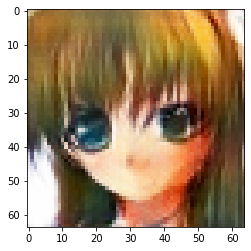

5101/12000: d_loss: 0.6846,  a_loss: 0.7801.
5102/12000: d_loss: 0.6898,  a_loss: 0.7741.
5103/12000: d_loss: 0.6872,  a_loss: 0.6983.
5104/12000: d_loss: 0.7187,  a_loss: 0.9261.
5105/12000: d_loss: 0.6888,  a_loss: 0.8049.
5106/12000: d_loss: 0.6986,  a_loss: 0.8303.
5107/12000: d_loss: 0.6872,  a_loss: 0.7725.
5108/12000: d_loss: 0.6956,  a_loss: 0.7164.
5109/12000: d_loss: 0.6784,  a_loss: 0.7557.
5110/12000: d_loss: 0.6868,  a_loss: 0.7584.
5111/12000: d_loss: 0.6942,  a_loss: 0.7577.
5112/12000: d_loss: 0.6952,  a_loss: 0.7640.
5113/12000: d_loss: 0.6865,  a_loss: 0.8272.
5114/12000: d_loss: 0.6968,  a_loss: 0.8461.
5115/12000: d_loss: 0.6881,  a_loss: 0.7881.
5116/12000: d_loss: 0.6945,  a_loss: 0.8276.
5117/12000: d_loss: 0.6830,  a_loss: 0.7918.
5118/12000: d_loss: 0.6938,  a_loss: 0.7779.
5119/12000: d_loss: 0.6886,  a_loss: 0.7625.
5120/12000: d_loss: 0.7036,  a_loss: 0.8072.
5121/12000: d_loss: 0.6734,  a_loss: 0.7300.
5122/12000: d_loss: 0.7256,  a_loss: 0.8130.
5123/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5200/12000: d_loss: 0.6931,  a_loss: 0.8092.


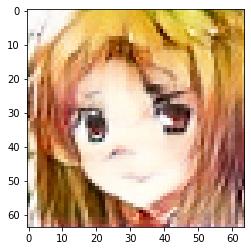

5201/12000: d_loss: 0.6872,  a_loss: 0.7343.
5202/12000: d_loss: 0.6981,  a_loss: 0.7466.
5203/12000: d_loss: 0.6967,  a_loss: 0.7833.
5204/12000: d_loss: 0.6767,  a_loss: 0.7539.
5205/12000: d_loss: 0.6820,  a_loss: 0.7385.
5206/12000: d_loss: 0.7194,  a_loss: 0.8907.
5207/12000: d_loss: 0.6889,  a_loss: 0.7558.
5208/12000: d_loss: 0.6709,  a_loss: 0.8227.
5209/12000: d_loss: 0.6915,  a_loss: 0.6983.
5210/12000: d_loss: 0.7405,  a_loss: 0.8774.
5211/12000: d_loss: 0.6965,  a_loss: 0.8340.
5212/12000: d_loss: 0.6801,  a_loss: 0.8029.
5213/12000: d_loss: 0.6866,  a_loss: 0.7822.
5214/12000: d_loss: 0.7011,  a_loss: 0.7600.
5215/12000: d_loss: 0.6908,  a_loss: 0.7854.
5216/12000: d_loss: 0.6848,  a_loss: 0.7614.
5217/12000: d_loss: 0.6923,  a_loss: 0.7743.
5218/12000: d_loss: 0.6913,  a_loss: 0.7025.
5219/12000: d_loss: 0.6936,  a_loss: 0.8291.
5220/12000: d_loss: 0.6893,  a_loss: 0.7963.
5221/12000: d_loss: 0.6923,  a_loss: 0.8693.
5222/12000: d_loss: 0.7019,  a_loss: 0.7928.
5223/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5300/12000: d_loss: 0.6889,  a_loss: 0.7651.


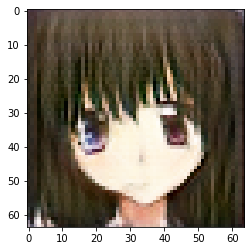

5301/12000: d_loss: 0.6899,  a_loss: 0.8834.
5302/12000: d_loss: 0.6916,  a_loss: 0.7120.
5303/12000: d_loss: 0.6959,  a_loss: 0.8092.
5304/12000: d_loss: 0.6924,  a_loss: 0.8069.
5305/12000: d_loss: 0.7010,  a_loss: 0.7980.
5306/12000: d_loss: 0.6940,  a_loss: 0.7661.
5307/12000: d_loss: 0.7218,  a_loss: 0.8100.
5308/12000: d_loss: 0.6940,  a_loss: 0.7611.
5309/12000: d_loss: 0.6836,  a_loss: 0.7187.
5310/12000: d_loss: 0.6903,  a_loss: 0.7837.
5311/12000: d_loss: 0.6866,  a_loss: 0.8098.
5312/12000: d_loss: 0.6896,  a_loss: 0.7475.
5313/12000: d_loss: 0.6995,  a_loss: 0.7520.
5314/12000: d_loss: 0.7057,  a_loss: 0.7696.
5315/12000: d_loss: 0.7026,  a_loss: 0.8035.
5316/12000: d_loss: 0.6892,  a_loss: 0.7819.
5317/12000: d_loss: 0.6870,  a_loss: 0.7929.
5318/12000: d_loss: 0.6913,  a_loss: 0.7243.
5319/12000: d_loss: 0.7055,  a_loss: 0.8531.
5320/12000: d_loss: 0.6870,  a_loss: 0.7110.
5321/12000: d_loss: 0.6892,  a_loss: 0.8245.
5322/12000: d_loss: 0.7238,  a_loss: 0.9043.
5323/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5400/12000: d_loss: 0.6962,  a_loss: 0.7818.


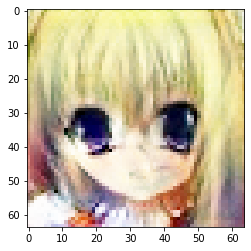

5401/12000: d_loss: 0.6926,  a_loss: 0.7586.
5402/12000: d_loss: 0.6994,  a_loss: 0.8156.
5403/12000: d_loss: 0.6910,  a_loss: 0.7803.
5404/12000: d_loss: 0.6998,  a_loss: 0.7486.
5405/12000: d_loss: 0.6876,  a_loss: 0.6694.
5406/12000: d_loss: 0.7396,  a_loss: 0.8317.
5407/12000: d_loss: 0.6866,  a_loss: 0.7962.
5408/12000: d_loss: 0.6915,  a_loss: 0.7591.
5409/12000: d_loss: 0.6924,  a_loss: 0.8045.
5410/12000: d_loss: 0.6848,  a_loss: 0.7585.
5411/12000: d_loss: 0.6951,  a_loss: 0.7403.
5412/12000: d_loss: 0.7010,  a_loss: 0.8005.
5413/12000: d_loss: 0.6983,  a_loss: 0.7365.
5414/12000: d_loss: 0.7033,  a_loss: 0.8025.
5415/12000: d_loss: 0.6915,  a_loss: 0.7922.
5416/12000: d_loss: 0.6843,  a_loss: 0.7890.
5417/12000: d_loss: 0.6989,  a_loss: 0.7425.
5418/12000: d_loss: 0.7070,  a_loss: 0.7983.
5419/12000: d_loss: 0.6854,  a_loss: 0.7636.
5420/12000: d_loss: 0.7019,  a_loss: 0.7954.
5421/12000: d_loss: 0.6844,  a_loss: 0.8086.
5422/12000: d_loss: 0.6805,  a_loss: 0.7326.
5423/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5500/12000: d_loss: 0.6960,  a_loss: 0.7545.


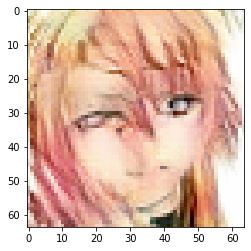

5501/12000: d_loss: 0.7056,  a_loss: 0.8297.
5502/12000: d_loss: 0.7011,  a_loss: 0.7886.
5503/12000: d_loss: 0.6865,  a_loss: 0.7813.
5504/12000: d_loss: 0.6910,  a_loss: 0.7673.
5505/12000: d_loss: 0.7036,  a_loss: 0.7695.
5506/12000: d_loss: 0.6913,  a_loss: 0.7693.
5507/12000: d_loss: 0.6957,  a_loss: 0.7835.
5508/12000: d_loss: 0.6888,  a_loss: 0.7420.
5509/12000: d_loss: 0.6811,  a_loss: 0.8064.
5510/12000: d_loss: 0.6870,  a_loss: 0.7553.
5511/12000: d_loss: 0.6850,  a_loss: 0.8126.
5512/12000: d_loss: 0.6971,  a_loss: 0.7635.
5513/12000: d_loss: 0.7109,  a_loss: 0.7702.
5514/12000: d_loss: 0.6679,  a_loss: 0.7688.
5515/12000: d_loss: 0.6923,  a_loss: 0.7596.
5516/12000: d_loss: 0.6823,  a_loss: 0.6937.
5517/12000: d_loss: 0.8099,  a_loss: 0.8789.
5518/12000: d_loss: 0.6998,  a_loss: 0.7749.
5519/12000: d_loss: 0.6941,  a_loss: 0.7417.
5520/12000: d_loss: 0.7076,  a_loss: 0.8987.
5521/12000: d_loss: 0.6865,  a_loss: 0.7940.
5522/12000: d_loss: 0.6801,  a_loss: 0.7375.
5523/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5600/12000: d_loss: 0.7137,  a_loss: 0.8643.


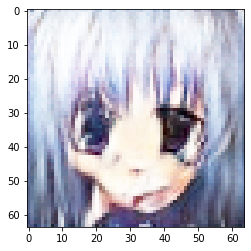

5601/12000: d_loss: 0.7093,  a_loss: 0.7617.
5602/12000: d_loss: 0.6950,  a_loss: 0.7484.
5603/12000: d_loss: 0.6772,  a_loss: 0.7402.
5604/12000: d_loss: 0.6878,  a_loss: 0.7542.
5605/12000: d_loss: 0.6784,  a_loss: 0.7422.
5606/12000: d_loss: 0.7112,  a_loss: 0.8248.
5607/12000: d_loss: 0.6987,  a_loss: 0.7869.
5608/12000: d_loss: 0.6702,  a_loss: 0.7514.
5609/12000: d_loss: 0.7323,  a_loss: 0.8175.
5610/12000: d_loss: 0.6897,  a_loss: 0.7634.
5611/12000: d_loss: 0.6955,  a_loss: 0.7790.
5612/12000: d_loss: 0.6881,  a_loss: 0.7480.
5613/12000: d_loss: 0.7129,  a_loss: 0.7860.
5614/12000: d_loss: 0.6813,  a_loss: 0.7742.
5615/12000: d_loss: 0.6954,  a_loss: 0.7632.
5616/12000: d_loss: 0.6957,  a_loss: 0.8023.
5617/12000: d_loss: 0.6724,  a_loss: 0.8358.
5618/12000: d_loss: 0.6798,  a_loss: 0.7827.
5619/12000: d_loss: 0.6999,  a_loss: 0.7809.
5620/12000: d_loss: 0.6834,  a_loss: 0.8032.
5621/12000: d_loss: 0.6936,  a_loss: 0.7751.
5622/12000: d_loss: 0.6896,  a_loss: 0.8094.
5623/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5700/12000: d_loss: 0.7142,  a_loss: 0.8346.


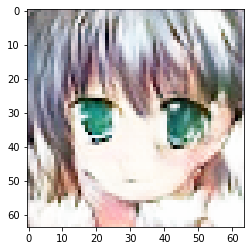

5701/12000: d_loss: 0.6815,  a_loss: 0.7460.
5702/12000: d_loss: 0.7095,  a_loss: 0.8338.
5703/12000: d_loss: 0.6885,  a_loss: 0.7634.
5704/12000: d_loss: 0.6878,  a_loss: 0.8028.
5705/12000: d_loss: 0.6710,  a_loss: 0.7299.
5706/12000: d_loss: 0.7076,  a_loss: 0.8131.
5707/12000: d_loss: 0.6905,  a_loss: 0.7788.
5708/12000: d_loss: 0.6980,  a_loss: 0.7386.
5709/12000: d_loss: 0.6941,  a_loss: 0.7977.
5710/12000: d_loss: 0.6944,  a_loss: 0.7719.
5711/12000: d_loss: 0.6830,  a_loss: 0.7094.
5712/12000: d_loss: 0.6983,  a_loss: 0.8456.
5713/12000: d_loss: 0.6931,  a_loss: 0.7811.
5714/12000: d_loss: 0.6963,  a_loss: 0.7657.
5715/12000: d_loss: 0.7003,  a_loss: 0.7666.
5716/12000: d_loss: 0.6942,  a_loss: 0.7669.
5717/12000: d_loss: 0.6959,  a_loss: 0.7552.
5718/12000: d_loss: 0.6927,  a_loss: 0.7413.
5719/12000: d_loss: 0.7076,  a_loss: 0.8039.
5720/12000: d_loss: 0.6935,  a_loss: 0.7791.
5721/12000: d_loss: 0.6889,  a_loss: 0.7680.
5722/12000: d_loss: 0.7266,  a_loss: 0.8468.
5723/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5800/12000: d_loss: 0.6832,  a_loss: 0.8865.


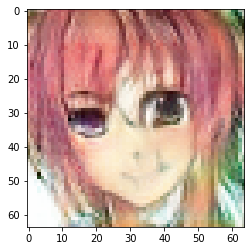

5801/12000: d_loss: 0.6817,  a_loss: 0.7509.
5802/12000: d_loss: 0.7009,  a_loss: 0.8034.
5803/12000: d_loss: 0.7076,  a_loss: 0.8204.
5804/12000: d_loss: 0.6769,  a_loss: 0.7645.
5805/12000: d_loss: 0.6821,  a_loss: 0.7548.
5806/12000: d_loss: 0.6784,  a_loss: 0.7263.
5807/12000: d_loss: 0.7173,  a_loss: 0.8107.
5808/12000: d_loss: 0.7000,  a_loss: 0.7870.
5809/12000: d_loss: 0.6818,  a_loss: 0.7694.
5810/12000: d_loss: 0.7194,  a_loss: 0.8466.
5811/12000: d_loss: 0.6828,  a_loss: 0.8253.
5812/12000: d_loss: 0.6933,  a_loss: 0.7220.
5813/12000: d_loss: 0.6734,  a_loss: 0.7012.
5814/12000: d_loss: 0.6922,  a_loss: 0.8038.
5815/12000: d_loss: 0.7064,  a_loss: 0.8595.
5816/12000: d_loss: 0.6897,  a_loss: 0.7819.
5817/12000: d_loss: 0.6883,  a_loss: 0.7614.
5818/12000: d_loss: 0.6880,  a_loss: 0.7608.
5819/12000: d_loss: 0.6869,  a_loss: 0.6924.
5820/12000: d_loss: 0.6973,  a_loss: 0.7878.
5821/12000: d_loss: 0.6803,  a_loss: 0.7488.
5822/12000: d_loss: 0.6873,  a_loss: 0.7379.
5823/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5900/12000: d_loss: 0.6934,  a_loss: 0.7651.


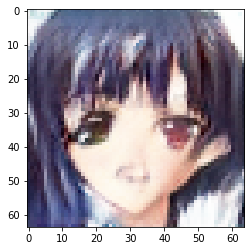

5901/12000: d_loss: 0.6851,  a_loss: 0.7227.
5902/12000: d_loss: 0.7077,  a_loss: 0.8443.
5903/12000: d_loss: 0.6912,  a_loss: 0.7766.
5904/12000: d_loss: 0.6965,  a_loss: 0.7627.
5905/12000: d_loss: 0.6964,  a_loss: 0.7564.
5906/12000: d_loss: 0.6915,  a_loss: 0.8116.
5907/12000: d_loss: 0.6890,  a_loss: 0.7639.
5908/12000: d_loss: 0.6868,  a_loss: 0.6825.
5909/12000: d_loss: 0.7174,  a_loss: 0.7979.
5910/12000: d_loss: 0.6994,  a_loss: 0.7509.
5911/12000: d_loss: 0.6794,  a_loss: 0.7963.
5912/12000: d_loss: 0.6795,  a_loss: 0.7464.
5913/12000: d_loss: 0.6850,  a_loss: 0.7858.
5914/12000: d_loss: 0.6836,  a_loss: 0.7313.
5915/12000: d_loss: 0.7080,  a_loss: 0.7635.
5916/12000: d_loss: 0.6973,  a_loss: 0.8155.
5917/12000: d_loss: 0.6890,  a_loss: 0.7807.
5918/12000: d_loss: 0.7001,  a_loss: 0.7389.
5919/12000: d_loss: 0.7006,  a_loss: 0.7747.
5920/12000: d_loss: 0.6941,  a_loss: 0.8108.
5921/12000: d_loss: 0.6758,  a_loss: 0.7452.
5922/12000: d_loss: 0.6887,  a_loss: 0.7328.
5923/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6000/12000: d_loss: 0.7179,  a_loss: 0.7673.


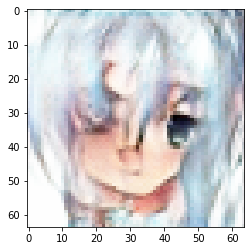

6001/12000: d_loss: 0.6974,  a_loss: 0.7681.
6002/12000: d_loss: 0.6997,  a_loss: 0.7509.
6003/12000: d_loss: 0.7036,  a_loss: 0.7710.
6004/12000: d_loss: 0.6923,  a_loss: 0.7525.
6005/12000: d_loss: 0.6912,  a_loss: 0.7839.
6006/12000: d_loss: 0.6959,  a_loss: 0.7903.
6007/12000: d_loss: 0.6884,  a_loss: 0.8095.
6008/12000: d_loss: 0.6918,  a_loss: 0.7762.
6009/12000: d_loss: 0.6920,  a_loss: 0.7868.
6010/12000: d_loss: 0.6878,  a_loss: 0.7645.
6011/12000: d_loss: 0.6849,  a_loss: 0.8036.
6012/12000: d_loss: 0.7014,  a_loss: 0.7715.
6013/12000: d_loss: 0.6918,  a_loss: 0.7766.
6014/12000: d_loss: 0.6808,  a_loss: 0.6657.
6015/12000: d_loss: 0.7160,  a_loss: 0.8424.
6016/12000: d_loss: 0.6926,  a_loss: 0.7749.
6017/12000: d_loss: 0.7008,  a_loss: 0.7560.
6018/12000: d_loss: 0.6944,  a_loss: 0.7586.
6019/12000: d_loss: 0.6963,  a_loss: 0.7956.
6020/12000: d_loss: 0.6928,  a_loss: 0.7490.
6021/12000: d_loss: 0.6964,  a_loss: 0.7918.
6022/12000: d_loss: 0.6934,  a_loss: 0.7876.
6023/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6100/12000: d_loss: 0.7154,  a_loss: 0.8295.


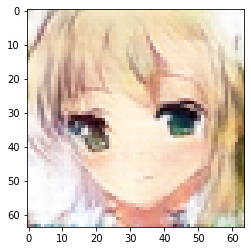

6101/12000: d_loss: 0.6993,  a_loss: 0.8052.
6102/12000: d_loss: 0.6887,  a_loss: 0.7422.
6103/12000: d_loss: 0.7131,  a_loss: 0.7725.
6104/12000: d_loss: 0.6920,  a_loss: 0.7313.
6105/12000: d_loss: 0.6998,  a_loss: 0.7769.
6106/12000: d_loss: 0.6903,  a_loss: 0.7495.
6107/12000: d_loss: 0.6979,  a_loss: 0.7859.
6108/12000: d_loss: 0.6887,  a_loss: 0.7321.
6109/12000: d_loss: 0.6846,  a_loss: 0.7988.
6110/12000: d_loss: 0.6770,  a_loss: 0.8152.
6111/12000: d_loss: 0.7068,  a_loss: 0.7662.
6112/12000: d_loss: 0.6874,  a_loss: 0.7660.
6113/12000: d_loss: 0.6992,  a_loss: 0.7861.
6114/12000: d_loss: 0.6886,  a_loss: 0.8090.
6115/12000: d_loss: 0.6972,  a_loss: 0.8218.
6116/12000: d_loss: 0.7020,  a_loss: 0.7558.
6117/12000: d_loss: 0.6916,  a_loss: 0.7564.
6118/12000: d_loss: 0.6832,  a_loss: 0.7621.
6119/12000: d_loss: 0.6996,  a_loss: 0.7998.
6120/12000: d_loss: 0.6859,  a_loss: 0.7808.
6121/12000: d_loss: 0.7044,  a_loss: 0.7658.
6122/12000: d_loss: 0.7593,  a_loss: 0.8598.
6123/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6200/12000: d_loss: 0.7003,  a_loss: 0.8416.


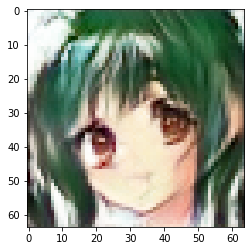

6201/12000: d_loss: 0.6746,  a_loss: 0.7805.
6202/12000: d_loss: 0.6933,  a_loss: 0.7400.
6203/12000: d_loss: 0.7068,  a_loss: 0.8146.
6204/12000: d_loss: 0.7005,  a_loss: 0.8157.
6205/12000: d_loss: 0.6924,  a_loss: 0.7907.
6206/12000: d_loss: 0.7001,  a_loss: 0.7298.
6207/12000: d_loss: 0.7114,  a_loss: 0.7834.
6208/12000: d_loss: 0.6918,  a_loss: 0.7860.
6209/12000: d_loss: 0.6930,  a_loss: 0.7806.
6210/12000: d_loss: 0.6863,  a_loss: 0.7928.
6211/12000: d_loss: 0.6848,  a_loss: 0.8102.
6212/12000: d_loss: 0.6806,  a_loss: 0.7117.
6213/12000: d_loss: 0.6915,  a_loss: 0.8131.
6214/12000: d_loss: 0.6860,  a_loss: 0.7935.
6215/12000: d_loss: 0.6952,  a_loss: 0.8609.
6216/12000: d_loss: 0.6890,  a_loss: 0.7974.
6217/12000: d_loss: 0.6961,  a_loss: 0.7364.
6218/12000: d_loss: 0.6829,  a_loss: 0.7447.
6219/12000: d_loss: 0.6956,  a_loss: 0.7807.
6220/12000: d_loss: 0.6809,  a_loss: 0.7409.
6221/12000: d_loss: 0.6991,  a_loss: 0.7557.
6222/12000: d_loss: 0.6940,  a_loss: 0.7609.
6223/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6300/12000: d_loss: 0.6980,  a_loss: 0.7766.


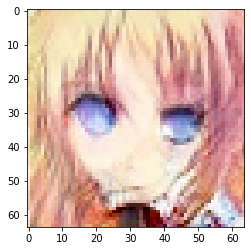

6301/12000: d_loss: 0.6894,  a_loss: 0.8253.
6302/12000: d_loss: 0.6970,  a_loss: 0.8240.
6303/12000: d_loss: 0.7054,  a_loss: 0.7777.
6304/12000: d_loss: 0.7061,  a_loss: 0.7780.
6305/12000: d_loss: 0.6947,  a_loss: 0.7813.
6306/12000: d_loss: 0.6831,  a_loss: 0.7578.
6307/12000: d_loss: 0.6825,  a_loss: 0.7684.
6308/12000: d_loss: 0.6929,  a_loss: 0.7944.
6309/12000: d_loss: 0.6861,  a_loss: 0.8556.
6310/12000: d_loss: 0.7016,  a_loss: 0.8000.
6311/12000: d_loss: 0.6913,  a_loss: 0.7709.
6312/12000: d_loss: 0.6987,  a_loss: 0.7895.
6313/12000: d_loss: 0.6914,  a_loss: 0.8219.
6314/12000: d_loss: 0.6924,  a_loss: 0.7376.
6315/12000: d_loss: 0.6876,  a_loss: 0.8061.
6316/12000: d_loss: 0.6839,  a_loss: 0.7631.
6317/12000: d_loss: 0.6994,  a_loss: 0.7616.
6318/12000: d_loss: 0.6928,  a_loss: 0.7730.
6319/12000: d_loss: 0.6883,  a_loss: 0.7346.
6320/12000: d_loss: 0.7012,  a_loss: 0.8456.
6321/12000: d_loss: 0.6944,  a_loss: 0.7630.
6322/12000: d_loss: 0.7070,  a_loss: 0.7966.
6323/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6400/12000: d_loss: 0.6836,  a_loss: 0.7075.


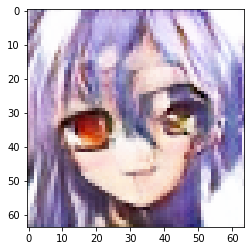

6401/12000: d_loss: 0.7078,  a_loss: 0.8381.
6402/12000: d_loss: 0.6972,  a_loss: 0.7665.
6403/12000: d_loss: 0.6995,  a_loss: 0.7890.
6404/12000: d_loss: 0.6769,  a_loss: 0.7508.
6405/12000: d_loss: 0.6860,  a_loss: 0.7389.
6406/12000: d_loss: 0.6841,  a_loss: 0.7327.
6407/12000: d_loss: 0.6821,  a_loss: 0.8506.
6408/12000: d_loss: 0.7041,  a_loss: 0.8520.
6409/12000: d_loss: 0.6860,  a_loss: 0.7544.
6410/12000: d_loss: 0.6949,  a_loss: 0.8247.
6411/12000: d_loss: 0.6874,  a_loss: 0.7977.
6412/12000: d_loss: 0.6860,  a_loss: 0.7442.
6413/12000: d_loss: 0.6944,  a_loss: 0.7729.
6414/12000: d_loss: 0.6966,  a_loss: 0.7948.
6415/12000: d_loss: 0.6858,  a_loss: 0.7827.
6416/12000: d_loss: 0.6896,  a_loss: 0.7895.
6417/12000: d_loss: 0.6931,  a_loss: 0.7336.
6418/12000: d_loss: 0.6895,  a_loss: 0.7752.
6419/12000: d_loss: 0.6949,  a_loss: 0.7828.
6420/12000: d_loss: 0.6900,  a_loss: 0.7543.
6421/12000: d_loss: 0.6782,  a_loss: 0.7260.
6422/12000: d_loss: 0.6937,  a_loss: 0.7512.
6423/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6500/12000: d_loss: 0.6839,  a_loss: 0.7885.


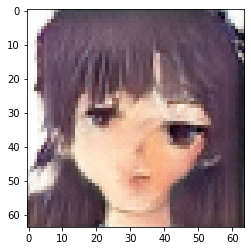

6501/12000: d_loss: 0.7176,  a_loss: 0.7587.
6502/12000: d_loss: 0.6918,  a_loss: 0.7542.
6503/12000: d_loss: 0.6883,  a_loss: 0.7193.
6504/12000: d_loss: 0.7188,  a_loss: 0.8430.
6505/12000: d_loss: 0.6845,  a_loss: 0.7935.
6506/12000: d_loss: 0.6949,  a_loss: 0.7734.
6507/12000: d_loss: 0.6976,  a_loss: 0.8129.
6508/12000: d_loss: 0.7074,  a_loss: 0.7974.
6509/12000: d_loss: 0.6970,  a_loss: 0.7771.
6510/12000: d_loss: 0.6862,  a_loss: 0.7561.
6511/12000: d_loss: 0.7012,  a_loss: 0.8061.
6512/12000: d_loss: 0.6957,  a_loss: 0.7925.
6513/12000: d_loss: 0.7030,  a_loss: 0.8612.
6514/12000: d_loss: 0.6901,  a_loss: 0.8033.
6515/12000: d_loss: 0.6983,  a_loss: 0.7677.
6516/12000: d_loss: 0.6938,  a_loss: 0.8367.
6517/12000: d_loss: 0.6951,  a_loss: 0.7936.
6518/12000: d_loss: 0.6883,  a_loss: 0.7774.
6519/12000: d_loss: 0.6820,  a_loss: 0.7919.
6520/12000: d_loss: 0.6959,  a_loss: 0.7941.
6521/12000: d_loss: 0.6983,  a_loss: 0.8560.
6522/12000: d_loss: 0.6928,  a_loss: 0.7872.
6523/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6600/12000: d_loss: 0.6861,  a_loss: 0.8071.


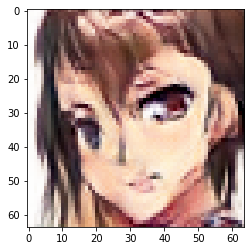

6601/12000: d_loss: 0.7011,  a_loss: 0.8151.
6602/12000: d_loss: 0.6921,  a_loss: 0.7675.
6603/12000: d_loss: 0.6897,  a_loss: 0.7449.
6604/12000: d_loss: 0.6908,  a_loss: 0.7476.
6605/12000: d_loss: 0.6934,  a_loss: 0.7853.
6606/12000: d_loss: 0.6894,  a_loss: 0.7490.
6607/12000: d_loss: 0.6876,  a_loss: 0.7834.
6608/12000: d_loss: 0.6858,  a_loss: 0.8133.
6609/12000: d_loss: 0.6912,  a_loss: 0.8463.
6610/12000: d_loss: 0.6900,  a_loss: 0.7341.
6611/12000: d_loss: 0.6892,  a_loss: 0.8108.
6612/12000: d_loss: 0.6918,  a_loss: 0.7872.
6613/12000: d_loss: 0.6993,  a_loss: 0.7812.
6614/12000: d_loss: 0.6828,  a_loss: 0.7616.
6615/12000: d_loss: 0.6927,  a_loss: 0.7668.
6616/12000: d_loss: 0.6960,  a_loss: 0.7971.
6617/12000: d_loss: 0.7038,  a_loss: 0.7668.
6618/12000: d_loss: 0.6833,  a_loss: 0.7471.
6619/12000: d_loss: 0.6942,  a_loss: 0.7657.
6620/12000: d_loss: 0.6842,  a_loss: 0.7220.
6621/12000: d_loss: 0.6907,  a_loss: 0.7634.
6622/12000: d_loss: 0.6981,  a_loss: 0.8164.
6623/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6700/12000: d_loss: 0.6877,  a_loss: 0.7930.


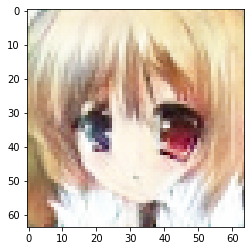

6701/12000: d_loss: 0.6887,  a_loss: 0.7927.
6702/12000: d_loss: 0.6948,  a_loss: 0.7491.
6703/12000: d_loss: 0.6885,  a_loss: 0.7157.
6704/12000: d_loss: 0.6881,  a_loss: 0.7779.
6705/12000: d_loss: 0.6963,  a_loss: 0.7681.
6706/12000: d_loss: 0.7004,  a_loss: 0.7637.
6707/12000: d_loss: 0.6958,  a_loss: 0.7905.
6708/12000: d_loss: 0.6971,  a_loss: 0.7817.
6709/12000: d_loss: 0.6876,  a_loss: 0.8175.
6710/12000: d_loss: 0.6947,  a_loss: 0.7705.
6711/12000: d_loss: 0.6836,  a_loss: 0.7249.
6712/12000: d_loss: 0.7069,  a_loss: 0.8397.
6713/12000: d_loss: 0.6963,  a_loss: 0.7977.
6714/12000: d_loss: 0.6893,  a_loss: 0.7599.
6715/12000: d_loss: 0.6923,  a_loss: 0.7934.
6716/12000: d_loss: 0.6872,  a_loss: 0.7403.
6717/12000: d_loss: 0.7126,  a_loss: 0.7807.
6718/12000: d_loss: 0.6915,  a_loss: 0.8101.
6719/12000: d_loss: 0.6968,  a_loss: 0.7546.
6720/12000: d_loss: 0.6932,  a_loss: 0.7869.
6721/12000: d_loss: 0.6866,  a_loss: 0.7603.
6722/12000: d_loss: 0.6829,  a_loss: 0.7967.
6723/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6800/12000: d_loss: 0.6750,  a_loss: 0.7143.


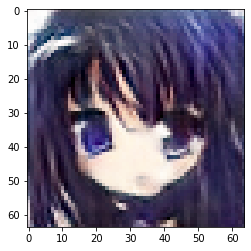

6801/12000: d_loss: 0.7075,  a_loss: 0.8763.
6802/12000: d_loss: 0.6951,  a_loss: 0.7702.
6803/12000: d_loss: 0.6989,  a_loss: 0.7976.
6804/12000: d_loss: 0.6923,  a_loss: 0.7874.
6805/12000: d_loss: 0.6919,  a_loss: 0.7364.
6806/12000: d_loss: 0.6947,  a_loss: 0.7624.
6807/12000: d_loss: 0.6961,  a_loss: 0.7701.
6808/12000: d_loss: 0.6864,  a_loss: 0.7343.
6809/12000: d_loss: 0.6831,  a_loss: 0.7871.
6810/12000: d_loss: 0.7042,  a_loss: 0.8112.
6811/12000: d_loss: 0.6865,  a_loss: 0.7843.
6812/12000: d_loss: 0.6885,  a_loss: 0.7817.
6813/12000: d_loss: 0.7180,  a_loss: 0.8329.
6814/12000: d_loss: 0.6974,  a_loss: 0.8128.
6815/12000: d_loss: 0.7030,  a_loss: 0.8346.
6816/12000: d_loss: 0.6912,  a_loss: 0.7599.
6817/12000: d_loss: 0.7137,  a_loss: 0.8373.
6818/12000: d_loss: 0.6876,  a_loss: 0.7870.
6819/12000: d_loss: 0.6779,  a_loss: 0.8247.
6820/12000: d_loss: 0.7019,  a_loss: 0.7566.
6821/12000: d_loss: 0.6948,  a_loss: 0.7235.
6822/12000: d_loss: 0.6886,  a_loss: 0.7588.
6823/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


6900/12000: d_loss: 0.6891,  a_loss: 0.7485.


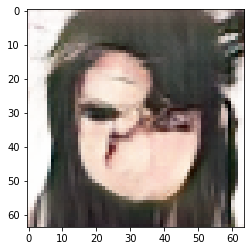

6901/12000: d_loss: 0.7076,  a_loss: 0.7834.
6902/12000: d_loss: 0.6812,  a_loss: 0.7985.
6903/12000: d_loss: 0.6887,  a_loss: 0.7964.
6904/12000: d_loss: 0.6873,  a_loss: 0.8045.
6905/12000: d_loss: 0.6872,  a_loss: 0.7632.
6906/12000: d_loss: 0.6921,  a_loss: 0.7879.
6907/12000: d_loss: 0.6868,  a_loss: 0.7831.
6908/12000: d_loss: 0.6867,  a_loss: 0.7789.
6909/12000: d_loss: 0.7096,  a_loss: 0.8420.
6910/12000: d_loss: 0.6938,  a_loss: 0.7726.
6911/12000: d_loss: 0.6758,  a_loss: 0.7418.
6912/12000: d_loss: 0.6855,  a_loss: 0.8383.
6913/12000: d_loss: 0.6975,  a_loss: 0.8010.
6914/12000: d_loss: 0.6866,  a_loss: 0.7313.
6915/12000: d_loss: 0.7079,  a_loss: 0.7362.
6916/12000: d_loss: 0.6956,  a_loss: 0.8118.
6917/12000: d_loss: 0.6953,  a_loss: 0.8169.
6918/12000: d_loss: 0.6962,  a_loss: 0.8016.
6919/12000: d_loss: 0.6864,  a_loss: 0.7615.
6920/12000: d_loss: 0.6876,  a_loss: 0.8155.
6921/12000: d_loss: 0.6892,  a_loss: 0.8012.
6922/12000: d_loss: 0.7071,  a_loss: 0.8161.
6923/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7000/12000: d_loss: 0.6727,  a_loss: 0.8110.


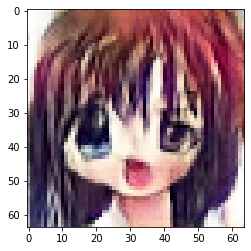

7001/12000: d_loss: 0.6958,  a_loss: 0.8031.
7002/12000: d_loss: 0.6858,  a_loss: 0.8133.
7003/12000: d_loss: 0.6828,  a_loss: 0.8420.
7004/12000: d_loss: 0.7097,  a_loss: 0.8403.
7005/12000: d_loss: 0.6878,  a_loss: 0.7665.
7006/12000: d_loss: 0.6773,  a_loss: 0.7797.
7007/12000: d_loss: 0.6679,  a_loss: 0.7794.
7008/12000: d_loss: 0.7079,  a_loss: 0.7731.
7009/12000: d_loss: 0.6843,  a_loss: 0.8402.
7010/12000: d_loss: 0.6894,  a_loss: 0.7324.
7011/12000: d_loss: 0.6975,  a_loss: 0.8254.
7012/12000: d_loss: 0.6861,  a_loss: 0.7150.
7013/12000: d_loss: 0.6926,  a_loss: 0.7375.
7014/12000: d_loss: 0.6916,  a_loss: 0.7737.
7015/12000: d_loss: 0.6843,  a_loss: 0.7507.
7016/12000: d_loss: 0.7027,  a_loss: 0.8457.
7017/12000: d_loss: 0.6799,  a_loss: 0.7596.
7018/12000: d_loss: 0.7175,  a_loss: 0.8612.
7019/12000: d_loss: 0.6967,  a_loss: 0.7713.
7020/12000: d_loss: 0.6881,  a_loss: 0.7691.
7021/12000: d_loss: 0.6926,  a_loss: 0.7565.
7022/12000: d_loss: 0.6704,  a_loss: 0.7796.
7023/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7100/12000: d_loss: 0.7014,  a_loss: 0.8329.


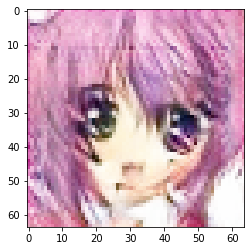

7101/12000: d_loss: 0.6822,  a_loss: 0.7927.
7102/12000: d_loss: 0.7052,  a_loss: 0.8272.
7103/12000: d_loss: 0.6949,  a_loss: 0.7438.
7104/12000: d_loss: 0.6894,  a_loss: 0.7879.
7105/12000: d_loss: 0.6837,  a_loss: 0.7814.
7106/12000: d_loss: 0.6920,  a_loss: 0.7191.
7107/12000: d_loss: 0.6722,  a_loss: 0.7202.
7108/12000: d_loss: 0.6878,  a_loss: 0.8372.
7109/12000: d_loss: 0.6808,  a_loss: 0.7392.
7110/12000: d_loss: 0.6941,  a_loss: 0.8348.
7111/12000: d_loss: 0.6773,  a_loss: 0.8367.
7112/12000: d_loss: 0.6871,  a_loss: 0.7895.
7113/12000: d_loss: 0.7023,  a_loss: 0.7914.
7114/12000: d_loss: 0.6943,  a_loss: 0.7637.
7115/12000: d_loss: 0.7270,  a_loss: 0.8535.
7116/12000: d_loss: 0.6985,  a_loss: 0.7733.
7117/12000: d_loss: 0.6890,  a_loss: 0.7790.
7118/12000: d_loss: 0.6987,  a_loss: 0.7086.
7119/12000: d_loss: 0.7177,  a_loss: 0.8131.
7120/12000: d_loss: 0.6786,  a_loss: 0.8538.
7121/12000: d_loss: 0.7023,  a_loss: 0.7972.
7122/12000: d_loss: 0.6868,  a_loss: 0.7333.
7123/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7200/12000: d_loss: 0.7002,  a_loss: 0.7715.


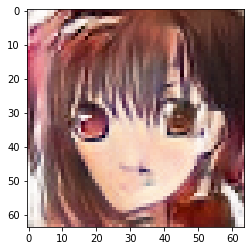

7201/12000: d_loss: 0.6978,  a_loss: 0.7362.
7202/12000: d_loss: 0.6914,  a_loss: 0.7825.
7203/12000: d_loss: 0.6812,  a_loss: 0.7387.
7204/12000: d_loss: 0.6815,  a_loss: 0.8398.
7205/12000: d_loss: 0.6860,  a_loss: 0.7744.
7206/12000: d_loss: 0.6889,  a_loss: 0.7605.
7207/12000: d_loss: 0.6974,  a_loss: 0.7948.
7208/12000: d_loss: 0.6940,  a_loss: 0.7663.
7209/12000: d_loss: 0.6914,  a_loss: 0.7600.
7210/12000: d_loss: 0.6878,  a_loss: 0.7457.
7211/12000: d_loss: 0.6712,  a_loss: 0.8068.
7212/12000: d_loss: 0.6998,  a_loss: 0.8042.
7213/12000: d_loss: 0.6841,  a_loss: 0.7497.
7214/12000: d_loss: 0.6940,  a_loss: 0.7859.
7215/12000: d_loss: 0.6818,  a_loss: 0.7968.
7216/12000: d_loss: 0.6933,  a_loss: 0.8604.
7217/12000: d_loss: 0.7031,  a_loss: 0.7663.
7218/12000: d_loss: 0.6953,  a_loss: 0.7702.
7219/12000: d_loss: 0.6967,  a_loss: 0.7650.
7220/12000: d_loss: 0.7081,  a_loss: 0.7721.
7221/12000: d_loss: 0.6824,  a_loss: 0.7603.
7222/12000: d_loss: 0.6674,  a_loss: 0.7846.
7223/12000

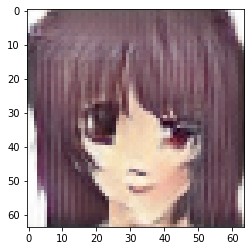

7301/12000: d_loss: 0.6953,  a_loss: 0.7515.
7302/12000: d_loss: 0.6978,  a_loss: 0.8573.
7303/12000: d_loss: 0.6981,  a_loss: 0.7614.
7304/12000: d_loss: 0.6984,  a_loss: 0.8426.
7305/12000: d_loss: 0.6989,  a_loss: 0.7541.
7306/12000: d_loss: 0.6850,  a_loss: 0.7759.
7307/12000: d_loss: 0.7020,  a_loss: 0.7583.
7308/12000: d_loss: 0.7018,  a_loss: 0.7662.
7309/12000: d_loss: 0.6975,  a_loss: 0.8311.
7310/12000: d_loss: 0.6872,  a_loss: 0.7772.
7311/12000: d_loss: 0.6889,  a_loss: 0.7835.
7312/12000: d_loss: 0.6872,  a_loss: 0.7493.
7313/12000: d_loss: 0.6892,  a_loss: 0.7367.
7314/12000: d_loss: 0.6868,  a_loss: 0.7188.
7315/12000: d_loss: 0.7209,  a_loss: 0.8366.
7316/12000: d_loss: 0.6978,  a_loss: 0.7740.
7317/12000: d_loss: 0.6899,  a_loss: 0.7621.
7318/12000: d_loss: 0.7074,  a_loss: 0.7643.
7319/12000: d_loss: 0.6902,  a_loss: 0.7874.
7320/12000: d_loss: 0.6929,  a_loss: 0.7347.
7321/12000: d_loss: 0.7024,  a_loss: 0.7724.
7322/12000: d_loss: 0.6911,  a_loss: 0.7862.
7323/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7400/12000: d_loss: 0.6976,  a_loss: 0.7832.


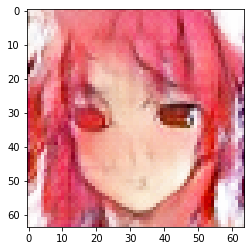

7401/12000: d_loss: 0.6780,  a_loss: 0.8087.
7402/12000: d_loss: 0.6946,  a_loss: 0.7811.
7403/12000: d_loss: 0.7004,  a_loss: 0.7867.
7404/12000: d_loss: 0.6869,  a_loss: 0.7195.
7405/12000: d_loss: 0.6796,  a_loss: 0.7959.
7406/12000: d_loss: 0.7109,  a_loss: 0.8388.
7407/12000: d_loss: 0.6995,  a_loss: 0.7342.
7408/12000: d_loss: 0.6925,  a_loss: 0.7366.
7409/12000: d_loss: 0.6950,  a_loss: 0.8293.
7410/12000: d_loss: 0.6812,  a_loss: 0.8239.
7411/12000: d_loss: 0.6907,  a_loss: 0.7219.
7412/12000: d_loss: 0.7148,  a_loss: 0.7894.
7413/12000: d_loss: 0.6825,  a_loss: 0.7854.
7414/12000: d_loss: 0.7095,  a_loss: 0.7685.
7415/12000: d_loss: 0.6952,  a_loss: 0.7479.
7416/12000: d_loss: 0.7006,  a_loss: 0.7843.
7417/12000: d_loss: 0.6892,  a_loss: 0.7589.
7418/12000: d_loss: 0.6966,  a_loss: 0.7382.
7419/12000: d_loss: 0.6833,  a_loss: 0.7320.
7420/12000: d_loss: 0.7076,  a_loss: 0.8304.
7421/12000: d_loss: 0.7005,  a_loss: 0.7570.
7422/12000: d_loss: 0.6869,  a_loss: 0.7465.
7423/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7500/12000: d_loss: 0.6796,  a_loss: 0.7938.


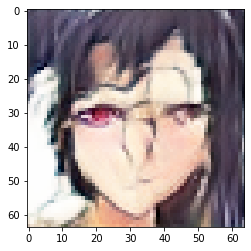

7501/12000: d_loss: 0.6842,  a_loss: 0.6934.
7502/12000: d_loss: 0.7094,  a_loss: 0.8681.
7503/12000: d_loss: 0.6898,  a_loss: 0.7941.
7504/12000: d_loss: 0.6984,  a_loss: 0.7319.
7505/12000: d_loss: 0.6975,  a_loss: 0.7573.
7506/12000: d_loss: 0.6967,  a_loss: 0.7757.
7507/12000: d_loss: 0.6843,  a_loss: 0.7399.
7508/12000: d_loss: 0.6850,  a_loss: 0.7452.
7509/12000: d_loss: 0.7089,  a_loss: 0.8734.
7510/12000: d_loss: 0.7002,  a_loss: 0.7589.
7511/12000: d_loss: 0.6949,  a_loss: 0.7267.
7512/12000: d_loss: 0.6840,  a_loss: 0.7756.
7513/12000: d_loss: 0.6954,  a_loss: 0.8078.
7514/12000: d_loss: 0.7034,  a_loss: 0.7777.
7515/12000: d_loss: 0.6869,  a_loss: 0.8166.
7516/12000: d_loss: 0.6937,  a_loss: 0.7786.
7517/12000: d_loss: 0.6834,  a_loss: 0.7058.
7518/12000: d_loss: 0.6897,  a_loss: 0.7737.
7519/12000: d_loss: 0.6774,  a_loss: 0.8088.
7520/12000: d_loss: 0.6920,  a_loss: 0.7710.
7521/12000: d_loss: 0.6888,  a_loss: 0.8350.
7522/12000: d_loss: 0.6991,  a_loss: 0.7296.
7523/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7600/12000: d_loss: 0.7054,  a_loss: 0.7709.


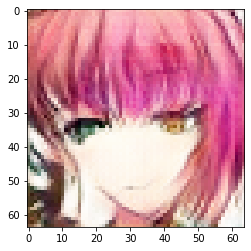

7601/12000: d_loss: 0.7059,  a_loss: 0.7524.
7602/12000: d_loss: 0.6733,  a_loss: 0.7601.
7603/12000: d_loss: 0.6890,  a_loss: 0.7666.
7604/12000: d_loss: 0.6929,  a_loss: 0.7892.
7605/12000: d_loss: 0.6784,  a_loss: 0.7822.
7606/12000: d_loss: 0.6927,  a_loss: 0.8473.
7607/12000: d_loss: 0.6939,  a_loss: 0.7622.
7608/12000: d_loss: 0.6923,  a_loss: 0.7511.
7609/12000: d_loss: 0.7136,  a_loss: 0.8457.
7610/12000: d_loss: 0.6978,  a_loss: 0.7830.
7611/12000: d_loss: 0.6943,  a_loss: 0.7966.
7612/12000: d_loss: 0.6952,  a_loss: 0.8066.
7613/12000: d_loss: 0.7031,  a_loss: 0.7699.
7614/12000: d_loss: 0.6757,  a_loss: 0.7619.
7615/12000: d_loss: 0.6845,  a_loss: 0.7338.
7616/12000: d_loss: 0.6989,  a_loss: 0.8078.
7617/12000: d_loss: 0.6880,  a_loss: 0.7879.
7618/12000: d_loss: 0.6937,  a_loss: 0.7678.
7619/12000: d_loss: 0.6902,  a_loss: 0.7404.
7620/12000: d_loss: 0.6857,  a_loss: 0.8438.
7621/12000: d_loss: 0.7025,  a_loss: 0.7963.
7622/12000: d_loss: 0.6988,  a_loss: 0.7701.
7623/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


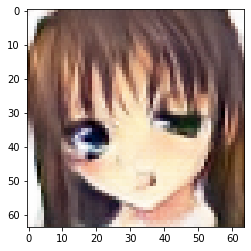

7701/12000: d_loss: 0.6941,  a_loss: 0.7858.
7702/12000: d_loss: 0.6847,  a_loss: 0.8102.
7703/12000: d_loss: 0.6919,  a_loss: 0.7671.
7704/12000: d_loss: 0.6913,  a_loss: 0.8124.
7705/12000: d_loss: 0.6795,  a_loss: 0.8044.
7706/12000: d_loss: 0.6717,  a_loss: 0.7220.
7707/12000: d_loss: 0.7071,  a_loss: 0.8568.
7708/12000: d_loss: 0.7024,  a_loss: 0.8089.
7709/12000: d_loss: 0.6948,  a_loss: 0.7663.
7710/12000: d_loss: 0.6919,  a_loss: 0.7497.
7711/12000: d_loss: 0.6887,  a_loss: 0.7727.
7712/12000: d_loss: 0.6822,  a_loss: 0.7455.
7713/12000: d_loss: 0.6922,  a_loss: 0.8248.
7714/12000: d_loss: 0.6883,  a_loss: 0.7882.
7715/12000: d_loss: 0.7240,  a_loss: 0.8348.
7716/12000: d_loss: 0.7063,  a_loss: 0.7583.
7717/12000: d_loss: 0.6911,  a_loss: 0.7805.
7718/12000: d_loss: 0.7124,  a_loss: 0.8205.
7719/12000: d_loss: 0.6819,  a_loss: 0.7621.
7720/12000: d_loss: 0.6897,  a_loss: 0.7481.
7721/12000: d_loss: 0.6746,  a_loss: 0.7708.
7722/12000: d_loss: 0.6960,  a_loss: 0.7527.
7723/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7800/12000: d_loss: 0.6901,  a_loss: 0.7527.


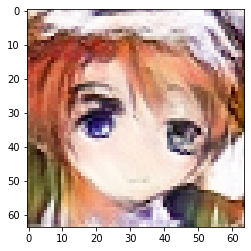

7801/12000: d_loss: 0.6924,  a_loss: 0.7724.
7802/12000: d_loss: 0.7022,  a_loss: 0.7715.
7803/12000: d_loss: 0.7101,  a_loss: 0.7665.
7804/12000: d_loss: 0.6841,  a_loss: 0.7846.
7805/12000: d_loss: 0.6851,  a_loss: 0.7183.
7806/12000: d_loss: 0.6883,  a_loss: 0.8045.
7807/12000: d_loss: 0.6814,  a_loss: 0.7716.
7808/12000: d_loss: 0.7002,  a_loss: 0.7647.
7809/12000: d_loss: 0.7038,  a_loss: 0.8631.
7810/12000: d_loss: 0.6912,  a_loss: 0.7633.
7811/12000: d_loss: 0.6893,  a_loss: 0.7442.
7812/12000: d_loss: 0.6962,  a_loss: 0.8331.
7813/12000: d_loss: 0.6869,  a_loss: 0.7696.
7814/12000: d_loss: 0.7106,  a_loss: 0.7744.
7815/12000: d_loss: 0.6888,  a_loss: 0.7464.
7816/12000: d_loss: 0.6920,  a_loss: 0.7847.
7817/12000: d_loss: 0.6969,  a_loss: 0.7654.
7818/12000: d_loss: 0.6879,  a_loss: 0.8056.
7819/12000: d_loss: 0.7006,  a_loss: 0.7765.
7820/12000: d_loss: 0.6832,  a_loss: 0.7704.
7821/12000: d_loss: 0.6894,  a_loss: 0.7655.
7822/12000: d_loss: 0.7070,  a_loss: 0.8003.
7823/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


7900/12000: d_loss: 0.6889,  a_loss: 0.7294.


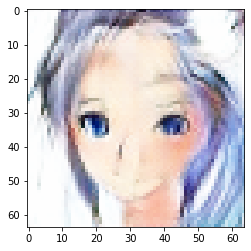

7901/12000: d_loss: 0.6936,  a_loss: 0.8108.
7902/12000: d_loss: 0.6950,  a_loss: 0.6932.
7903/12000: d_loss: 0.6805,  a_loss: 0.7011.
7904/12000: d_loss: 0.7534,  a_loss: 0.8615.
7905/12000: d_loss: 0.6841,  a_loss: 0.8333.
7906/12000: d_loss: 0.6917,  a_loss: 0.7989.
7907/12000: d_loss: 0.6918,  a_loss: 0.7647.
7908/12000: d_loss: 0.6963,  a_loss: 0.7676.
7909/12000: d_loss: 0.6898,  a_loss: 0.7402.
7910/12000: d_loss: 0.6878,  a_loss: 0.7445.
7911/12000: d_loss: 0.6892,  a_loss: 0.8154.
7912/12000: d_loss: 0.6958,  a_loss: 0.7780.
7913/12000: d_loss: 0.6904,  a_loss: 0.7323.
7914/12000: d_loss: 0.6959,  a_loss: 0.7572.
7915/12000: d_loss: 0.6858,  a_loss: 0.7357.
7916/12000: d_loss: 0.6929,  a_loss: 0.7836.
7917/12000: d_loss: 0.6986,  a_loss: 0.7781.
7918/12000: d_loss: 0.6957,  a_loss: 0.7658.
7919/12000: d_loss: 0.6981,  a_loss: 0.7602.
7920/12000: d_loss: 0.6794,  a_loss: 0.7397.
7921/12000: d_loss: 0.6921,  a_loss: 0.8191.
7922/12000: d_loss: 0.7459,  a_loss: 0.8612.
7923/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8000/12000: d_loss: 0.6980,  a_loss: 0.7651.


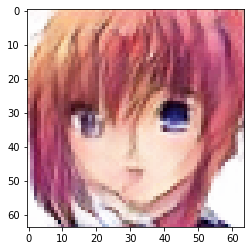

8001/12000: d_loss: 0.6877,  a_loss: 0.8205.
8002/12000: d_loss: 0.6739,  a_loss: 0.7388.
8003/12000: d_loss: 0.6998,  a_loss: 0.8037.
8004/12000: d_loss: 0.6924,  a_loss: 0.8717.
8005/12000: d_loss: 0.7034,  a_loss: 0.7761.
8006/12000: d_loss: 0.6903,  a_loss: 0.7869.
8007/12000: d_loss: 0.6784,  a_loss: 0.7292.
8008/12000: d_loss: 0.6946,  a_loss: 0.7358.
8009/12000: d_loss: 0.6855,  a_loss: 0.7280.
8010/12000: d_loss: 0.7122,  a_loss: 0.8273.
8011/12000: d_loss: 0.6889,  a_loss: 0.7654.
8012/12000: d_loss: 0.6915,  a_loss: 0.7416.
8013/12000: d_loss: 0.6976,  a_loss: 0.7797.
8014/12000: d_loss: 0.6995,  a_loss: 0.7687.
8015/12000: d_loss: 0.6936,  a_loss: 0.7654.
8016/12000: d_loss: 0.6961,  a_loss: 0.7798.
8017/12000: d_loss: 0.6986,  a_loss: 0.7430.
8018/12000: d_loss: 0.7024,  a_loss: 0.7948.
8019/12000: d_loss: 0.6944,  a_loss: 0.7636.
8020/12000: d_loss: 0.6835,  a_loss: 0.7534.
8021/12000: d_loss: 0.6993,  a_loss: 0.7893.
8022/12000: d_loss: 0.6823,  a_loss: 0.7528.
8023/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8100/12000: d_loss: 0.7032,  a_loss: 0.7506.


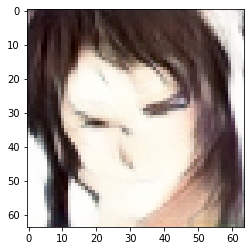

8101/12000: d_loss: 0.6990,  a_loss: 0.7784.
8102/12000: d_loss: 0.6995,  a_loss: 0.7417.
8103/12000: d_loss: 0.6865,  a_loss: 0.7669.
8104/12000: d_loss: 0.6896,  a_loss: 0.7435.
8105/12000: d_loss: 0.7066,  a_loss: 0.7842.
8106/12000: d_loss: 0.7116,  a_loss: 0.8088.
8107/12000: d_loss: 0.6789,  a_loss: 0.7352.
8108/12000: d_loss: 0.7071,  a_loss: 0.8480.
8109/12000: d_loss: 0.6883,  a_loss: 0.7966.
8110/12000: d_loss: 0.6859,  a_loss: 0.7690.
8111/12000: d_loss: 0.6974,  a_loss: 0.7826.
8112/12000: d_loss: 0.6779,  a_loss: 0.7319.
8113/12000: d_loss: 0.7053,  a_loss: 0.8279.
8114/12000: d_loss: 0.6937,  a_loss: 0.8030.
8115/12000: d_loss: 0.6973,  a_loss: 0.8755.
8116/12000: d_loss: 0.6765,  a_loss: 0.7488.
8117/12000: d_loss: 0.7080,  a_loss: 0.8745.
8118/12000: d_loss: 0.6848,  a_loss: 0.7585.
8119/12000: d_loss: 0.6912,  a_loss: 0.8308.
8120/12000: d_loss: 0.7154,  a_loss: 0.7665.
8121/12000: d_loss: 0.7001,  a_loss: 0.7753.
8122/12000: d_loss: 0.6981,  a_loss: 0.7484.
8123/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8200/12000: d_loss: 0.7145,  a_loss: 0.7823.


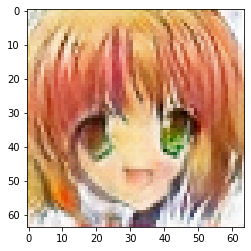

8201/12000: d_loss: 0.6897,  a_loss: 0.8009.
8202/12000: d_loss: 0.6794,  a_loss: 0.7360.
8203/12000: d_loss: 0.6977,  a_loss: 0.7564.
8204/12000: d_loss: 0.6802,  a_loss: 0.8309.
8205/12000: d_loss: 0.6718,  a_loss: 0.7978.
8206/12000: d_loss: 0.6733,  a_loss: 0.7759.
8207/12000: d_loss: 0.7034,  a_loss: 0.7495.
8208/12000: d_loss: 0.6940,  a_loss: 0.8200.
8209/12000: d_loss: 0.6891,  a_loss: 0.7506.
8210/12000: d_loss: 0.6928,  a_loss: 0.8591.
8211/12000: d_loss: 0.6911,  a_loss: 0.7283.
8212/12000: d_loss: 0.7001,  a_loss: 0.8012.
8213/12000: d_loss: 0.6915,  a_loss: 0.7800.
8214/12000: d_loss: 0.7120,  a_loss: 0.8374.
8215/12000: d_loss: 0.6950,  a_loss: 0.7625.
8216/12000: d_loss: 0.6764,  a_loss: 0.7525.
8217/12000: d_loss: 0.6897,  a_loss: 0.7827.
8218/12000: d_loss: 0.6962,  a_loss: 0.7650.
8219/12000: d_loss: 0.6865,  a_loss: 0.7896.
8220/12000: d_loss: 0.6883,  a_loss: 0.7494.
8221/12000: d_loss: 0.6900,  a_loss: 0.7951.
8222/12000: d_loss: 0.6732,  a_loss: 0.7592.
8223/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8300/12000: d_loss: 0.6957,  a_loss: 0.7598.


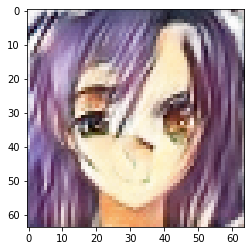

8301/12000: d_loss: 0.7010,  a_loss: 0.7841.
8302/12000: d_loss: 0.7039,  a_loss: 0.8187.
8303/12000: d_loss: 0.6872,  a_loss: 0.7912.
8304/12000: d_loss: 0.6999,  a_loss: 0.7852.
8305/12000: d_loss: 0.6797,  a_loss: 0.7712.
8306/12000: d_loss: 0.6891,  a_loss: 0.7473.
8307/12000: d_loss: 0.6866,  a_loss: 0.8431.
8308/12000: d_loss: 0.6986,  a_loss: 0.7890.
8309/12000: d_loss: 0.6905,  a_loss: 0.7312.
8310/12000: d_loss: 0.6895,  a_loss: 0.8032.
8311/12000: d_loss: 0.6989,  a_loss: 0.8108.
8312/12000: d_loss: 0.6921,  a_loss: 0.7959.
8313/12000: d_loss: 0.7027,  a_loss: 0.8273.
8314/12000: d_loss: 0.6944,  a_loss: 0.7178.
8315/12000: d_loss: 0.7035,  a_loss: 0.7924.
8316/12000: d_loss: 0.7060,  a_loss: 0.8167.
8317/12000: d_loss: 0.6837,  a_loss: 0.7983.
8318/12000: d_loss: 0.6872,  a_loss: 0.6896.
8319/12000: d_loss: 0.7224,  a_loss: 0.8408.
8320/12000: d_loss: 0.6882,  a_loss: 0.8124.
8321/12000: d_loss: 0.6977,  a_loss: 0.7840.
8322/12000: d_loss: 0.7058,  a_loss: 0.8080.
8323/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8400/12000: d_loss: 0.6978,  a_loss: 0.8000.


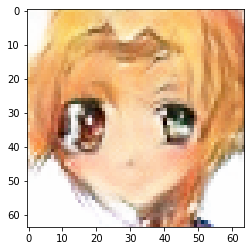

8401/12000: d_loss: 0.6947,  a_loss: 0.7474.
8402/12000: d_loss: 0.6886,  a_loss: 0.7750.
8403/12000: d_loss: 0.6995,  a_loss: 0.8196.
8404/12000: d_loss: 0.6862,  a_loss: 0.8077.
8405/12000: d_loss: 0.6947,  a_loss: 0.8029.
8406/12000: d_loss: 0.7032,  a_loss: 0.7959.
8407/12000: d_loss: 0.6850,  a_loss: 0.7531.
8408/12000: d_loss: 0.6939,  a_loss: 0.7792.
8409/12000: d_loss: 0.6706,  a_loss: 0.7318.
8410/12000: d_loss: 0.6906,  a_loss: 0.7845.
8411/12000: d_loss: 0.6891,  a_loss: 0.7361.
8412/12000: d_loss: 0.6965,  a_loss: 0.7981.
8413/12000: d_loss: 0.6849,  a_loss: 0.7481.
8414/12000: d_loss: 0.6920,  a_loss: 0.7556.
8415/12000: d_loss: 0.7122,  a_loss: 0.8025.
8416/12000: d_loss: 0.6842,  a_loss: 0.7958.
8417/12000: d_loss: 0.6867,  a_loss: 0.7811.
8418/12000: d_loss: 0.6834,  a_loss: 0.8007.
8419/12000: d_loss: 0.6954,  a_loss: 0.7583.
8420/12000: d_loss: 0.6834,  a_loss: 0.8391.
8421/12000: d_loss: 0.6858,  a_loss: 0.7478.
8422/12000: d_loss: 0.7112,  a_loss: 0.8540.
8423/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8500/12000: d_loss: 0.6860,  a_loss: 0.7994.


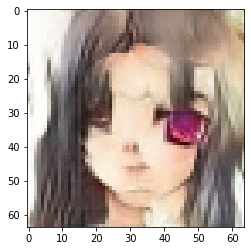

8501/12000: d_loss: 0.7099,  a_loss: 0.8426.
8502/12000: d_loss: 0.6943,  a_loss: 0.7675.
8503/12000: d_loss: 0.6927,  a_loss: 0.7642.
8504/12000: d_loss: 0.6910,  a_loss: 0.7878.
8505/12000: d_loss: 0.6932,  a_loss: 0.7552.
8506/12000: d_loss: 0.6964,  a_loss: 0.7865.
8507/12000: d_loss: 0.6815,  a_loss: 0.8106.
8508/12000: d_loss: 0.7051,  a_loss: 0.7715.
8509/12000: d_loss: 0.6935,  a_loss: 0.7803.
8510/12000: d_loss: 0.6812,  a_loss: 0.7323.
8511/12000: d_loss: 0.6956,  a_loss: 0.8349.
8512/12000: d_loss: 0.7136,  a_loss: 0.7758.
8513/12000: d_loss: 0.7000,  a_loss: 0.7483.
8514/12000: d_loss: 0.6938,  a_loss: 0.8894.
8515/12000: d_loss: 0.6999,  a_loss: 0.8039.
8516/12000: d_loss: 0.6808,  a_loss: 0.7873.
8517/12000: d_loss: 0.6887,  a_loss: 0.7992.
8518/12000: d_loss: 0.6859,  a_loss: 0.8663.
8519/12000: d_loss: 0.7073,  a_loss: 0.8475.
8520/12000: d_loss: 0.6975,  a_loss: 0.7911.
8521/12000: d_loss: 0.6850,  a_loss: 0.7462.
8522/12000: d_loss: 0.6801,  a_loss: 0.7287.
8523/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8600/12000: d_loss: 0.6992,  a_loss: 0.8287.


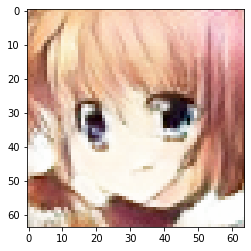

8601/12000: d_loss: 0.6885,  a_loss: 0.7744.
8602/12000: d_loss: 0.6920,  a_loss: 0.7882.
8603/12000: d_loss: 0.6919,  a_loss: 0.8075.
8604/12000: d_loss: 0.6860,  a_loss: 0.7595.
8605/12000: d_loss: 0.7043,  a_loss: 0.7630.
8606/12000: d_loss: 0.6927,  a_loss: 0.7726.
8607/12000: d_loss: 0.6920,  a_loss: 0.7821.
8608/12000: d_loss: 0.6961,  a_loss: 0.7678.
8609/12000: d_loss: 0.6840,  a_loss: 0.7976.
8610/12000: d_loss: 0.6822,  a_loss: 0.7812.
8611/12000: d_loss: 0.7179,  a_loss: 0.7350.
8612/12000: d_loss: 0.7064,  a_loss: 0.8108.
8613/12000: d_loss: 0.6957,  a_loss: 0.8344.
8614/12000: d_loss: 0.6888,  a_loss: 0.8124.
8615/12000: d_loss: 0.7028,  a_loss: 0.8389.
8616/12000: d_loss: 0.7010,  a_loss: 0.7824.
8617/12000: d_loss: 0.6868,  a_loss: 0.8028.
8618/12000: d_loss: 0.6927,  a_loss: 0.7372.
8619/12000: d_loss: 0.6868,  a_loss: 0.7994.
8620/12000: d_loss: 0.6874,  a_loss: 0.7614.
8621/12000: d_loss: 0.6962,  a_loss: 0.7815.
8622/12000: d_loss: 0.6952,  a_loss: 0.7059.
8623/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8700/12000: d_loss: 0.6897,  a_loss: 0.8554.


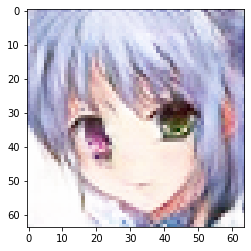

8701/12000: d_loss: 0.6963,  a_loss: 0.8042.
8702/12000: d_loss: 0.6991,  a_loss: 0.7038.
8703/12000: d_loss: 0.6837,  a_loss: 0.7667.
8704/12000: d_loss: 0.6956,  a_loss: 0.8475.
8705/12000: d_loss: 0.7022,  a_loss: 0.7522.
8706/12000: d_loss: 0.6844,  a_loss: 0.7814.
8707/12000: d_loss: 0.6803,  a_loss: 0.8338.
8708/12000: d_loss: 0.6764,  a_loss: 0.7875.
8709/12000: d_loss: 0.7165,  a_loss: 0.7528.
8710/12000: d_loss: 0.6851,  a_loss: 0.7564.
8711/12000: d_loss: 0.6765,  a_loss: 0.7890.
8712/12000: d_loss: 0.7185,  a_loss: 0.9030.
8713/12000: d_loss: 0.6802,  a_loss: 0.7482.
8714/12000: d_loss: 0.6868,  a_loss: 0.7718.
8715/12000: d_loss: 0.6809,  a_loss: 0.8021.
8716/12000: d_loss: 0.7127,  a_loss: 0.7683.
8717/12000: d_loss: 0.6994,  a_loss: 0.8090.
8718/12000: d_loss: 0.6905,  a_loss: 0.8075.
8719/12000: d_loss: 0.6969,  a_loss: 0.8487.
8720/12000: d_loss: 0.6957,  a_loss: 0.7629.
8721/12000: d_loss: 0.6892,  a_loss: 0.6909.
8722/12000: d_loss: 0.7156,  a_loss: 0.8275.
8723/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8800/12000: d_loss: 0.6928,  a_loss: 0.7689.


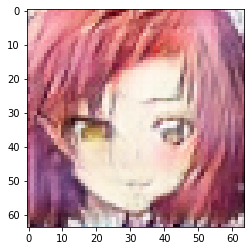

8801/12000: d_loss: 0.6878,  a_loss: 0.7896.
8802/12000: d_loss: 0.6943,  a_loss: 0.7698.
8803/12000: d_loss: 0.6737,  a_loss: 0.8145.
8804/12000: d_loss: 0.6944,  a_loss: 0.8039.
8805/12000: d_loss: 0.7046,  a_loss: 0.8424.
8806/12000: d_loss: 0.6920,  a_loss: 0.7760.
8807/12000: d_loss: 0.6830,  a_loss: 0.7803.
8808/12000: d_loss: 0.6926,  a_loss: 0.7283.
8809/12000: d_loss: 0.6856,  a_loss: 0.8818.
8810/12000: d_loss: 0.6911,  a_loss: 0.7289.
8811/12000: d_loss: 0.6839,  a_loss: 0.8140.
8812/12000: d_loss: 0.6806,  a_loss: 0.8147.
8813/12000: d_loss: 0.7085,  a_loss: 0.7907.
8814/12000: d_loss: 0.6886,  a_loss: 0.8270.
8815/12000: d_loss: 0.7069,  a_loss: 0.7673.
8816/12000: d_loss: 0.6925,  a_loss: 0.7971.
8817/12000: d_loss: 0.6818,  a_loss: 0.7474.
8818/12000: d_loss: 0.7058,  a_loss: 0.7913.
8819/12000: d_loss: 0.6944,  a_loss: 0.8116.
8820/12000: d_loss: 0.6832,  a_loss: 0.7769.
8821/12000: d_loss: 0.6797,  a_loss: 0.7876.
8822/12000: d_loss: 0.7197,  a_loss: 0.8145.
8823/12000

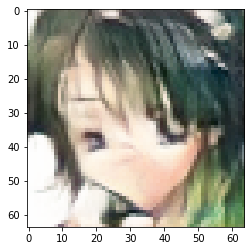

8901/12000: d_loss: 0.6862,  a_loss: 0.7999.
8902/12000: d_loss: 0.7144,  a_loss: 0.8385.
8903/12000: d_loss: 0.7001,  a_loss: 0.7897.
8904/12000: d_loss: 0.6936,  a_loss: 0.6983.
8905/12000: d_loss: 0.7145,  a_loss: 0.8521.
8906/12000: d_loss: 0.7021,  a_loss: 0.7733.
8907/12000: d_loss: 0.6906,  a_loss: 0.7963.
8908/12000: d_loss: 0.6871,  a_loss: 0.7891.
8909/12000: d_loss: 0.6956,  a_loss: 0.7594.
8910/12000: d_loss: 0.6919,  a_loss: 0.7631.
8911/12000: d_loss: 0.6907,  a_loss: 0.8728.
8912/12000: d_loss: 0.6886,  a_loss: 0.8176.
8913/12000: d_loss: 0.6810,  a_loss: 0.7658.
8914/12000: d_loss: 0.6805,  a_loss: 0.7782.
8915/12000: d_loss: 0.6998,  a_loss: 0.8439.
8916/12000: d_loss: 0.6864,  a_loss: 0.7507.
8917/12000: d_loss: 0.7092,  a_loss: 0.7488.
8918/12000: d_loss: 0.6904,  a_loss: 0.7319.
8919/12000: d_loss: 0.6938,  a_loss: 0.7941.
8920/12000: d_loss: 0.6934,  a_loss: 0.7645.
8921/12000: d_loss: 0.6898,  a_loss: 0.8014.
8922/12000: d_loss: 0.6841,  a_loss: 0.8074.
8923/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9000/12000: d_loss: 0.6818,  a_loss: 0.7593.


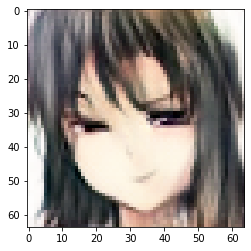

9001/12000: d_loss: 0.6900,  a_loss: 0.7979.
9002/12000: d_loss: 0.6818,  a_loss: 0.8533.
9003/12000: d_loss: 0.6958,  a_loss: 0.7280.
9004/12000: d_loss: 0.6846,  a_loss: 0.7471.
9005/12000: d_loss: 0.7162,  a_loss: 0.8033.
9006/12000: d_loss: 0.6866,  a_loss: 0.8012.
9007/12000: d_loss: 0.6997,  a_loss: 0.8025.
9008/12000: d_loss: 0.6908,  a_loss: 0.7949.
9009/12000: d_loss: 0.6832,  a_loss: 0.8019.
9010/12000: d_loss: 0.6770,  a_loss: 0.7478.
9011/12000: d_loss: 0.6880,  a_loss: 0.7832.
9012/12000: d_loss: 0.6899,  a_loss: 0.7470.
9013/12000: d_loss: 0.7028,  a_loss: 0.7969.
9014/12000: d_loss: 0.6952,  a_loss: 0.7471.
9015/12000: d_loss: 0.6737,  a_loss: 0.7075.
9016/12000: d_loss: 0.6952,  a_loss: 0.7691.
9017/12000: d_loss: 0.7068,  a_loss: 0.8379.
9018/12000: d_loss: 0.6915,  a_loss: 0.8410.
9019/12000: d_loss: 0.6830,  a_loss: 0.7921.
9020/12000: d_loss: 0.6956,  a_loss: 0.7951.
9021/12000: d_loss: 0.6880,  a_loss: 0.7596.
9022/12000: d_loss: 0.7011,  a_loss: 0.7802.
9023/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9100/12000: d_loss: 0.6844,  a_loss: 0.7445.


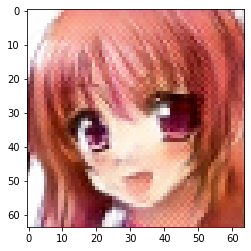

9101/12000: d_loss: 0.6965,  a_loss: 0.7780.
9102/12000: d_loss: 0.6860,  a_loss: 0.7495.
9103/12000: d_loss: 0.6826,  a_loss: 0.7298.
9104/12000: d_loss: 0.7086,  a_loss: 0.8305.
9105/12000: d_loss: 0.7212,  a_loss: 0.8201.
9106/12000: d_loss: 0.6948,  a_loss: 0.7296.
9107/12000: d_loss: 0.6990,  a_loss: 0.7711.
9108/12000: d_loss: 0.6866,  a_loss: 0.7401.
9109/12000: d_loss: 0.6830,  a_loss: 0.7186.
9110/12000: d_loss: 0.7110,  a_loss: 0.8183.
9111/12000: d_loss: 0.6752,  a_loss: 0.7845.
9112/12000: d_loss: 0.6851,  a_loss: 0.7770.
9113/12000: d_loss: 0.6993,  a_loss: 0.7756.
9114/12000: d_loss: 0.6847,  a_loss: 0.7716.
9115/12000: d_loss: 0.6893,  a_loss: 0.7762.
9116/12000: d_loss: 0.7212,  a_loss: 0.8194.
9117/12000: d_loss: 0.6971,  a_loss: 0.7476.
9118/12000: d_loss: 0.6743,  a_loss: 0.7328.
9119/12000: d_loss: 0.7225,  a_loss: 0.7995.
9120/12000: d_loss: 0.6888,  a_loss: 0.7624.
9121/12000: d_loss: 0.6959,  a_loss: 0.7636.
9122/12000: d_loss: 0.7049,  a_loss: 0.7829.
9123/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9200/12000: d_loss: 0.6842,  a_loss: 0.7699.


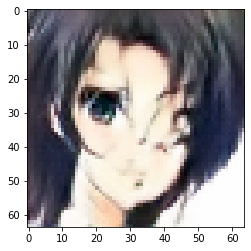

9201/12000: d_loss: 0.6928,  a_loss: 0.7493.
9202/12000: d_loss: 0.6959,  a_loss: 0.7996.
9203/12000: d_loss: 0.6871,  a_loss: 0.7676.
9204/12000: d_loss: 0.6754,  a_loss: 0.7654.
9205/12000: d_loss: 0.6827,  a_loss: 0.7639.
9206/12000: d_loss: 0.6823,  a_loss: 0.7093.
9207/12000: d_loss: 0.7020,  a_loss: 0.8653.
9208/12000: d_loss: 0.6803,  a_loss: 0.8113.
9209/12000: d_loss: 0.6972,  a_loss: 0.8213.
9210/12000: d_loss: 0.6814,  a_loss: 0.7616.
9211/12000: d_loss: 0.6915,  a_loss: 0.7605.
9212/12000: d_loss: 0.7019,  a_loss: 0.8251.
9213/12000: d_loss: 0.6863,  a_loss: 0.7381.
9214/12000: d_loss: 0.6774,  a_loss: 0.7573.
9215/12000: d_loss: 0.7053,  a_loss: 0.7873.
9216/12000: d_loss: 0.6847,  a_loss: 0.7642.
9217/12000: d_loss: 0.6995,  a_loss: 0.7925.
9218/12000: d_loss: 0.6920,  a_loss: 0.7661.
9219/12000: d_loss: 0.6887,  a_loss: 0.7361.
9220/12000: d_loss: 0.6904,  a_loss: 0.7248.
9221/12000: d_loss: 0.6962,  a_loss: 0.7966.
9222/12000: d_loss: 0.6795,  a_loss: 0.7582.
9223/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9300/12000: d_loss: 0.6800,  a_loss: 0.7806.


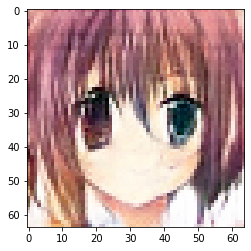

9301/12000: d_loss: 0.7033,  a_loss: 0.7537.
9302/12000: d_loss: 0.7012,  a_loss: 0.7738.
9303/12000: d_loss: 0.6881,  a_loss: 0.7733.
9304/12000: d_loss: 0.6807,  a_loss: 0.7692.
9305/12000: d_loss: 0.6828,  a_loss: 0.7351.
9306/12000: d_loss: 0.6828,  a_loss: 0.7792.
9307/12000: d_loss: 0.6906,  a_loss: 0.7968.
9308/12000: d_loss: 0.7121,  a_loss: 0.8316.
9309/12000: d_loss: 0.6869,  a_loss: 0.8286.
9310/12000: d_loss: 0.7114,  a_loss: 0.7801.
9311/12000: d_loss: 0.6933,  a_loss: 0.8003.
9312/12000: d_loss: 0.7028,  a_loss: 0.7387.
9313/12000: d_loss: 0.6786,  a_loss: 0.7253.
9314/12000: d_loss: 0.6760,  a_loss: 0.7318.
9315/12000: d_loss: 0.6906,  a_loss: 0.8128.
9316/12000: d_loss: 0.6770,  a_loss: 0.7869.
9317/12000: d_loss: 0.6928,  a_loss: 0.7211.
9318/12000: d_loss: 0.7048,  a_loss: 0.8070.
9319/12000: d_loss: 0.7042,  a_loss: 0.8475.
9320/12000: d_loss: 0.6909,  a_loss: 0.8328.
9321/12000: d_loss: 0.6887,  a_loss: 0.7992.
9322/12000: d_loss: 0.6973,  a_loss: 0.7932.
9323/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9400/12000: d_loss: 0.6866,  a_loss: 0.8091.


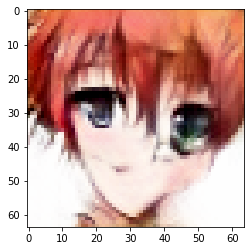

9401/12000: d_loss: 0.6891,  a_loss: 0.7882.
9402/12000: d_loss: 0.6990,  a_loss: 0.7693.
9403/12000: d_loss: 0.6929,  a_loss: 0.7854.
9404/12000: d_loss: 0.7036,  a_loss: 0.7837.
9405/12000: d_loss: 0.7011,  a_loss: 0.7954.
9406/12000: d_loss: 0.6840,  a_loss: 0.7085.
9407/12000: d_loss: 0.7029,  a_loss: 0.8802.
9408/12000: d_loss: 0.6949,  a_loss: 0.7850.
9409/12000: d_loss: 0.6954,  a_loss: 0.7905.
9410/12000: d_loss: 0.6966,  a_loss: 0.7708.
9411/12000: d_loss: 0.6900,  a_loss: 0.7708.
9412/12000: d_loss: 0.6899,  a_loss: 0.7447.
9413/12000: d_loss: 0.6835,  a_loss: 0.7902.
9414/12000: d_loss: 0.6743,  a_loss: 0.7603.
9415/12000: d_loss: 0.6898,  a_loss: 0.8841.
9416/12000: d_loss: 0.6800,  a_loss: 0.8087.
9417/12000: d_loss: 0.7086,  a_loss: 0.7809.
9418/12000: d_loss: 0.6793,  a_loss: 0.7290.
9419/12000: d_loss: 0.6787,  a_loss: 0.7732.
9420/12000: d_loss: 0.6872,  a_loss: 0.7470.
9421/12000: d_loss: 0.6827,  a_loss: 0.7925.
9422/12000: d_loss: 0.6797,  a_loss: 0.8113.
9423/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9500/12000: d_loss: 0.6897,  a_loss: 0.7564.


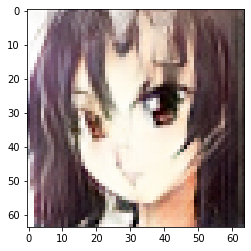

9501/12000: d_loss: 0.6824,  a_loss: 0.8016.
9502/12000: d_loss: 0.6911,  a_loss: 0.7411.
9503/12000: d_loss: 0.6954,  a_loss: 0.8368.
9504/12000: d_loss: 0.6972,  a_loss: 0.8139.
9505/12000: d_loss: 0.6692,  a_loss: 0.7447.
9506/12000: d_loss: 0.7075,  a_loss: 0.8843.
9507/12000: d_loss: 0.7179,  a_loss: 0.7533.
9508/12000: d_loss: 0.7033,  a_loss: 0.8089.
9509/12000: d_loss: 0.6902,  a_loss: 0.8026.
9510/12000: d_loss: 0.6774,  a_loss: 0.7416.
9511/12000: d_loss: 0.7034,  a_loss: 0.7375.
9512/12000: d_loss: 0.6955,  a_loss: 0.8382.
9513/12000: d_loss: 0.6788,  a_loss: 0.7508.
9514/12000: d_loss: 0.6882,  a_loss: 0.7944.
9515/12000: d_loss: 0.6892,  a_loss: 0.8267.
9516/12000: d_loss: 0.6899,  a_loss: 0.8096.
9517/12000: d_loss: 0.6916,  a_loss: 0.7700.
9518/12000: d_loss: 0.6932,  a_loss: 0.8277.
9519/12000: d_loss: 0.7008,  a_loss: 0.7572.
9520/12000: d_loss: 0.7041,  a_loss: 0.7752.
9521/12000: d_loss: 0.6914,  a_loss: 0.7537.
9522/12000: d_loss: 0.6884,  a_loss: 0.8218.
9523/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


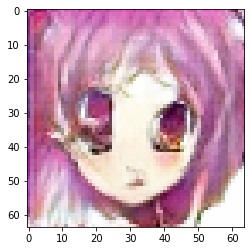

9601/12000: d_loss: 0.6997,  a_loss: 0.8378.
9602/12000: d_loss: 0.6991,  a_loss: 0.8012.
9603/12000: d_loss: 0.6963,  a_loss: 0.7765.
9604/12000: d_loss: 0.6916,  a_loss: 0.7451.
9605/12000: d_loss: 0.6781,  a_loss: 0.7247.
9606/12000: d_loss: 0.7110,  a_loss: 0.8258.
9607/12000: d_loss: 0.6833,  a_loss: 0.7583.
9608/12000: d_loss: 0.6901,  a_loss: 0.7979.
9609/12000: d_loss: 0.6988,  a_loss: 0.7778.
9610/12000: d_loss: 0.6987,  a_loss: 0.8150.
9611/12000: d_loss: 0.6929,  a_loss: 0.7752.
9612/12000: d_loss: 0.6926,  a_loss: 0.7466.
9613/12000: d_loss: 0.7051,  a_loss: 0.7998.
9614/12000: d_loss: 0.6922,  a_loss: 0.7999.
9615/12000: d_loss: 0.6967,  a_loss: 0.7651.
9616/12000: d_loss: 0.6936,  a_loss: 0.7901.
9617/12000: d_loss: 0.6939,  a_loss: 0.7714.
9618/12000: d_loss: 0.6911,  a_loss: 0.7970.
9619/12000: d_loss: 0.6968,  a_loss: 0.7568.
9620/12000: d_loss: 0.6874,  a_loss: 0.7745.
9621/12000: d_loss: 0.6845,  a_loss: 0.8090.
9622/12000: d_loss: 0.6834,  a_loss: 0.7676.
9623/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9700/12000: d_loss: 0.6953,  a_loss: 0.7435.


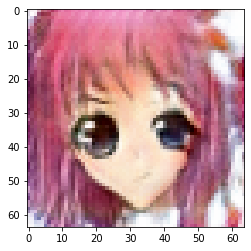

9701/12000: d_loss: 0.6858,  a_loss: 0.7649.
9702/12000: d_loss: 0.6925,  a_loss: 0.8387.
9703/12000: d_loss: 0.6849,  a_loss: 0.7949.
9704/12000: d_loss: 0.6761,  a_loss: 0.7735.
9705/12000: d_loss: 0.6820,  a_loss: 0.7442.
9706/12000: d_loss: 0.7010,  a_loss: 0.7579.
9707/12000: d_loss: 0.6859,  a_loss: 0.8155.
9708/12000: d_loss: 0.6900,  a_loss: 0.7788.
9709/12000: d_loss: 0.6802,  a_loss: 0.7775.
9710/12000: d_loss: 0.7000,  a_loss: 0.8385.
9711/12000: d_loss: 0.6917,  a_loss: 0.7640.
9712/12000: d_loss: 0.6984,  a_loss: 0.8255.
9713/12000: d_loss: 0.6938,  a_loss: 0.8098.
9714/12000: d_loss: 0.6857,  a_loss: 0.7450.
9715/12000: d_loss: 0.6808,  a_loss: 0.7791.
9716/12000: d_loss: 0.6757,  a_loss: 0.7993.
9717/12000: d_loss: 0.6855,  a_loss: 0.7583.
9718/12000: d_loss: 0.7301,  a_loss: 0.8468.
9719/12000: d_loss: 0.6990,  a_loss: 0.7975.
9720/12000: d_loss: 0.6977,  a_loss: 0.7826.
9721/12000: d_loss: 0.6930,  a_loss: 0.7174.
9722/12000: d_loss: 0.6962,  a_loss: 0.7610.
9723/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9800/12000: d_loss: 0.6895,  a_loss: 0.8137.


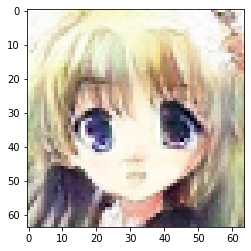

9801/12000: d_loss: 0.6829,  a_loss: 0.7959.
9802/12000: d_loss: 0.6917,  a_loss: 0.8604.
9803/12000: d_loss: 0.6884,  a_loss: 0.7782.
9804/12000: d_loss: 0.6828,  a_loss: 0.7523.
9805/12000: d_loss: 0.7007,  a_loss: 0.7678.
9806/12000: d_loss: 0.6900,  a_loss: 0.7522.
9807/12000: d_loss: 0.6926,  a_loss: 0.8341.
9808/12000: d_loss: 0.6724,  a_loss: 0.7969.
9809/12000: d_loss: 0.6891,  a_loss: 0.7407.
9810/12000: d_loss: 0.6948,  a_loss: 0.7263.
9811/12000: d_loss: 0.6874,  a_loss: 0.7714.
9812/12000: d_loss: 0.7073,  a_loss: 0.8631.
9813/12000: d_loss: 0.6917,  a_loss: 0.7841.
9814/12000: d_loss: 0.6877,  a_loss: 0.7749.
9815/12000: d_loss: 0.7032,  a_loss: 0.7748.
9816/12000: d_loss: 0.7249,  a_loss: 0.7831.
9817/12000: d_loss: 0.6983,  a_loss: 0.7656.
9818/12000: d_loss: 0.6842,  a_loss: 0.7652.
9819/12000: d_loss: 0.6970,  a_loss: 0.7612.
9820/12000: d_loss: 0.6898,  a_loss: 0.7371.
9821/12000: d_loss: 0.7070,  a_loss: 0.8718.
9822/12000: d_loss: 0.6909,  a_loss: 0.7928.
9823/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


9900/12000: d_loss: 0.6917,  a_loss: 0.7676.


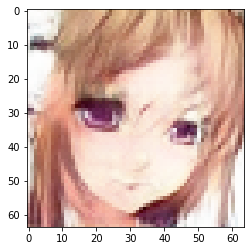

9901/12000: d_loss: 0.6850,  a_loss: 0.7667.
9902/12000: d_loss: 0.6822,  a_loss: 0.7253.
9903/12000: d_loss: 0.7071,  a_loss: 0.8039.
9904/12000: d_loss: 0.6915,  a_loss: 0.7765.
9905/12000: d_loss: 0.6794,  a_loss: 0.7314.
9906/12000: d_loss: 0.6937,  a_loss: 0.7833.
9907/12000: d_loss: 0.6932,  a_loss: 0.7399.
9908/12000: d_loss: 0.6974,  a_loss: 0.8188.
9909/12000: d_loss: 0.7008,  a_loss: 0.7728.
9910/12000: d_loss: 0.6940,  a_loss: 0.7643.
9911/12000: d_loss: 0.6909,  a_loss: 0.7683.
9912/12000: d_loss: 0.6890,  a_loss: 0.7559.
9913/12000: d_loss: 0.6921,  a_loss: 0.7522.
9914/12000: d_loss: 0.6916,  a_loss: 0.7137.
9915/12000: d_loss: 0.6936,  a_loss: 0.8350.
9916/12000: d_loss: 0.6985,  a_loss: 0.7871.
9917/12000: d_loss: 0.7074,  a_loss: 0.8230.
9918/12000: d_loss: 0.6865,  a_loss: 0.7852.
9919/12000: d_loss: 0.6955,  a_loss: 0.8163.
9920/12000: d_loss: 0.6856,  a_loss: 0.7158.
9921/12000: d_loss: 0.6878,  a_loss: 0.7860.
9922/12000: d_loss: 0.6926,  a_loss: 0.7815.
9923/12000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10000/12000: d_loss: 0.6934,  a_loss: 0.8201.


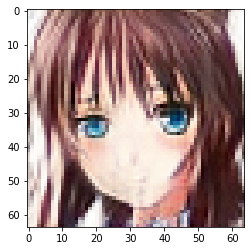

10001/12000: d_loss: 0.6844,  a_loss: 0.7157.
10002/12000: d_loss: 0.7059,  a_loss: 0.8124.
10003/12000: d_loss: 0.6973,  a_loss: 0.8327.
10004/12000: d_loss: 0.6850,  a_loss: 0.7806.
10005/12000: d_loss: 0.6938,  a_loss: 0.7860.
10006/12000: d_loss: 0.6895,  a_loss: 0.7219.
10007/12000: d_loss: 0.7165,  a_loss: 0.8635.
10008/12000: d_loss: 0.6972,  a_loss: 0.7752.
10009/12000: d_loss: 0.6923,  a_loss: 0.7445.
10010/12000: d_loss: 0.6938,  a_loss: 0.7422.
10011/12000: d_loss: 0.6943,  a_loss: 0.7700.
10012/12000: d_loss: 0.6790,  a_loss: 0.7739.
10013/12000: d_loss: 0.7046,  a_loss: 0.8169.
10014/12000: d_loss: 0.7106,  a_loss: 0.7864.
10015/12000: d_loss: 0.6834,  a_loss: 0.7884.
10016/12000: d_loss: 0.6915,  a_loss: 0.7300.
10017/12000: d_loss: 0.6990,  a_loss: 0.7785.
10018/12000: d_loss: 0.6872,  a_loss: 0.7623.
10019/12000: d_loss: 0.6952,  a_loss: 0.8008.
10020/12000: d_loss: 0.6916,  a_loss: 0.7796.
10021/12000: d_loss: 0.6800,  a_loss: 0.7787.
10022/12000: d_loss: 0.6815,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10100/12000: d_loss: 0.6905,  a_loss: 0.7687.


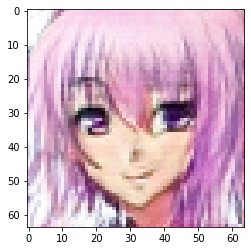

10101/12000: d_loss: 0.7029,  a_loss: 0.7998.
10102/12000: d_loss: 0.6859,  a_loss: 0.7804.
10103/12000: d_loss: 0.7025,  a_loss: 0.7860.
10104/12000: d_loss: 0.6848,  a_loss: 0.7195.
10105/12000: d_loss: 0.6944,  a_loss: 0.8079.
10106/12000: d_loss: 0.7022,  a_loss: 0.7886.
10107/12000: d_loss: 0.7016,  a_loss: 0.7425.
10108/12000: d_loss: 0.6964,  a_loss: 0.8489.
10109/12000: d_loss: 0.6952,  a_loss: 0.7997.
10110/12000: d_loss: 0.6888,  a_loss: 0.7737.
10111/12000: d_loss: 0.6929,  a_loss: 0.7737.
10112/12000: d_loss: 0.7075,  a_loss: 0.7657.
10113/12000: d_loss: 0.6841,  a_loss: 0.7717.
10114/12000: d_loss: 0.6898,  a_loss: 0.7219.
10115/12000: d_loss: 0.6978,  a_loss: 0.8389.
10116/12000: d_loss: 0.7093,  a_loss: 0.7598.
10117/12000: d_loss: 0.6757,  a_loss: 0.7571.
10118/12000: d_loss: 0.6972,  a_loss: 0.7853.
10119/12000: d_loss: 0.6972,  a_loss: 0.7745.
10120/12000: d_loss: 0.6875,  a_loss: 0.7386.
10121/12000: d_loss: 0.6975,  a_loss: 0.7567.
10122/12000: d_loss: 0.6886,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10200/12000: d_loss: 0.6900,  a_loss: 0.7534.


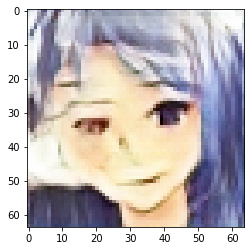

10201/12000: d_loss: 0.6971,  a_loss: 0.7807.
10202/12000: d_loss: 0.6797,  a_loss: 0.7456.
10203/12000: d_loss: 0.6984,  a_loss: 0.7849.
10204/12000: d_loss: 0.6913,  a_loss: 0.7942.
10205/12000: d_loss: 0.7040,  a_loss: 0.7578.
10206/12000: d_loss: 0.6964,  a_loss: 0.8013.
10207/12000: d_loss: 0.6916,  a_loss: 0.7738.
10208/12000: d_loss: 0.6763,  a_loss: 0.7768.
10209/12000: d_loss: 0.6962,  a_loss: 0.7735.
10210/12000: d_loss: 0.6846,  a_loss: 0.7246.
10211/12000: d_loss: 0.6969,  a_loss: 0.8478.
10212/12000: d_loss: 0.6814,  a_loss: 0.7648.
10213/12000: d_loss: 0.7125,  a_loss: 0.7704.
10214/12000: d_loss: 0.6857,  a_loss: 0.7268.
10215/12000: d_loss: 0.6976,  a_loss: 0.8219.
10216/12000: d_loss: 0.6870,  a_loss: 0.7888.
10217/12000: d_loss: 0.6934,  a_loss: 0.7677.
10218/12000: d_loss: 0.6990,  a_loss: 0.9060.
10219/12000: d_loss: 0.7045,  a_loss: 0.7842.
10220/12000: d_loss: 0.6737,  a_loss: 0.7728.
10221/12000: d_loss: 0.6921,  a_loss: 0.7660.
10222/12000: d_loss: 0.6969,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10300/12000: d_loss: 0.6922,  a_loss: 0.7599.


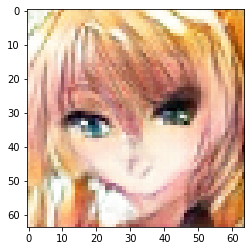

10301/12000: d_loss: 0.6858,  a_loss: 0.7782.
10302/12000: d_loss: 0.7004,  a_loss: 0.7758.
10303/12000: d_loss: 0.6844,  a_loss: 0.7959.
10304/12000: d_loss: 0.6859,  a_loss: 0.7960.
10305/12000: d_loss: 0.6920,  a_loss: 0.8265.
10306/12000: d_loss: 0.6816,  a_loss: 0.7405.
10307/12000: d_loss: 0.6992,  a_loss: 0.8104.
10308/12000: d_loss: 0.6877,  a_loss: 0.7628.
10309/12000: d_loss: 0.6972,  a_loss: 0.7455.
10310/12000: d_loss: 0.6950,  a_loss: 0.7782.
10311/12000: d_loss: 0.6949,  a_loss: 0.7265.
10312/12000: d_loss: 0.7190,  a_loss: 0.8160.
10313/12000: d_loss: 0.6898,  a_loss: 0.7756.
10314/12000: d_loss: 0.7086,  a_loss: 0.7577.
10315/12000: d_loss: 0.7058,  a_loss: 0.8043.
10316/12000: d_loss: 0.6908,  a_loss: 0.7723.
10317/12000: d_loss: 0.6863,  a_loss: 0.7616.
10318/12000: d_loss: 0.6879,  a_loss: 0.7292.
10319/12000: d_loss: 0.6893,  a_loss: 0.8072.
10320/12000: d_loss: 0.6954,  a_loss: 0.7841.
10321/12000: d_loss: 0.6831,  a_loss: 0.7128.
10322/12000: d_loss: 0.6890,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10400/12000: d_loss: 0.6949,  a_loss: 0.7551.


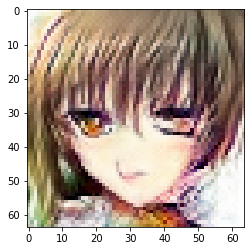

10401/12000: d_loss: 0.6896,  a_loss: 0.7411.
10402/12000: d_loss: 0.6917,  a_loss: 0.8096.
10403/12000: d_loss: 0.6952,  a_loss: 0.8208.
10404/12000: d_loss: 0.6806,  a_loss: 0.7615.
10405/12000: d_loss: 0.6792,  a_loss: 0.7647.
10406/12000: d_loss: 0.6810,  a_loss: 0.7752.
10407/12000: d_loss: 0.6954,  a_loss: 0.7995.
10408/12000: d_loss: 0.6838,  a_loss: 0.7493.
10409/12000: d_loss: 0.7068,  a_loss: 0.7197.
10410/12000: d_loss: 0.6816,  a_loss: 0.7429.
10411/12000: d_loss: 0.7101,  a_loss: 0.7727.
10412/12000: d_loss: 0.6890,  a_loss: 0.8446.
10413/12000: d_loss: 0.6874,  a_loss: 0.7490.
10414/12000: d_loss: 0.6646,  a_loss: 0.7480.
10415/12000: d_loss: 0.6870,  a_loss: 0.8985.
10416/12000: d_loss: 0.6828,  a_loss: 0.7770.
10417/12000: d_loss: 0.7083,  a_loss: 0.8623.
10418/12000: d_loss: 0.6997,  a_loss: 0.7619.
10419/12000: d_loss: 0.7031,  a_loss: 0.8033.
10420/12000: d_loss: 0.6873,  a_loss: 0.8061.
10421/12000: d_loss: 0.6920,  a_loss: 0.7403.
10422/12000: d_loss: 0.6955,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10500/12000: d_loss: 0.6898,  a_loss: 0.8278.


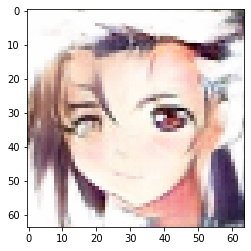

10501/12000: d_loss: 0.6858,  a_loss: 0.7802.
10502/12000: d_loss: 0.7044,  a_loss: 0.8066.
10503/12000: d_loss: 0.6856,  a_loss: 0.8378.
10504/12000: d_loss: 0.6878,  a_loss: 0.8034.
10505/12000: d_loss: 0.6776,  a_loss: 0.7646.
10506/12000: d_loss: 0.6868,  a_loss: 0.8290.
10507/12000: d_loss: 0.6849,  a_loss: 0.8243.
10508/12000: d_loss: 0.6923,  a_loss: 0.7796.
10509/12000: d_loss: 0.6898,  a_loss: 0.6546.
10510/12000: d_loss: 0.7080,  a_loss: 0.8782.
10511/12000: d_loss: 0.7060,  a_loss: 0.7581.
10512/12000: d_loss: 0.6912,  a_loss: 0.8107.
10513/12000: d_loss: 0.6731,  a_loss: 0.7058.
10514/12000: d_loss: 0.7137,  a_loss: 0.8542.
10515/12000: d_loss: 0.6927,  a_loss: 0.7635.
10516/12000: d_loss: 0.7011,  a_loss: 0.8108.
10517/12000: d_loss: 0.6728,  a_loss: 0.7656.
10518/12000: d_loss: 0.6988,  a_loss: 0.8255.
10519/12000: d_loss: 0.6806,  a_loss: 0.7599.
10520/12000: d_loss: 0.6912,  a_loss: 0.7455.
10521/12000: d_loss: 0.6975,  a_loss: 0.8043.
10522/12000: d_loss: 0.6933,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10600/12000: d_loss: 0.6952,  a_loss: 0.7653.


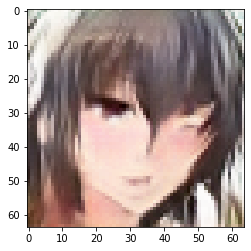

10601/12000: d_loss: 0.6962,  a_loss: 0.8555.
10602/12000: d_loss: 0.6980,  a_loss: 0.7479.
10603/12000: d_loss: 0.6950,  a_loss: 0.7792.
10604/12000: d_loss: 0.6958,  a_loss: 0.7269.
10605/12000: d_loss: 0.6957,  a_loss: 0.7934.
10606/12000: d_loss: 0.6825,  a_loss: 0.8248.
10607/12000: d_loss: 0.7051,  a_loss: 0.7769.
10608/12000: d_loss: 0.6736,  a_loss: 0.7807.
10609/12000: d_loss: 0.6960,  a_loss: 0.7866.
10610/12000: d_loss: 0.6882,  a_loss: 0.8057.
10611/12000: d_loss: 0.6891,  a_loss: 0.8321.
10612/12000: d_loss: 0.6933,  a_loss: 0.7857.
10613/12000: d_loss: 0.7065,  a_loss: 0.7661.
10614/12000: d_loss: 0.6903,  a_loss: 0.7635.
10615/12000: d_loss: 0.6829,  a_loss: 0.7869.
10616/12000: d_loss: 0.6787,  a_loss: 0.7570.
10617/12000: d_loss: 0.6822,  a_loss: 0.8174.
10618/12000: d_loss: 0.6984,  a_loss: 0.7793.
10619/12000: d_loss: 0.6841,  a_loss: 0.8132.
10620/12000: d_loss: 0.7054,  a_loss: 0.7333.
10621/12000: d_loss: 0.7072,  a_loss: 0.8123.
10622/12000: d_loss: 0.7110,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10700/12000: d_loss: 0.6739,  a_loss: 0.7583.


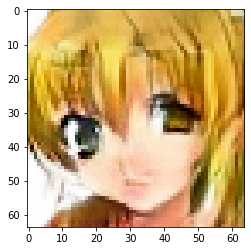

10701/12000: d_loss: 0.6784,  a_loss: 0.7457.
10702/12000: d_loss: 0.7111,  a_loss: 0.7806.
10703/12000: d_loss: 0.6904,  a_loss: 0.6845.
10704/12000: d_loss: 0.7081,  a_loss: 0.8929.
10705/12000: d_loss: 0.6923,  a_loss: 0.7356.
10706/12000: d_loss: 0.6963,  a_loss: 0.8258.
10707/12000: d_loss: 0.6824,  a_loss: 0.7493.
10708/12000: d_loss: 0.6785,  a_loss: 0.7613.
10709/12000: d_loss: 0.6832,  a_loss: 0.8174.
10710/12000: d_loss: 0.6906,  a_loss: 0.7747.
10711/12000: d_loss: 0.6797,  a_loss: 0.7666.
10712/12000: d_loss: 0.6969,  a_loss: 0.7582.
10713/12000: d_loss: 0.6925,  a_loss: 0.7073.
10714/12000: d_loss: 0.6853,  a_loss: 0.7745.
10715/12000: d_loss: 0.6851,  a_loss: 0.8198.
10716/12000: d_loss: 0.6806,  a_loss: 0.7701.
10717/12000: d_loss: 0.6898,  a_loss: 0.8395.
10718/12000: d_loss: 0.7216,  a_loss: 0.8280.
10719/12000: d_loss: 0.6965,  a_loss: 0.7359.
10720/12000: d_loss: 0.6870,  a_loss: 0.7826.
10721/12000: d_loss: 0.6784,  a_loss: 0.7827.
10722/12000: d_loss: 0.6865,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10800/12000: d_loss: 0.6767,  a_loss: 0.7894.


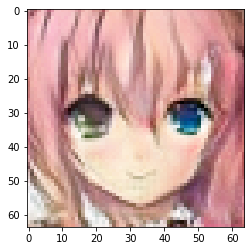

10801/12000: d_loss: 0.6870,  a_loss: 0.7809.
10802/12000: d_loss: 0.6674,  a_loss: 0.7728.
10803/12000: d_loss: 0.6655,  a_loss: 0.8035.
10804/12000: d_loss: 0.7073,  a_loss: 0.9301.
10805/12000: d_loss: 0.6947,  a_loss: 0.7843.
10806/12000: d_loss: 0.7017,  a_loss: 0.7831.
10807/12000: d_loss: 0.7025,  a_loss: 0.7418.
10808/12000: d_loss: 0.6951,  a_loss: 0.7283.
10809/12000: d_loss: 0.6959,  a_loss: 0.7170.
10810/12000: d_loss: 0.7025,  a_loss: 0.8337.
10811/12000: d_loss: 0.6896,  a_loss: 0.7480.
10812/12000: d_loss: 0.6975,  a_loss: 0.7361.
10813/12000: d_loss: 0.6968,  a_loss: 0.8031.
10814/12000: d_loss: 0.6870,  a_loss: 0.8207.
10815/12000: d_loss: 0.6985,  a_loss: 0.7827.
10816/12000: d_loss: 0.6831,  a_loss: 0.7047.
10817/12000: d_loss: 0.6975,  a_loss: 0.7966.
10818/12000: d_loss: 0.7081,  a_loss: 0.8252.
10819/12000: d_loss: 0.6764,  a_loss: 0.7880.
10820/12000: d_loss: 0.6969,  a_loss: 0.7692.
10821/12000: d_loss: 0.7065,  a_loss: 0.7852.
10822/12000: d_loss: 0.6904,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


10900/12000: d_loss: 0.6884,  a_loss: 0.8067.


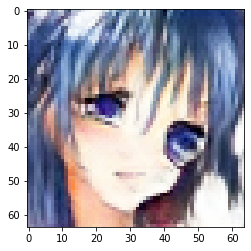

10901/12000: d_loss: 0.6979,  a_loss: 0.7874.
10902/12000: d_loss: 0.6839,  a_loss: 0.7540.
10903/12000: d_loss: 0.6965,  a_loss: 0.7489.
10904/12000: d_loss: 0.6999,  a_loss: 0.7477.
10905/12000: d_loss: 0.6901,  a_loss: 0.7635.
10906/12000: d_loss: 0.6986,  a_loss: 0.7386.
10907/12000: d_loss: 0.6922,  a_loss: 0.8650.
10908/12000: d_loss: 0.7018,  a_loss: 0.7527.
10909/12000: d_loss: 0.6994,  a_loss: 0.7395.
10910/12000: d_loss: 0.6892,  a_loss: 0.7508.
10911/12000: d_loss: 0.6860,  a_loss: 0.7977.
10912/12000: d_loss: 0.6930,  a_loss: 0.7581.
10913/12000: d_loss: 0.7080,  a_loss: 0.8232.
10914/12000: d_loss: 0.6929,  a_loss: 0.7436.
10915/12000: d_loss: 0.6887,  a_loss: 0.7146.
10916/12000: d_loss: 0.6886,  a_loss: 0.7820.
10917/12000: d_loss: 0.7006,  a_loss: 0.8259.
10918/12000: d_loss: 0.6919,  a_loss: 0.7328.
10919/12000: d_loss: 0.6907,  a_loss: 0.8223.
10920/12000: d_loss: 0.6912,  a_loss: 0.7619.
10921/12000: d_loss: 0.6948,  a_loss: 0.7613.
10922/12000: d_loss: 0.7060,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11000/12000: d_loss: 0.6853,  a_loss: 0.7590.


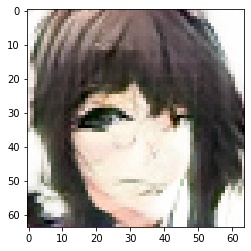

11001/12000: d_loss: 0.6919,  a_loss: 0.8435.
11002/12000: d_loss: 0.6864,  a_loss: 0.7407.
11003/12000: d_loss: 0.7003,  a_loss: 0.7830.
11004/12000: d_loss: 0.6778,  a_loss: 0.7346.
11005/12000: d_loss: 0.7168,  a_loss: 0.9429.
11006/12000: d_loss: 0.7136,  a_loss: 0.7421.
11007/12000: d_loss: 0.6747,  a_loss: 0.7633.
11008/12000: d_loss: 0.6773,  a_loss: 0.8105.
11009/12000: d_loss: 0.6945,  a_loss: 0.8731.
11010/12000: d_loss: 0.6897,  a_loss: 0.7607.
11011/12000: d_loss: 0.6722,  a_loss: 0.8167.
11012/12000: d_loss: 0.6816,  a_loss: 0.7595.
11013/12000: d_loss: 0.6835,  a_loss: 0.8345.
11014/12000: d_loss: 0.6921,  a_loss: 0.7585.
11015/12000: d_loss: 0.6884,  a_loss: 0.7861.
11016/12000: d_loss: 0.6893,  a_loss: 0.7001.
11017/12000: d_loss: 0.7092,  a_loss: 0.8222.
11018/12000: d_loss: 0.7114,  a_loss: 0.8728.
11019/12000: d_loss: 0.6756,  a_loss: 0.8176.
11020/12000: d_loss: 0.6816,  a_loss: 0.7973.
11021/12000: d_loss: 0.6981,  a_loss: 0.8004.
11022/12000: d_loss: 0.6842,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11100/12000: d_loss: 0.6869,  a_loss: 0.7927.


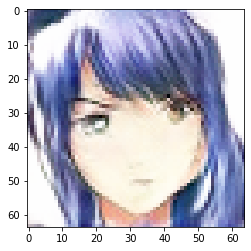

11101/12000: d_loss: 0.7045,  a_loss: 0.7785.
11102/12000: d_loss: 0.6863,  a_loss: 0.7214.
11103/12000: d_loss: 0.6835,  a_loss: 0.8191.
11104/12000: d_loss: 0.7054,  a_loss: 0.7428.
11105/12000: d_loss: 0.6828,  a_loss: 0.7936.
11106/12000: d_loss: 0.6935,  a_loss: 0.8066.
11107/12000: d_loss: 0.7028,  a_loss: 0.7265.
11108/12000: d_loss: 0.6943,  a_loss: 0.7574.
11109/12000: d_loss: 0.6936,  a_loss: 0.7563.
11110/12000: d_loss: 0.6855,  a_loss: 0.8227.
11111/12000: d_loss: 0.6829,  a_loss: 0.8084.
11112/12000: d_loss: 0.6853,  a_loss: 0.8228.
11113/12000: d_loss: 0.6775,  a_loss: 0.7509.
11114/12000: d_loss: 0.6984,  a_loss: 0.7917.
11115/12000: d_loss: 0.6870,  a_loss: 0.7860.
11116/12000: d_loss: 0.6877,  a_loss: 0.7505.
11117/12000: d_loss: 0.6959,  a_loss: 0.8644.
11118/12000: d_loss: 0.6825,  a_loss: 0.8004.
11119/12000: d_loss: 0.6878,  a_loss: 0.7464.
11120/12000: d_loss: 0.7020,  a_loss: 0.8987.
11121/12000: d_loss: 0.6783,  a_loss: 0.7918.
11122/12000: d_loss: 0.6864,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11200/12000: d_loss: 0.6854,  a_loss: 0.7772.


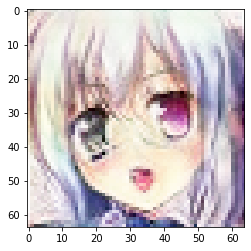

11201/12000: d_loss: 0.6828,  a_loss: 0.7471.
11202/12000: d_loss: 0.7094,  a_loss: 0.8091.
11203/12000: d_loss: 0.6945,  a_loss: 0.7440.
11204/12000: d_loss: 0.7049,  a_loss: 0.8623.
11205/12000: d_loss: 0.6834,  a_loss: 0.7513.
11206/12000: d_loss: 0.6919,  a_loss: 0.7064.
11207/12000: d_loss: 0.6791,  a_loss: 0.7482.
11208/12000: d_loss: 0.6910,  a_loss: 0.7692.
11209/12000: d_loss: 0.6929,  a_loss: 0.8452.
11210/12000: d_loss: 0.6969,  a_loss: 0.7650.
11211/12000: d_loss: 0.6879,  a_loss: 0.8298.
11212/12000: d_loss: 0.6825,  a_loss: 0.7718.
11213/12000: d_loss: 0.6936,  a_loss: 0.7933.
11214/12000: d_loss: 0.7070,  a_loss: 0.7433.
11215/12000: d_loss: 0.7075,  a_loss: 0.7215.
11216/12000: d_loss: 0.6895,  a_loss: 0.7037.
11217/12000: d_loss: 0.6937,  a_loss: 0.7943.
11218/12000: d_loss: 0.6726,  a_loss: 0.8143.
11219/12000: d_loss: 0.6934,  a_loss: 0.7487.
11220/12000: d_loss: 0.6673,  a_loss: 0.5573.
11221/12000: d_loss: 0.8015,  a_loss: 0.9353.
11222/12000: d_loss: 0.6883,  a_lo

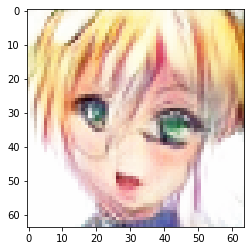

11301/12000: d_loss: 0.6827,  a_loss: 0.7170.
11302/12000: d_loss: 0.6914,  a_loss: 0.8136.
11303/12000: d_loss: 0.6914,  a_loss: 0.8018.
11304/12000: d_loss: 0.6907,  a_loss: 0.7721.
11305/12000: d_loss: 0.6858,  a_loss: 0.7614.
11306/12000: d_loss: 0.7023,  a_loss: 0.8644.
11307/12000: d_loss: 0.7025,  a_loss: 0.7874.
11308/12000: d_loss: 0.6977,  a_loss: 0.8045.
11309/12000: d_loss: 0.6728,  a_loss: 0.7555.
11310/12000: d_loss: 0.6929,  a_loss: 0.7639.
11311/12000: d_loss: 0.6840,  a_loss: 0.8264.
11312/12000: d_loss: 0.6883,  a_loss: 0.8298.
11313/12000: d_loss: 0.6764,  a_loss: 0.8353.
11314/12000: d_loss: 0.7088,  a_loss: 0.7469.
11315/12000: d_loss: 0.6932,  a_loss: 0.7248.
11316/12000: d_loss: 0.7019,  a_loss: 0.8277.
11317/12000: d_loss: 0.6766,  a_loss: 0.7203.
11318/12000: d_loss: 0.6844,  a_loss: 0.8521.
11319/12000: d_loss: 0.6801,  a_loss: 0.8077.
11320/12000: d_loss: 0.7059,  a_loss: 0.8050.
11321/12000: d_loss: 0.6904,  a_loss: 0.7626.
11322/12000: d_loss: 0.6855,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11400/12000: d_loss: 0.6849,  a_loss: 0.7593.


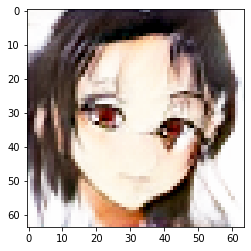

11401/12000: d_loss: 0.7112,  a_loss: 0.8704.
11402/12000: d_loss: 0.7052,  a_loss: 0.7625.
11403/12000: d_loss: 0.6894,  a_loss: 0.7441.
11404/12000: d_loss: 0.6952,  a_loss: 0.7770.
11405/12000: d_loss: 0.7047,  a_loss: 0.8296.
11406/12000: d_loss: 0.6876,  a_loss: 0.7629.
11407/12000: d_loss: 0.6715,  a_loss: 0.7256.
11408/12000: d_loss: 0.6859,  a_loss: 0.7667.
11409/12000: d_loss: 0.6795,  a_loss: 0.7185.
11410/12000: d_loss: 0.7049,  a_loss: 0.8384.
11411/12000: d_loss: 0.6906,  a_loss: 0.7566.
11412/12000: d_loss: 0.6898,  a_loss: 0.7317.
11413/12000: d_loss: 0.7217,  a_loss: 0.8417.
11414/12000: d_loss: 0.6885,  a_loss: 0.7943.
11415/12000: d_loss: 0.6891,  a_loss: 0.7764.
11416/12000: d_loss: 0.7043,  a_loss: 0.7663.
11417/12000: d_loss: 0.6897,  a_loss: 0.8189.
11418/12000: d_loss: 0.6958,  a_loss: 0.7390.
11419/12000: d_loss: 0.6950,  a_loss: 0.7582.
11420/12000: d_loss: 0.6843,  a_loss: 0.8424.
11421/12000: d_loss: 0.7003,  a_loss: 0.7750.
11422/12000: d_loss: 0.6880,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11500/12000: d_loss: 0.6878,  a_loss: 0.7663.


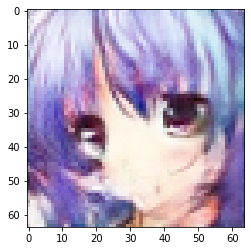

11501/12000: d_loss: 0.6893,  a_loss: 0.7790.
11502/12000: d_loss: 0.6974,  a_loss: 0.7664.
11503/12000: d_loss: 0.7056,  a_loss: 0.8051.
11504/12000: d_loss: 0.6678,  a_loss: 0.7599.
11505/12000: d_loss: 0.6840,  a_loss: 0.7526.
11506/12000: d_loss: 0.7035,  a_loss: 0.8370.
11507/12000: d_loss: 0.7021,  a_loss: 0.7710.
11508/12000: d_loss: 0.6992,  a_loss: 0.8127.
11509/12000: d_loss: 0.6878,  a_loss: 0.7715.
11510/12000: d_loss: 0.6841,  a_loss: 0.7349.
11511/12000: d_loss: 0.6954,  a_loss: 0.7608.
11512/12000: d_loss: 0.6766,  a_loss: 0.7082.
11513/12000: d_loss: 0.6818,  a_loss: 0.8821.
11514/12000: d_loss: 0.6830,  a_loss: 0.8201.
11515/12000: d_loss: 0.6885,  a_loss: 0.8085.
11516/12000: d_loss: 0.6824,  a_loss: 0.8255.
11517/12000: d_loss: 0.6955,  a_loss: 0.8087.
11518/12000: d_loss: 0.6834,  a_loss: 0.8298.
11519/12000: d_loss: 0.6807,  a_loss: 0.8180.
11520/12000: d_loss: 0.6854,  a_loss: 0.7537.
11521/12000: d_loss: 0.7043,  a_loss: 0.8278.
11522/12000: d_loss: 0.7049,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11600/12000: d_loss: 0.6979,  a_loss: 0.7763.


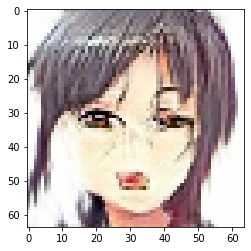

11601/12000: d_loss: 0.6847,  a_loss: 0.7581.
11602/12000: d_loss: 0.7063,  a_loss: 0.8332.
11603/12000: d_loss: 0.6892,  a_loss: 0.7856.
11604/12000: d_loss: 0.6809,  a_loss: 0.7823.
11605/12000: d_loss: 0.6886,  a_loss: 0.8061.
11606/12000: d_loss: 0.6954,  a_loss: 0.7295.
11607/12000: d_loss: 0.7027,  a_loss: 0.8131.
11608/12000: d_loss: 0.6804,  a_loss: 0.7437.
11609/12000: d_loss: 0.6947,  a_loss: 0.7360.
11610/12000: d_loss: 0.6820,  a_loss: 0.7953.
11611/12000: d_loss: 0.6899,  a_loss: 0.7590.
11612/12000: d_loss: 0.6849,  a_loss: 0.7934.
11613/12000: d_loss: 0.6878,  a_loss: 0.8253.
11614/12000: d_loss: 0.6964,  a_loss: 0.7216.
11615/12000: d_loss: 0.6917,  a_loss: 0.8526.
11616/12000: d_loss: 0.7105,  a_loss: 0.7956.
11617/12000: d_loss: 0.6920,  a_loss: 0.7329.
11618/12000: d_loss: 0.6798,  a_loss: 0.7922.
11619/12000: d_loss: 0.6836,  a_loss: 0.7678.
11620/12000: d_loss: 0.6811,  a_loss: 0.6837.
11621/12000: d_loss: 0.7099,  a_loss: 0.8866.
11622/12000: d_loss: 0.6901,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11700/12000: d_loss: 0.7057,  a_loss: 0.7471.


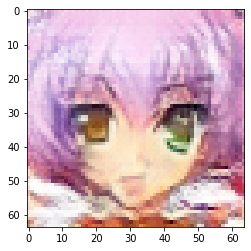

11701/12000: d_loss: 0.6755,  a_loss: 0.7493.
11702/12000: d_loss: 0.6864,  a_loss: 0.7557.
11703/12000: d_loss: 0.6803,  a_loss: 0.8023.
11704/12000: d_loss: 0.7002,  a_loss: 0.8026.
11705/12000: d_loss: 0.7047,  a_loss: 0.7776.
11706/12000: d_loss: 0.6967,  a_loss: 0.7528.
11707/12000: d_loss: 0.6874,  a_loss: 0.7711.
11708/12000: d_loss: 0.6885,  a_loss: 0.7671.
11709/12000: d_loss: 0.7012,  a_loss: 0.8575.
11710/12000: d_loss: 0.6885,  a_loss: 0.7347.
11711/12000: d_loss: 0.7186,  a_loss: 0.8951.
11712/12000: d_loss: 0.7146,  a_loss: 0.7670.
11713/12000: d_loss: 0.6723,  a_loss: 0.7694.
11714/12000: d_loss: 0.6833,  a_loss: 0.7590.
11715/12000: d_loss: 0.7070,  a_loss: 0.8143.
11716/12000: d_loss: 0.6862,  a_loss: 0.7503.
11717/12000: d_loss: 0.7096,  a_loss: 0.8573.
11718/12000: d_loss: 0.6858,  a_loss: 0.7868.
11719/12000: d_loss: 0.6952,  a_loss: 0.7801.
11720/12000: d_loss: 0.6768,  a_loss: 0.7475.
11721/12000: d_loss: 0.6985,  a_loss: 0.7709.
11722/12000: d_loss: 0.6904,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11800/12000: d_loss: 0.6972,  a_loss: 0.7402.


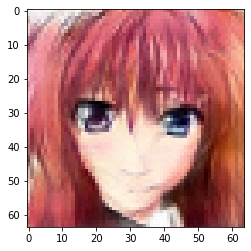

11801/12000: d_loss: 0.6971,  a_loss: 0.8250.
11802/12000: d_loss: 0.6838,  a_loss: 0.8227.
11803/12000: d_loss: 0.6970,  a_loss: 0.7664.
11804/12000: d_loss: 0.6975,  a_loss: 0.7897.
11805/12000: d_loss: 0.6958,  a_loss: 0.7950.
11806/12000: d_loss: 0.6968,  a_loss: 0.7706.
11807/12000: d_loss: 0.6789,  a_loss: 0.7754.
11808/12000: d_loss: 0.6774,  a_loss: 0.7576.
11809/12000: d_loss: 0.7079,  a_loss: 0.7583.
11810/12000: d_loss: 0.7160,  a_loss: 0.8173.
11811/12000: d_loss: 0.7030,  a_loss: 0.7701.
11812/12000: d_loss: 0.6918,  a_loss: 0.6989.
11813/12000: d_loss: 0.6874,  a_loss: 0.7587.
11814/12000: d_loss: 0.6916,  a_loss: 0.7373.
11815/12000: d_loss: 0.6876,  a_loss: 0.8076.
11816/12000: d_loss: 0.7012,  a_loss: 0.7557.
11817/12000: d_loss: 0.6807,  a_loss: 0.7707.
11818/12000: d_loss: 0.7046,  a_loss: 0.8495.
11819/12000: d_loss: 0.6947,  a_loss: 0.7601.
11820/12000: d_loss: 0.6930,  a_loss: 0.7453.
11821/12000: d_loss: 0.6975,  a_loss: 0.7547.
11822/12000: d_loss: 0.7030,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


11900/12000: d_loss: 0.6828,  a_loss: 0.7791.


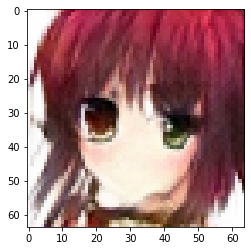

11901/12000: d_loss: 0.6940,  a_loss: 0.7903.
11902/12000: d_loss: 0.6803,  a_loss: 0.7761.
11903/12000: d_loss: 0.6771,  a_loss: 0.7767.
11904/12000: d_loss: 0.6931,  a_loss: 0.7983.
11905/12000: d_loss: 0.6791,  a_loss: 0.8105.
11906/12000: d_loss: 0.6866,  a_loss: 0.7907.
11907/12000: d_loss: 0.6817,  a_loss: 0.8101.
11908/12000: d_loss: 0.6846,  a_loss: 0.7125.
11909/12000: d_loss: 0.6770,  a_loss: 0.8293.
11910/12000: d_loss: 0.7156,  a_loss: 0.7925.
11911/12000: d_loss: 0.6906,  a_loss: 0.8109.
11912/12000: d_loss: 0.6975,  a_loss: 0.7811.
11913/12000: d_loss: 0.6971,  a_loss: 0.7989.
11914/12000: d_loss: 0.6830,  a_loss: 0.7875.
11915/12000: d_loss: 0.6932,  a_loss: 0.7794.
11916/12000: d_loss: 0.6874,  a_loss: 0.7985.
11917/12000: d_loss: 0.7027,  a_loss: 0.7221.
11918/12000: d_loss: 0.6970,  a_loss: 0.7894.
11919/12000: d_loss: 0.7155,  a_loss: 0.9120.
11920/12000: d_loss: 0.7032,  a_loss: 0.7245.
11921/12000: d_loss: 0.6913,  a_loss: 0.7537.
11922/12000: d_loss: 0.6960,  a_lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


12000/12000: d_loss: 0.6910,  a_loss: 0.7657.


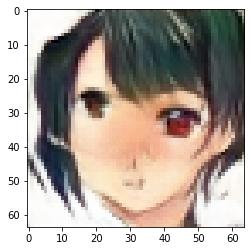

In [20]:
iters = 12000
batch_size = 16

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
start = 0
d_losses = []
a_losses = []
images_saved = 0

WIDTH = image_dim[0]
HEIGHT = image_dim[1]
CHANNELS = image_dim[2]

for step in range(iters):
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)
    
    real = data[start:start + batch_size]

    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    
    start += batch_size
    if start > data.shape[0] - batch_size:
        start = 0
    
    %matplotlib inline
    if step % 100 == 99:  
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.' % (step + 1, iters, d_loss, a_loss))
        start_time=time.time()
        plt.imshow(cv2.cvtColor(generated[0], cv2.COLOR_BGR2RGB))
        plt.show()
    else:
        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.' % (step + 1, iters, d_loss, a_loss))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


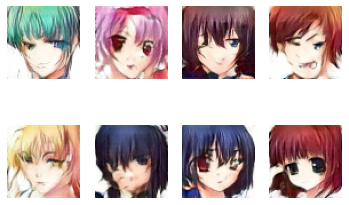

In [34]:
%matplotlib inline
r, c = 2, 4
latent_vectors = np.random.normal(size=(r*c, LATENT_DIM))
generated = generator.predict(latent_vectors)
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        te = generated[cnt, :,:]
        axs[i,j].imshow(cv2.cvtColor(te, cv2.COLOR_BGR2RGB))
        axs[i,j].axis('off')
        cnt += 1
#plt.close()